# Businss Understanding

## Business Objective

A local real estate agency named Seattle Realco specializes in helping buyers buy and setters navigate the Seattle residential home market. Seattle Realco has contracted with me on a project to build a phase 1 predictive model that meets the following business requireents:

- Find the best initial prediction model for Seattle area home prices
- Model performance should do significantly better than using "averages"
- The predictor inputs into the model should be commonly available for new home buyers/sellers
- Deliverables should explain the relative influence that each predictor has on the overall model predictions

Seattle Realco intends for their agents to use this model when working with buyers and sellers to ballpark the expected sales price on homes of interest.

## Data Sources

The single data source provided for this project was a file with closed King County real estate transactions between May 2014 and May 2015. The file appears to have a partial month data for May 2015, but a complete 12-months from May 2014 through April 2015. For this project, we included all 13 months of data to maximize our available data points.

**Notes on Sales Trend**
- Total sales transations of 21,597 spread across 13 months with 1,661 average/month in our sample
- May 2015 looks to be a partial month, but we do have a complete 1 year of data (2014-05 through 2015-04)
- Sales time series exhibits expected seasonality in Spring/Summer with slower Winter months

A plot of these transactions by month is included in section 2.2.4 time-series analysis.

## Background Info - King County

- King County, Seattle Washington Wiki: https://en.wikipedia.org/wiki/King_County,_Washington
- The population was 2,252,782 in the 2019 census estimate, making it the most populous county in Washington, and the 12th-most populous in the United States. 
- King County is one of three Washington counties that are included in the Seattle–Tacoma–Bellevue metropolitan statistical area.
- About two-thirds of King County's population lives in Seattle's suburbs.
- King County has a total area of 2,307 square miles (5,980 km2), of which 2,116 square miles (5,480 km2) is land and 191 square miles (490 km2) (8.3%) is water.
- The highest point in the county is Mount Daniel at 7,959 feet (2,426 meters) above sea level.

**King County Map**

![King County Seattle Map](images/King_County_Map.png)

## Executive Summary

Data was cleaned, transformed, visualized and correlated before building 8 different multiple linear regression models. Each model was compared with the previous best model with Model 8 performing the best:

**Model 8 Summary**
- Target Variable: Sales Price
- Predictors:  Square Feet Living, Square Feet Per Bedroom, View, Grade, Condition, Renovation Indicator, Waterfront Indicator, Basement Indicator, Miles From Seattle and Zipcode Median Price-Per-Sqft
- Adjusted R^2: 0.745 (74% of variance explained by model)
- Mean Absolute Error: \\$108K (the average home price is \\$540K, with MAE being 20% error rate)

This model will be socialized with Seattle Realco and refined based on feedback before moving towards deploying this into the business.


# Data Engineering

The sections includes importing required libraries, loading and cleaning the data, engineering features, and plotting potential predictors to get an understanding of the data distribution and correlation with sales price.

## Import Libraries

In [1]:
# import all libraries required to load, transform, analyze and plot data (for entire notebook)
import numpy as np
import pandas as pd
from pandas.plotting import table
import matplotlib.pyplot as plt
import matplotlib.colors as pltcol
import matplotlib.ticker as ticker
import seaborn as sns
%matplotlib inline
import math

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.tools.eval_measures as ev
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score
from scipy.special import boxcox, inv_boxcox

import scipy.stats as stats
from haversine import haversine

# set display option to remove scientific notation and restrictions on df rows/columns display
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', None)
pd.set_option("max_rows", None)

In [ ]:
# add jupytertheme to this notebook for better readability
!jt -t onedork -fs 95 -altp -tfs 11 -nfs 115 -cellw 88% -T

## King County Housing Data

### KC Data Dictionary

The following simple definitions describe each column in our primary data source.

**Data Dictionary Kings County Data Set**
 - id - unique identified for a house
 - dateDate - house was sold
 - pricePrice -  is prediction target
 - bedroomsNumber -  of Bedrooms/House
 - bathroomsNumber -  of bathrooms/bedrooms
 - sqft_livingsquare -  footage of the home
 - sqft_lotsquare -  footage of the lot
 - floorsTotal -  floors (levels) in house
 - waterfront - House which has a view to a waterfront
 - view - An index from 0 to 4 of how good the view of the property was
 - condition - How good the condition is ( Overall )
 - grade - overall grade given to the housing unit, based on King County grading system
 - sqft_above - square footage of house apart from basement
 - sqft_basement - square footage of the basement
 - yr_built - Built Year
 - yr_renovated - Year when house was renovated
 - zipcode - zip
 - lat - Latitude coordinate
 - long - Longitude coordinate
 - sqft_living15 - The square footage of interior housing living space for the nearest 15 neighbors
 - sqft_lot15 - The square footage of the land lots of the nearest 15 neighbors


Additional context was pulled from the King County assessor's office to understand the condition and grade scoring methods

<a href="https://www.kingcounty.gov/depts/assessor/Reports/area-reports/2017/residential-westcentral/~/media/depts/assessor/documents/AreaReports/2017/Residential/013.ashx">King County Condition and Building Grade Scoring</a>

**Condition: Relative to Age and Grade**
- 1= Poor Many repairs needed. Showing serious deterioration.
- 2= Fair Some repairs needed immediately. Much deferred maintenance.
- 3= Average Depending upon age of improvement; normal amount of upkeep for the age of the home.
- 4= Good Condition above the norm for the age of the home. Indicates extra attention and care has been taken to maintain.
- 5= Very Good Excellent maintenance and updating on home. Not a total renovation.

**Residential Building Grades**
- Grades 1 - 3 Falls short of minimum building standards. Normally cabin or inferior structure.
- Grade 4 Generally older low quality construction. Does not meet code.
- Grade 5 Lower construction costs and workmanship. Small, simple design.
- Grade 6 Lowest grade currently meeting building codes. Low quality materials, simple designs.
- Grade 7 Average grade of construction and design. Commonly seen in plats and older subdivisions.
- Grade 8 Just above average in construction and design. Usually better materials in both the exterior and interior finishes.
- Grade 9 Better architectural design, with extra exterior and interior design and quality.
- Grade 10 Homes of this quality generally have high quality features. Finish work is better, and more design quality is seen in the floor plans and larger square footage.
- Grade 11 Custom design and higher quality finish work, with added amenities of solid woods, bathroom fixtures and more luxurious options.
- Grade 12 Custom design and excellent builders. All materials are of the highest quality and all conveniences are present.
- Grade 13 Generally custom designed and built. Approaching the Mansion level. Large amount of highest quality cabinet work, wood trim and marble; large entries. 

### Dataframe Basics

#### Load File

In [2]:
# load Kings County data set (primary driver dataframe)
kc = pd.read_csv('data/kc_house_data.csv')
kc.head()

id        date      price  bedrooms  bathrooms  sqft_living  \
0  7129300520  10/13/2014 221,900.00         3       1.00         1180   
1  6414100192   12/9/2014 538,000.00         3       2.25         2570   
2  5631500400   2/25/2015 180,000.00         2       1.00          770   
3  2487200875   12/9/2014 604,000.00         4       3.00         1960   
4  1954400510   2/18/2015 510,000.00         3       2.00         1680   

   sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
0      5650    1.00         nan  0.00          3      7        1180   
1      7242    2.00        0.00  0.00          3      7        2170   
2     10000    1.00        0.00  0.00          3      6         770   
3      5000    1.00        0.00  0.00          5      7        1050   
4      8080    1.00        0.00  0.00          3      8        1680   

  sqft_basement  yr_built  yr_renovated  zipcode   lat    long  sqft_living15  \
0           0.0      1955          0.00    98178 47.51 -122.26           1340   
1         400.0      1951      1,991.00    98125 47.72 -122.32           1690   
2           0.0      1933           nan    98028 47.74 -122.23           2720   
3         910.0      1965          0.00    98136 47.52 -122.39           1360   
4           0.0      1987          0.00    98074 47.62 -122.05           1800   

   sqft_lot15  
0        5650  
1        7639  
2        8062  
3        5000  
4        7503

#### Info

In [3]:
kc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

**Notes**
- Non-nulls look really good, most fields don't have issues
- Only waterfront and year renovated have significant nulls, view has a few. Fill with 0's on all. Change year renovated to int64.
- Change zipcode to string
- Why is sqft_basement an object? Has "?" values, fill to 0.

#### Data Cleaning

In [4]:
# check waterfront value distribution - only 146 have view
kc.waterfront.value_counts()

0.00    19075
1.00      146
Name: waterfront, dtype: int64

In [5]:
# check view value distribution - only ~2K have non-zero view
kc.view.value_counts()

0.00    19422
2.00      957
3.00      508
1.00      330
4.00      317
Name: view, dtype: int64

In [6]:
# check floor value distribution - all populated, some split levels
kc.floors.value_counts()

1.00    10673
2.00     8235
1.50     1910
3.00      611
2.50      161
3.50        7
Name: floors, dtype: int64

In [7]:
# check total renovation counts to assess frequency
renovations = kc[(kc.yr_renovated != 0) & (kc.yr_renovated.isna()==False)]
renovations.yr_renovated.count() # only 744 renovations

744

In [8]:
# fill nulls with 0 for waterfront, view and yr_renovated
kc.fillna({'waterfront' : 0, 'view' : 0, 'yr_renovated': 0}, inplace=True)

In [9]:
# check number of zip codes present in data
len(pd.unique(kc.zipcode))

70

In [10]:
# check sqft basement value distribution - has ? and float
kc.sqft_basement.value_counts().head()

0.0      12826
?          454
600.0      217
500.0      209
700.0      208
Name: sqft_basement, dtype: int64

In [11]:
# clean sqft basement, replacing ? values with 0 to indicate no basement
kc.sqft_basement.replace('?', 0, inplace=True)

#### Data Type Conversions

In [12]:
# data type conversions
kc['date']= pd.to_datetime(kc['date']) # conversion helps use column for month and year
kc['yr_renovated']=kc['yr_renovated'].astype(int) # convert to proper data type

# object requires conversion of mixed numericals to float, then to int to avoid error
kc['sqft_basement']=kc['sqft_basement'].astype(float).astype(int)

In [13]:
# validate data type changes
kc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21597 non-null  int64         
 1   date           21597 non-null  datetime64[ns]
 2   price          21597 non-null  float64       
 3   bedrooms       21597 non-null  int64         
 4   bathrooms      21597 non-null  float64       
 5   sqft_living    21597 non-null  int64         
 6   sqft_lot       21597 non-null  int64         
 7   floors         21597 non-null  float64       
 8   waterfront     21597 non-null  float64       
 9   view           21597 non-null  float64       
 10  condition      21597 non-null  int64         
 11  grade          21597 non-null  int64         
 12  sqft_above     21597 non-null  int64         
 13  sqft_basement  21597 non-null  int64         
 14  yr_built       21597 non-null  int64         
 15  yr_renovated   2159

#### Describe

In [14]:
kc.describe()

id        price  bedrooms  bathrooms  sqft_living  \
count        21,597.00    21,597.00 21,597.00  21,597.00    21,597.00   
mean  4,580,474,287.77   540,296.57      3.37       2.12     2,080.32   
std   2,876,735,715.75   367,368.14      0.93       0.77       918.11   
min       1,000,102.00    78,000.00      1.00       0.50       370.00   
25%   2,123,049,175.00   322,000.00      3.00       1.75     1,430.00   
50%   3,904,930,410.00   450,000.00      3.00       2.25     1,910.00   
75%   7,308,900,490.00   645,000.00      4.00       2.50     2,550.00   
max   9,900,000,190.00 7,700,000.00     33.00       8.00    13,540.00   

          sqft_lot    floors  waterfront      view  condition     grade  \
count    21,597.00 21,597.00   21,597.00 21,597.00  21,597.00 21,597.00   
mean     15,099.41      1.49        0.01      0.23       3.41      7.66   
std      41,412.64      0.54        0.08      0.76       0.65      1.17   
min         520.00      1.00        0.00      0.00       1.00      3.00   
25%       5,040.00      1.00        0.00      0.00       3.00      7.00   
50%       7,618.00      1.50        0.00      0.00       3.00      7.00   
75%      10,685.00      2.00        0.00      0.00       4.00      8.00   
max   1,651,359.00      3.50        1.00      4.00       5.00     13.00   

       sqft_above  sqft_basement  yr_built  yr_renovated   zipcode       lat  \
count   21,597.00      21,597.00 21,597.00     21,597.00 21,597.00 21,597.00   
mean     1,788.60         285.72  1,971.00         68.76 98,077.95     47.56   
std        827.76         439.82     29.38        364.04     53.51      0.14   
min        370.00           0.00  1,900.00          0.00 98,001.00     47.16   
25%      1,190.00           0.00  1,951.00          0.00 98,033.00     47.47   
50%      1,560.00           0.00  1,975.00          0.00 98,065.00     47.57   
75%      2,210.00         550.00  1,997.00          0.00 98,118.00     47.68   
max      9,410.00       4,820.00  2,015.00      2,015.00 98,199.00     47.78   

           long  sqft_living15  sqft_lot15  
count 21,597.00      21,597.00   21,597.00  
mean    -122.21       1,986.62   12,758.28  
std        0.14         685.23   27,274.44  
min     -122.52         399.00      651.00  
25%     -122.33       1,490.00    5,100.00  
50%     -122.23       1,840.00    7,620.00  
75%     -122.12       2,360.00   10,083.00  
max     -121.31       6,210.00  871,200.00

**Notes on Describe**
- Price: skewed right. Might be outlier with 7.7M
- Bedrooms: Outlier at 33 (possibly more?)
- Sqft_Lot: Obvious outlier at 1.6M, and mean is nearly double median.
- Waterfront: Sparsely populated
- Yr_Renovated: Small proportion of homes given 75th percentile is 0

#### Outliers & Filters

In [15]:
# set up mask for any outlier filters; in the end only bedrooms
mask = kc.loc[kc['bedrooms']>20].index

# drop rows by index for outliers using mask
kc.drop(mask, inplace=True)
kc.shape

(21596, 21)

In [16]:
# validate drop worked
kc.loc[kc['bedrooms']>20]

Empty DataFrame
Columns: [id, date, price, bedrooms, bathrooms, sqft_living, sqft_lot, floors, waterfront, view, condition, grade, sqft_above, sqft_basement, yr_built, yr_renovated, zipcode, lat, long, sqft_living15, sqft_lot15]
Index: []

In [17]:
# review index 15856 dropped. this record reappeared in future concat functions so use iloc to validate it's gone
kc.iloc[15855:15857]

id       date      price  bedrooms  bathrooms  sqft_living  \
15855  1402630190 2014-11-11 362,000.00         3       2.50         2310   
15857  3750604417 2014-05-26 172,500.00         3       1.00         1140   

       sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
15855      7485    2.00        0.00  0.00          3      8        2310   
15857      8800    1.00        0.00  0.00          3      7        1140   

       sqft_basement  yr_built  yr_renovated  zipcode   lat    long  \
15855              0      1986             0    98058 47.44 -122.14   
15857              0      1972             0    98001 47.26 -122.28   

       sqft_living15  sqft_lot15  
15855           2310        8142  
15857           1270       13560

### Features

This section includes all features that were created for modeling purposes. During model development, this section was iterative with insights from plots, correlations or model results causing additional features to be developed. Additionally note that not all features were used in the final version of a model, but in all cases the feature was at least included to see if it lifted model performance.

#### Log Functions

Several variables exhibit non-normal distributions including price. After running an initial Model 1, decided to create function to check a column for normality and create a log column if required. After looking at some log plots, also added boxcox for several predictors in attempt to optimize normality.

In [18]:
# function checks column outliers and skew; tests normality showing a histogram
def check_normality(df, col, bins=20):
    """Plots histogram; prints 4th positive standard deviation and observation 
    counts, skew and kurtosis for column normality assessment.

    Parameters:
    df (pd.DataFrame)): Name of Pandas dataframe.
    col (string): Name of the column to check; must be in df.columns.
    bins (int): Number of bins in histogram. Default set to 20.

    Returns: No return
   """
    
    std4 = df[col].mean()+4*df[col].std()
    std4_cnt = len(df[df[col]>std4])
    print(f'{col} 4 Std Dev: {std4} | Home Counts above this size: {std4_cnt} | Skew: {df[col].skew()} | Kurtosis: {df[col].kurtosis()}')
    df[col].hist(figsize=(8,4), bins=bins)
    return

In [22]:
# function generates log column for variable that is non-normal/skewed
def create_log(df, column, col_pos=0, bins=20):
    """Creates new column using log transformation. Plots histogram for original 
    and new log column; prints skew and kurtosis for column normality assessment.

    Parameters:
    df (pd.DataFrame)): Name of Pandas dataframe.
    col (string): Name of the column to create new log column; must be in df.columns.
    col_pos (int): Desired position number for new column; default set to 0
    bins (int): Number of bins in histogram. Default set to 20.

    Returns: No return
   """
    
    col_log_name = f'{column}_log'
    df.insert(loc=col_pos, column=col_log_name, value=np.log(df[column]))
    df[[column, col_log_name]].hist(figsize=(12,4), bins=bins)
    plt.show()
    print(f'{col_log_name} skew: {df[col_log_name].skew()}')
    print(f'{col_log_name} kurtosis: {df[col_log_name].kurtosis()}')
    return

In [19]:
# boxcox transformation leaves last row with nan. replacing with median.
def box_fillna(df, column):
    median = df[column].median()
    df[column] = df[column].astype('string')
    df[column].replace(np.nan, median, inplace=True)
    df[column] = df[column].astype('float')

#### Price Log

price 4 Std Dev: 2009796.034064039 | Home Counts above this size: 198 | Skew: 4.023328880340934 | Kurtosis: 34.54007878960593


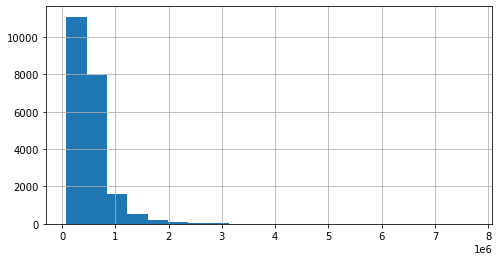

In [20]:
check_normality(kc, 'price', bins=20)

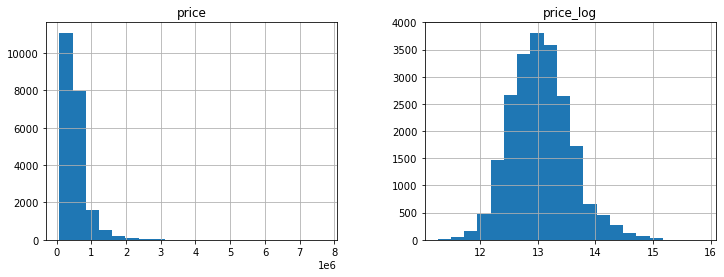

price_log skew: 0.43107952959103885
price_log kurtosis: 0.6910469577374965


In [23]:
# Creating price log column given skew
create_log(kc, 'price', col_pos=3, bins=20)

**Notes of Price Log**
- Price is highly skewed with 198 values more than 4 standard deviations from the mean
- Going ahead and creating price_log column and as shown above, it's relatively normal with little skew.
- Price log looks great, 0.4 skew and 0.7 kurtosis, should hold up much better in linear models.
- Price_log will be available for use in Model section

#### Price Box

-0.2361553521948681
price_box 4 Std Dev: 4.134068369733234 | Home Counts above this size: 1 | Skew: -0.011919937023303982 | Kurtosis: 0.3062722180959363


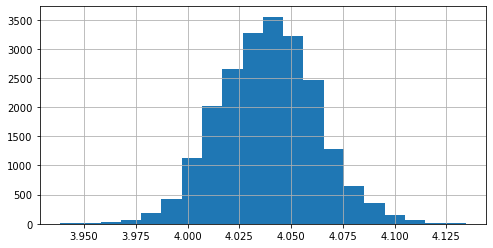

In [24]:
# apply boxcox to price to see if this feature is better than price_log
price_box = []
price_box, price_lambda = stats.boxcox(kc.price)
kc.insert(loc=4, column='price_box', value=pd.Series(price_box))
print(price_lambda)
check_normality(kc, 'price_box', bins=20)

In [25]:
# check if nan issue is found from boxcox transformation not working on last record
kc[kc.price_box.isnull()==True]

id       date      price  price_log  price_box  bedrooms  \
21596  1523300157 2014-10-15 325,000.00      12.69        nan         2   

       bathrooms  sqft_living  sqft_lot  floors  waterfront  view  condition  \
21596       0.75         1020      1076    2.00        0.00  0.00          3   

       grade  sqft_above  sqft_basement  yr_built  yr_renovated  zipcode  \
21596      7        1020              0      2008             0    98144   

        lat    long  sqft_living15  sqft_lot15  
21596 47.59 -122.30           1020        1357

In [26]:
# correcting nan on last records, fill with median
box_fillna(kc, 'price_box')

#### Lot Size Log

sqft_lot 4 Std Dev: 180754.02778204082 | Home Counts above this size: 291 | Skew: 13.072314761216806 | Kurtosis: 285.48321449984576


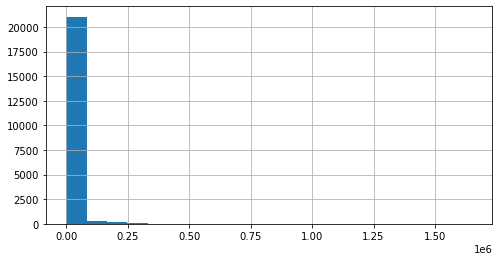

In [27]:
check_normality(kc, 'sqft_lot', bins=20)

**Notes on Lot Size**
- 291 outliers above 4 standard deviations "mega lots"
- Usually lot size should be a significant variable in price, going transform or adjust for these mega size lots

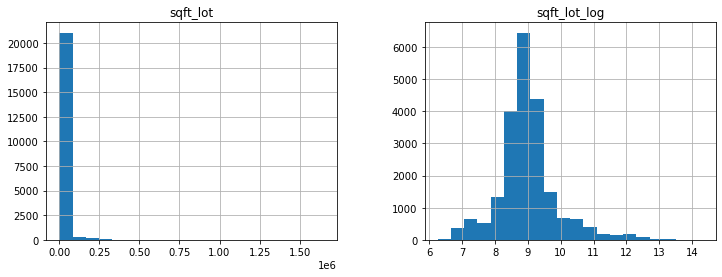

sqft_lot_log skew: 0.962441865571436
sqft_lot_log kurtosis: 3.3297326183287126


In [28]:
# Creating lot_size log column given skew
create_log(kc, 'sqft_lot', col_pos=9, bins=20)

**Notes on Lot Size Log**
- Outliers make lot_size highly positively skewed
- Log function brings to normal, almost perfect with Skew near 1 and Kurtosis near 3.

#### Lot Size Box

-0.19297462232104715
sqft_lot_box 4 Std Dev: 4.8656846419159745 | Home Counts above this size: 0 | Skew: -0.10698100645759137 | Kurtosis: 1.9132610561751


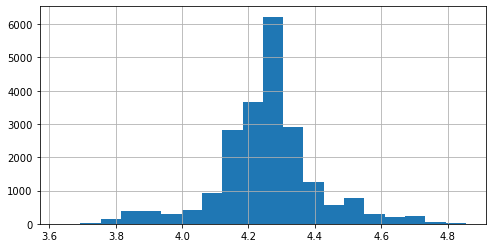

In [29]:
# apply boxcox to sqft_lot to see if this feature is better than sqft_lot_log
sqft_lot_box = []
sqft_lot_box, sqft_box_lambda = stats.boxcox(kc.sqft_lot)
kc.insert(loc=10, column='sqft_lot_box', value=pd.Series(sqft_lot_box))
print(sqft_box_lambda)
check_normality(kc, 'sqft_lot_box', bins=20)

In [30]:
# correcting nan on last records, fill with median
box_fillna(kc, 'sqft_lot_box')

#### Sqft Living Log

sqft_living 4 Std Dev: 5752.831318641844 | Home Counts above this size: 94 | Skew: 1.4731432590101492 | Kurtosis: 5.251772275175187


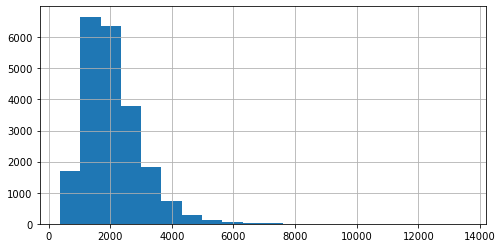

In [31]:
check_normality(kc, 'sqft_living', bins=20)

**Notes on Square Foot Living**
- 94 outliers above 4 standard deviations "mega homes"
- Let's create a log transform to see how normal we can get since sqft_living will be one of our top predictors
- Validated there are no 0 values in field before log transform

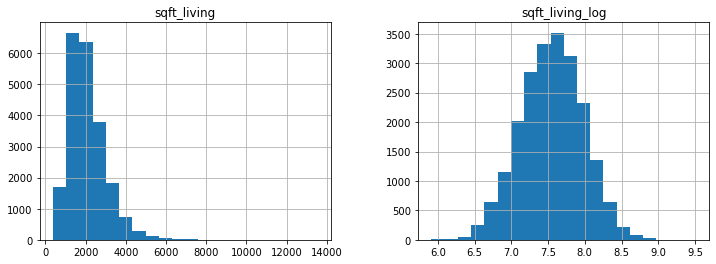

sqft_living_log skew: -0.02741167569494022
sqft_living_log kurtosis: -0.07913378171831864


In [32]:
# Creating lot_size log column given skew
create_log(kc, 'sqft_living', col_pos=8, bins=20)

#### Sqft Living Box

0.02221621916765391
sqft_living_box 4 Std Dev: 10.229929408172227 | Home Counts above this size: 2 | Skew: -0.0003251050729460044 | Kurtosis: -0.07383931972154079


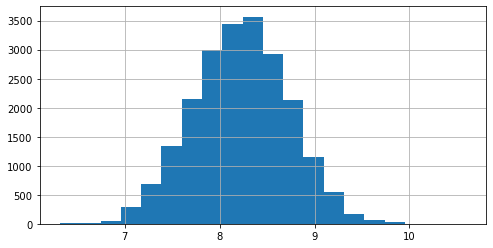

In [33]:
# apply boxcox to sqft_living to see if this feature is better than sqft_living_log
sqft_living_box = []
sqft_living_box, sqft_living_lambda = stats.boxcox(kc.sqft_living)
kc.insert(loc=9, column='sqft_living_box', value=pd.Series(sqft_living_box))
print(sqft_living_lambda)
check_normality(kc, 'sqft_living_box', bins=20)

In [34]:
# check if nan issue on one record 21596 persists
kc[kc.sqft_living_box.isnull()==True]

id       date      price  price_log  price_box  bedrooms  \
21596  1523300157 2014-10-15 325,000.00      12.69       4.04         2   

       bathrooms  sqft_living  sqft_living_log  sqft_living_box  sqft_lot  \
21596       0.75         1020             6.93              nan      1076   

       sqft_lot_log  sqft_lot_box  floors  waterfront  view  condition  grade  \
21596          6.98          4.26    2.00        0.00  0.00          3      7   

       sqft_above  sqft_basement  yr_built  yr_renovated  zipcode   lat  \
21596        1020              0      2008             0    98144 47.59   

         long  sqft_living15  sqft_lot15  
21596 -122.30           1020        1357

In [35]:
# correcting nan on last records, fill with median
box_fillna(kc, 'sqft_living_box')

#### Sqft  Above Log

sqft_above 4 Std Dev: 5099.684509596148 | Home Counts above this size: 74 | Skew: 1.4473915739212342 | Kurtosis: 3.405434947265481


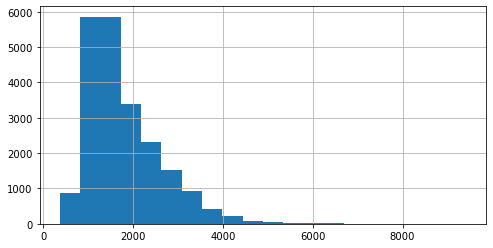

In [36]:
check_normality(kc, 'sqft_above', bins=20)

**Notes on Square Foot Living**
- 94 outliers above 4 standard deviations "mega homes"
- Let's create a log transform to see how normal we can get since sqft_living will be one of our top predictors

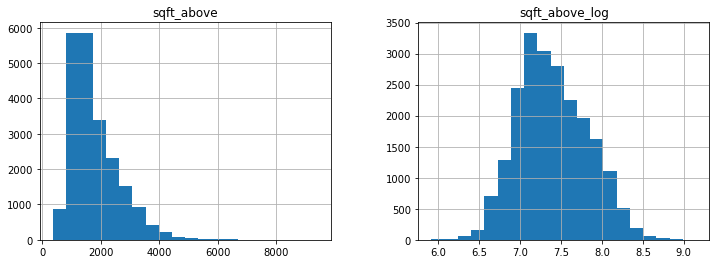

sqft_above_log skew: 0.25962050320447505
sqft_above_log kurtosis: -0.3338961015253301


In [37]:
create_log(kc, 'sqft_above', col_pos=19, bins=20)

#### Sqft Living15

sqft_living15 4 Std Dev: 4727.577796024879 | Home Counts above this size: 55 | Skew: 1.1068279971780404 | Kurtosis: 1.591675171866683


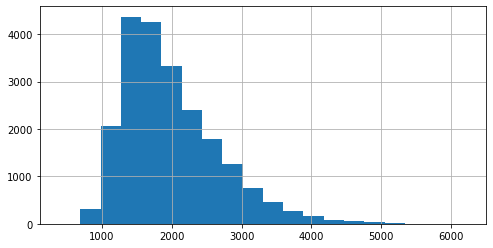

In [38]:
check_normality(kc, 'sqft_living15', bins=20)

**Notes on Sq Ft Living 15**
- Sqft_living15 slightly skewed positively, but not going to pursue log transform at this point.

#### Sqft Lot 15 Log

sqft_lot15 4 Std Dev: 121858.72991368518 | Home Counts above this size: 260 | Skew: 9.524159388368144 | Kurtosis: 151.38924172175214


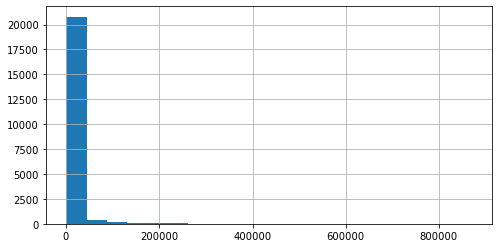

In [39]:
check_normality(kc, 'sqft_lot15', bins=20)

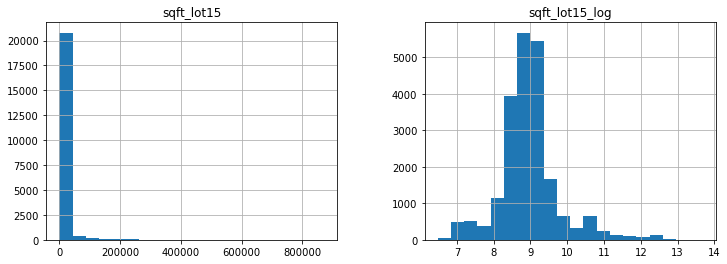

sqft_lot15_log skew: 0.9661306389463542
sqft_lot15_log kurtosis: 3.564141691595105


In [40]:
create_log(kc, 'sqft_lot15', col_pos=28, bins=20)

**Notes on Sqft Lot 15**
- Tons of outliers, highly skewed like lot size.
- Log transformation brings into normal shape with near 1 skew and 3.6 kurosis

#### Bedrooms Log

bedrooms 4 Std Dev: 6.988283034250895 | Home Counts above this size: 61 | Skew: 0.5513819025070226 | Kurtosis: 1.7974823436385439


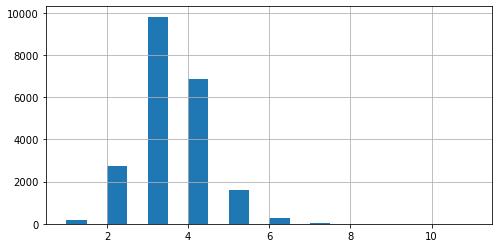

In [41]:
check_normality(kc, 'bedrooms', bins=20)

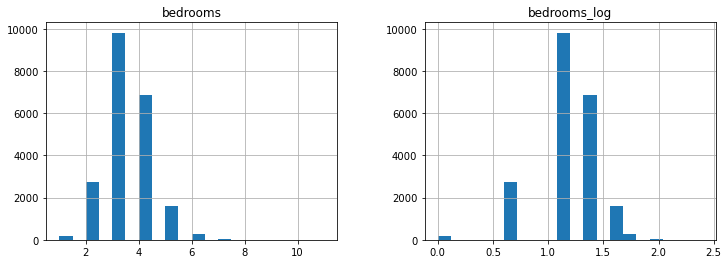

bedrooms_log skew: -0.7081340456551628
bedrooms_log kurtosis: 1.872540737687534


In [42]:
create_log(kc, 'bedrooms', col_pos=6, bins=20)

#### Bedrooms Box

0.5853619981038436
bedrooms_box 4 Std Dev: 3.9310226424213295 | Home Counts above this size: 23 | Skew: 0.04696202835031031 | Kurtosis: 0.9475444757643201


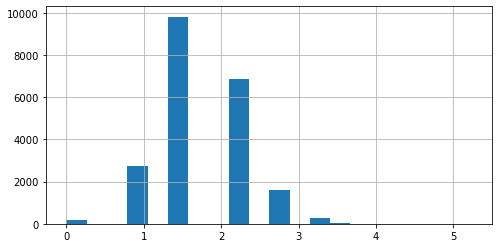

In [43]:
# apply boxcox to sqft_living to see if this feature is better than sqft_living_log
bedrooms_box = []
bedrooms_box, bedrooms_lambda = stats.boxcox(kc.bedrooms)
kc.insert(loc=7, column='bedrooms_box', value=pd.Series(bedrooms_box))
print(bedrooms_lambda)
check_normality(kc, 'bedrooms_box', bins=20)

In [44]:
kc.tail(1)

id       date      price  price_log  price_box  bedrooms  \
21596  1523300157 2014-10-15 325,000.00      12.69       4.04         2   

       bedrooms_log  bedrooms_box  bathrooms  sqft_living  sqft_living_log  \
21596          0.69           nan       0.75         1020             6.93   

       sqft_living_box  sqft_lot  sqft_lot_log  sqft_lot_box  floors  \
21596             8.23      1076          6.98          4.26    2.00   

       waterfront  view  condition  grade  sqft_above  sqft_above_log  \
21596        0.00  0.00          3      7        1020            6.93   

       sqft_basement  yr_built  yr_renovated  zipcode   lat    long  \
21596              0      2008             0    98144 47.59 -122.30   

       sqft_living15  sqft_lot15  sqft_lot15_log  
21596           1020        1357            7.21

In [45]:
# correcting nan on last records, fill with median
box_fillna(kc, 'bedrooms_box')

#### Bathrooms Log

bathrooms 4 Std Dev: 5.19183549788859 | Home Counts above this size: 43 | Skew: 0.5196443164494425 | Kurtosis: 1.2791586870954577


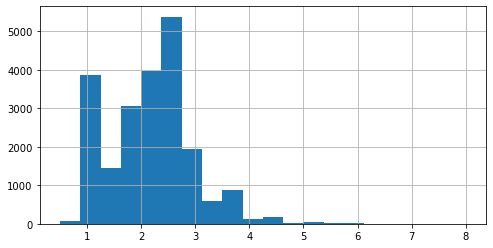

In [46]:
check_normality(kc, 'bathrooms', bins=20)

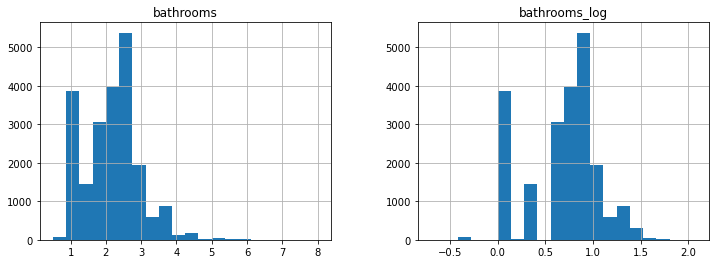

bathrooms_log skew: -0.4933014063951873
bathrooms_log kurtosis: -0.46387674535462864


In [47]:
create_log(kc, 'bathrooms', col_pos=9, bins=20)

#### Bathrooms Box

0.5346126015678513
bathrooms_box 4 Std Dev: 3.0709382512250003 | Home Counts above this size: 10 | Skew: -0.02415740747364864 | Kurtosis: -0.1047594861960861


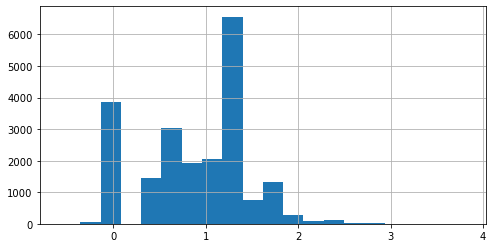

In [48]:
# apply boxcox to sqft_living to see if this feature is better than sqft_living_log
bathrooms_box = []
bathrooms_box, bathrooms_lambda = stats.boxcox(kc.bathrooms)
kc.insert(loc=10, column='bathrooms_box', value=pd.Series(bathrooms_box))
print(bathrooms_lambda)
check_normality(kc, 'bathrooms_box', bins=20)

In [49]:
kc.tail(1)

id       date      price  price_log  price_box  bedrooms  \
21596  1523300157 2014-10-15 325,000.00      12.69       4.04         2   

       bedrooms_log  bedrooms_box  bathrooms  bathrooms_log  bathrooms_box  \
21596          0.69          1.54       0.75          -0.29            nan   

       sqft_living  sqft_living_log  sqft_living_box  sqft_lot  sqft_lot_log  \
21596         1020             6.93             8.23      1076          6.98   

       sqft_lot_box  floors  waterfront  view  condition  grade  sqft_above  \
21596          4.26    2.00        0.00  0.00          3      7        1020   

       sqft_above_log  sqft_basement  yr_built  yr_renovated  zipcode   lat  \
21596            6.93              0      2008             0    98144 47.59   

         long  sqft_living15  sqft_lot15  sqft_lot15_log  
21596 -122.30           1020        1357            7.21

In [50]:
# correcting nan on last records, fill with median
box_fillna(kc, 'bathrooms_box')

#### Renovation Indicator

In [51]:
# create indicator column for homes with a renovation as indicated by a non-null yr_renovated (1 = renovation)
kc.insert(loc=27, column='renovation_ind', value=np.where((kc.yr_renovated.isnull()) | (kc.yr_renovated==0), 0, 1))
kc.head() 

id       date      price  price_log  price_box  bedrooms  \
0  7129300520 2014-10-13 221,900.00      12.31       4.00         3   
1  6414100192 2014-12-09 538,000.00      13.20       4.05         3   
2  5631500400 2015-02-25 180,000.00      12.10       3.99         2   
3  2487200875 2014-12-09 604,000.00      13.31       4.05         4   
4  1954400510 2015-02-18 510,000.00      13.14       4.04         3   

   bedrooms_log  bedrooms_box  bathrooms  bathrooms_log  bathrooms_box  \
0          1.10          1.54       1.00           0.00           0.00   
1          1.10          1.54       2.25           0.81           1.02   
2          0.69          0.85       1.00           0.00           0.00   
3          1.39          2.14       3.00           1.10           1.49   
4          1.10          1.54       2.00           0.69           0.84   

   sqft_living  sqft_living_log  sqft_living_box  sqft_lot  sqft_lot_log  \
0         1180             7.07             7.66      5650          8.64   
1         2570             7.85             8.58      7242          8.89   
2          770             6.65             7.16     10000          9.21   
3         1960             7.58             8.26      5000          8.52   
4         1680             7.43             8.07      8080          9.00   

   sqft_lot_box  floors  waterfront  view  condition  grade  sqft_above  \
0          4.20    1.00        0.00  0.00          3      7        1180   
1          4.25    2.00        0.00  0.00          3      7        2170   
2          4.31    1.00        0.00  0.00          3      6         770   
3          4.18    1.00        0.00  0.00          5      7        1050   
4          4.27    1.00        0.00  0.00          3      8        1680   

   sqft_above_log  sqft_basement  yr_built  yr_renovated  renovation_ind  \
0            7.07              0      1955             0               0   
1            7.68            400      1951          1991               1   
2            6.65              0      1933             0               0   
3            6.96            910      1965             0               0   
4            7.43              0      1987             0               0   

   zipcode   lat    long  sqft_living15  sqft_lot15  sqft_lot15_log  
0    98178 47.51 -122.26           1340        5650            8.64  
1    98125 47.72 -122.32           1690        7639            8.94  
2    98028 47.74 -122.23           2720        8062            8.99  
3    98136 47.52 -122.39           1360        5000            8.52  
4    98074 47.62 -122.05           1800        7503            8.92

#### Basement Indicator

In [52]:
# create indicator column for homes with basement based on non-zero sqft_basement
kc.insert(loc=25, column='basement_ind', value=np.where(kc.sqft_basement==0, 0, 1))
kc.head() 

id       date      price  price_log  price_box  bedrooms  \
0  7129300520 2014-10-13 221,900.00      12.31       4.00         3   
1  6414100192 2014-12-09 538,000.00      13.20       4.05         3   
2  5631500400 2015-02-25 180,000.00      12.10       3.99         2   
3  2487200875 2014-12-09 604,000.00      13.31       4.05         4   
4  1954400510 2015-02-18 510,000.00      13.14       4.04         3   

   bedrooms_log  bedrooms_box  bathrooms  bathrooms_log  bathrooms_box  \
0          1.10          1.54       1.00           0.00           0.00   
1          1.10          1.54       2.25           0.81           1.02   
2          0.69          0.85       1.00           0.00           0.00   
3          1.39          2.14       3.00           1.10           1.49   
4          1.10          1.54       2.00           0.69           0.84   

   sqft_living  sqft_living_log  sqft_living_box  sqft_lot  sqft_lot_log  \
0         1180             7.07             7.66      5650          8.64   
1         2570             7.85             8.58      7242          8.89   
2          770             6.65             7.16     10000          9.21   
3         1960             7.58             8.26      5000          8.52   
4         1680             7.43             8.07      8080          9.00   

   sqft_lot_box  floors  waterfront  view  condition  grade  sqft_above  \
0          4.20    1.00        0.00  0.00          3      7        1180   
1          4.25    2.00        0.00  0.00          3      7        2170   
2          4.31    1.00        0.00  0.00          3      6         770   
3          4.18    1.00        0.00  0.00          5      7        1050   
4          4.27    1.00        0.00  0.00          3      8        1680   

   sqft_above_log  sqft_basement  basement_ind  yr_built  yr_renovated  \
0            7.07              0             0      1955             0   
1            7.68            400             1      1951          1991   
2            6.65              0             0      1933             0   
3            6.96            910             1      1965             0   
4            7.43              0             0      1987             0   

   renovation_ind  zipcode   lat    long  sqft_living15  sqft_lot15  \
0               0    98178 47.51 -122.26           1340        5650   
1               1    98125 47.72 -122.32           1690        7639   
2               0    98028 47.74 -122.23           2720        8062   
3               0    98136 47.52 -122.39           1360        5000   
4               0    98074 47.62 -122.05           1800        7503   

   sqft_lot15_log  
0            8.64  
1            8.94  
2            8.99  
3            8.52  
4            8.92

#### Sqft Per Bedroom Log

In [53]:
# adding feature which shows home sqft per bedroom; intent of feature is to adjust older homes with lots of smaller bedrooms
kc.insert(loc=8, column='sqft_per_bedroom', value=kc['sqft_living']/kc['bedrooms'])
kc.head()

id       date      price  price_log  price_box  bedrooms  \
0  7129300520 2014-10-13 221,900.00      12.31       4.00         3   
1  6414100192 2014-12-09 538,000.00      13.20       4.05         3   
2  5631500400 2015-02-25 180,000.00      12.10       3.99         2   
3  2487200875 2014-12-09 604,000.00      13.31       4.05         4   
4  1954400510 2015-02-18 510,000.00      13.14       4.04         3   

   bedrooms_log  bedrooms_box  sqft_per_bedroom  bathrooms  bathrooms_log  \
0          1.10          1.54            393.33       1.00           0.00   
1          1.10          1.54            856.67       2.25           0.81   
2          0.69          0.85            385.00       1.00           0.00   
3          1.39          2.14            490.00       3.00           1.10   
4          1.10          1.54            560.00       2.00           0.69   

   bathrooms_box  sqft_living  sqft_living_log  sqft_living_box  sqft_lot  \
0           0.00         1180             7.07             7.66      5650   
1           1.02         2570             7.85             8.58      7242   
2           0.00          770             6.65             7.16     10000   
3           1.49         1960             7.58             8.26      5000   
4           0.84         1680             7.43             8.07      8080   

   sqft_lot_log  sqft_lot_box  floors  waterfront  view  condition  grade  \
0          8.64          4.20    1.00        0.00  0.00          3      7   
1          8.89          4.25    2.00        0.00  0.00          3      7   
2          9.21          4.31    1.00        0.00  0.00          3      6   
3          8.52          4.18    1.00        0.00  0.00          5      7   
4          9.00          4.27    1.00        0.00  0.00          3      8   

   sqft_above  sqft_above_log  sqft_basement  basement_ind  yr_built  \
0        1180            7.07              0             0      1955   
1        2170            7.68            400             1      1951   
2         770            6.65              0             0      1933   
3        1050            6.96            910             1      1965   
4        1680            7.43              0             0      1987   

   yr_renovated  renovation_ind  zipcode   lat    long  sqft_living15  \
0             0               0    98178 47.51 -122.26           1340   
1          1991               1    98125 47.72 -122.32           1690   
2             0               0    98028 47.74 -122.23           2720   
3             0               0    98136 47.52 -122.39           1360   
4             0               0    98074 47.62 -122.05           1800   

   sqft_lot15  sqft_lot15_log  
0        5650            8.64  
1        7639            8.94  
2        8062            8.99  
3        5000            8.52  
4        7503            8.92

sqft_per_bedroom 4 Std Dev: 1481.651473156983 | Home Counts above this size: 92 | Skew: 1.5715424423371083 | Kurtosis: 5.793649351527834


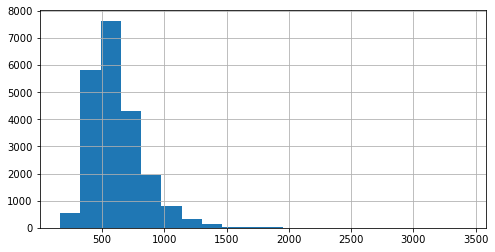

In [54]:
check_normality(kc, 'sqft_per_bedroom', bins=20)

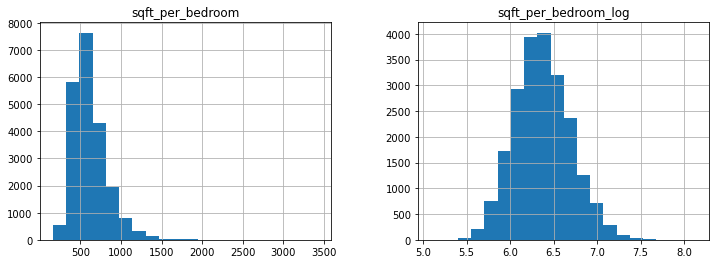

sqft_per_bedroom_log skew: 0.28789619313930154
sqft_per_bedroom_log kurtosis: 0.1447890918941246


In [55]:
create_log(kc, 'sqft_per_bedroom', col_pos=9, bins=20)

#### Bedrooms Derived

In [56]:
# create simple feature that caps bedrooms at 6 to pulls in outliers
kc.insert(loc=10, column='bedroom_der', value=kc.bedrooms.map(lambda x: x if x<=6 else 6))

#### Grade Group

In [57]:
# feature groups grades into average, below avg, above avg and excellent. 
# intent of feature is to see whether categorical treatment improves performance over treating grade as continuous
grade_map = lambda x: 'gr0_avg' if x == 7 \
            else 'gr1_below' if x < 7 \
            else 'gr2_above_avg' if x < 11 \
            else 'gr_3_excellent'

kc.insert(
    loc=25, column='grade_grp',
    value=kc.grade.map(grade_map)
    )

kc['grade_grp']=kc['grade_grp'].astype('category') # for one-hot encoding

kc.head()

id       date      price  price_log  price_box  bedrooms  \
0  7129300520 2014-10-13 221,900.00      12.31       4.00         3   
1  6414100192 2014-12-09 538,000.00      13.20       4.05         3   
2  5631500400 2015-02-25 180,000.00      12.10       3.99         2   
3  2487200875 2014-12-09 604,000.00      13.31       4.05         4   
4  1954400510 2015-02-18 510,000.00      13.14       4.04         3   

   bedrooms_log  bedrooms_box  sqft_per_bedroom  sqft_per_bedroom_log  \
0          1.10          1.54            393.33                  5.97   
1          1.10          1.54            856.67                  6.75   
2          0.69          0.85            385.00                  5.95   
3          1.39          2.14            490.00                  6.19   
4          1.10          1.54            560.00                  6.33   

   bedroom_der  bathrooms  bathrooms_log  bathrooms_box  sqft_living  \
0            3       1.00           0.00           0.00         1180   
1            3       2.25           0.81           1.02         2570   
2            2       1.00           0.00           0.00          770   
3            4       3.00           1.10           1.49         1960   
4            3       2.00           0.69           0.84         1680   

   sqft_living_log  sqft_living_box  sqft_lot  sqft_lot_log  sqft_lot_box  \
0             7.07             7.66      5650          8.64          4.20   
1             7.85             8.58      7242          8.89          4.25   
2             6.65             7.16     10000          9.21          4.31   
3             7.58             8.26      5000          8.52          4.18   
4             7.43             8.07      8080          9.00          4.27   

   floors  waterfront  view  condition  grade      grade_grp  sqft_above  \
0    1.00        0.00  0.00          3      7        gr0_avg        1180   
1    2.00        0.00  0.00          3      7        gr0_avg        2170   
2    1.00        0.00  0.00          3      6      gr1_below         770   
3    1.00        0.00  0.00          5      7        gr0_avg        1050   
4    1.00        0.00  0.00          3      8  gr2_above_avg        1680   

   sqft_above_log  sqft_basement  basement_ind  yr_built  yr_renovated  \
0            7.07              0             0      1955             0   
1            7.68            400             1      1951          1991   
2            6.65              0             0      1933             0   
3            6.96            910             1      1965             0   
4            7.43              0             0      1987             0   

   renovation_ind  zipcode   lat    long  sqft_living15  sqft_lot15  \
0               0    98178 47.51 -122.26           1340        5650   
1               1    98125 47.72 -122.32           1690        7639   
2               0    98028 47.74 -122.23           2720        8062   
3               0    98136 47.52 -122.39           1360        5000   
4               0    98074 47.62 -122.05           1800        7503   

   sqft_lot15_log  
0            8.64  
1            8.94  
2            8.99  
3            8.52  
4            8.92

#### Miles From Seattle

In most cities, proximity to city centers drives prices higher. This feature will measure the distance in miles from Seatte's center. There will likely be some collinearity with zipcode-based features, but let's see.

In [58]:
# create tuple for each home of latitude and longitudes to feed mileage calculation
seattle_coord = (47.608013, -122.335167) # seattle city center coord - https://www.latlong.net/place/seattle-wa-usa-2655.html
kc.insert(loc=36, column='home_lat_long',value = tuple(zip(kc.lat, kc.long)))

In [59]:
# create feature of miles from city center of Seattle
seattle_calc = [haversine(home, seattle_coord, unit='mi')
                for home in kc['home_lat_long']]
    
kc['miles_fr_seattle'] = pd.Series(seattle_calc)
kc.miles_fr_seattle.fillna(kc.miles_fr_seattle.median(), inplace=True)
kc.head()

id       date      price  price_log  price_box  bedrooms  \
0  7129300520 2014-10-13 221,900.00      12.31       4.00         3   
1  6414100192 2014-12-09 538,000.00      13.20       4.05         3   
2  5631500400 2015-02-25 180,000.00      12.10       3.99         2   
3  2487200875 2014-12-09 604,000.00      13.31       4.05         4   
4  1954400510 2015-02-18 510,000.00      13.14       4.04         3   

   bedrooms_log  bedrooms_box  sqft_per_bedroom  sqft_per_bedroom_log  \
0          1.10          1.54            393.33                  5.97   
1          1.10          1.54            856.67                  6.75   
2          0.69          0.85            385.00                  5.95   
3          1.39          2.14            490.00                  6.19   
4          1.10          1.54            560.00                  6.33   

   bedroom_der  bathrooms  bathrooms_log  bathrooms_box  sqft_living  \
0            3       1.00           0.00           0.00         1180   
1            3       2.25           0.81           1.02         2570   
2            2       1.00           0.00           0.00          770   
3            4       3.00           1.10           1.49         1960   
4            3       2.00           0.69           0.84         1680   

   sqft_living_log  sqft_living_box  sqft_lot  sqft_lot_log  sqft_lot_box  \
0             7.07             7.66      5650          8.64          4.20   
1             7.85             8.58      7242          8.89          4.25   
2             6.65             7.16     10000          9.21          4.31   
3             7.58             8.26      5000          8.52          4.18   
4             7.43             8.07      8080          9.00          4.27   

   floors  waterfront  view  condition  grade      grade_grp  sqft_above  \
0    1.00        0.00  0.00          3      7        gr0_avg        1180   
1    2.00        0.00  0.00          3      7        gr0_avg        2170   
2    1.00        0.00  0.00          3      6      gr1_below         770   
3    1.00        0.00  0.00          5      7        gr0_avg        1050   
4    1.00        0.00  0.00          3      8  gr2_above_avg        1680   

   sqft_above_log  sqft_basement  basement_ind  yr_built  yr_renovated  \
0            7.07              0             0      1955             0   
1            7.68            400             1      1951          1991   
2            6.65              0             0      1933             0   
3            6.96            910             1      1965             0   
4            7.43              0             0      1987             0   

   renovation_ind  zipcode   lat    long                   home_lat_long  \
0               0    98178 47.51 -122.26             (47.5112, -122.257)   
1               1    98125 47.72 -122.32  (47.721000000000004, -122.319)   
2               0    98028 47.74 -122.23  (47.7379, -122.23299999999999)   
3               0    98136 47.52 -122.39  (47.5208, -122.39299999999999)   
4               0    98074 47.62 -122.05             (47.6168, -122.045)   

   sqft_living15  sqft_lot15  sqft_lot15_log  miles_fr_seattle  
0           1340        5650            8.64              7.62  
1           1690        7639            8.94              7.84  
2           2720        8062            8.99             10.16  
3           1360        5000            8.52              6.60  
4           1800        7503            8.92             13.53

In [60]:
# check is calculation generates any nan
kc[kc['miles_fr_seattle'].isna()==True].head()

Empty DataFrame
Columns: [id, date, price, price_log, price_box, bedrooms, bedrooms_log, bedrooms_box, sqft_per_bedroom, sqft_per_bedroom_log, bedroom_der, bathrooms, bathrooms_log, bathrooms_box, sqft_living, sqft_living_log, sqft_living_box, sqft_lot, sqft_lot_log, sqft_lot_box, floors, waterfront, view, condition, grade, grade_grp, sqft_above, sqft_above_log, sqft_basement, basement_ind, yr_built, yr_renovated, renovation_ind, zipcode, lat, long, home_lat_long, sqft_living15, sqft_lot15, sqft_lot15_log, miles_fr_seattle]
Index: []

miles_fr_seattle 4 Std Dev: 38.207922157708985 | Home Counts above this size: 18 | Skew: 0.7669121405508273 | Kurtosis: 0.36602428452820357


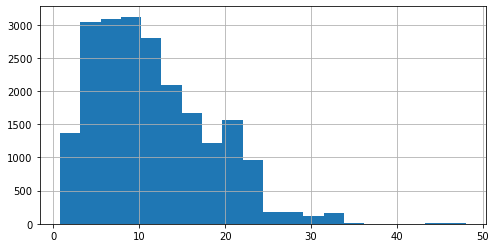

In [61]:
check_normality(kc, 'miles_fr_seattle')

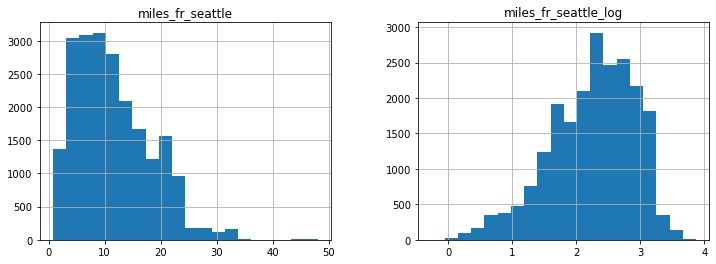

miles_fr_seattle_log skew: -0.5909581116428807
miles_fr_seattle_log kurtosis: -0.022811683040730113


In [62]:
# create log feature for miles from seattle to normalize
create_log(kc, 'miles_fr_seattle', col_pos=37, bins=20)

miles_fr_seattle_sqrt 4 Std Dev: 7.212433819932752 | Home Counts above this size: 0 | Skew: 0.12991689958589042 | Kurtosis: -0.5808706476636059


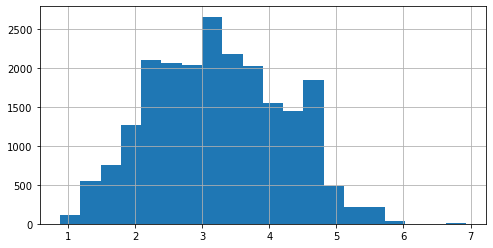

In [63]:
# check if square foot of miles from seattle provides better normality
kc['miles_fr_seattle_sqrt']=np.sqrt(kc['miles_fr_seattle'])
check_normality(kc, 'miles_fr_seattle_sqrt')

#### Zip Price Sqft Decile

This feature was crafted after not being satisfied with using zip code as categorical one-hot-encoded variable (due to skewed QQ-plots/residuals). This feature maps a decile (10 groups) to each of the 70 zip codes based on median sales price per square foot. The thought was that using deciles would simplify all the zipcodes and force a more normal distribution.

In [64]:
# create column for price per square foot of living
kc['price_sf'] = kc['price']/kc['sqft_living']

In [65]:
# create a dataframe grouping zipcodes with median price per square foot
zip_psf = kc.groupby('zipcode')['price_sf'].median().reset_index()

<AxesSubplot:>

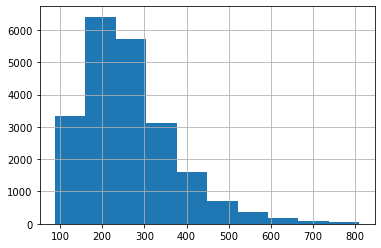

In [66]:
# check distribution of price per square foot on entire dataset
kc['price_sf'].hist()

<AxesSubplot:>

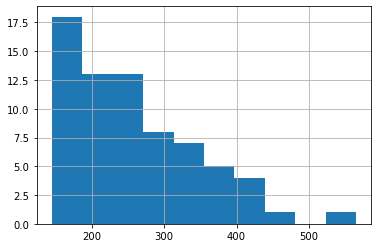

In [67]:
# check distribution of price per square foot medians on zip code group by
zip_psf['price_sf'].hist()

<AxesSubplot:>

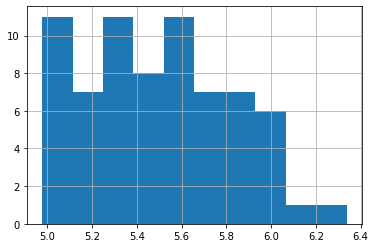

In [68]:
# see if log of zip codes helps normality
np.log(zip_psf['price_sf']).hist()

In [69]:
# see if boxcox transformation helps normality of feature
fitted_data, fitted_lambda = stats.boxcox(zip_psf['price_sf'])
print(f'fitted lambda is {fitted_lambda}')

fitted lambda is -0.41015480777301483


In [70]:
# apply boxcox to zip_psf to see if this feature is better distribution
box = pd.DataFrame(fitted_data, columns = ['zip_price_sf_box'])
zip_psf_box = pd.concat([zip_psf, box], axis=1)
pd.options.display.float_format = '{:,.8f}'.format
zip_psf_box.head()

zipcode     price_sf  zip_price_sf_box
0    98001 147.14134463        2.12336857
1    98002 147.17741935        2.12340021
2    98003 154.81924571        2.12986667
3    98004 456.94444444        2.24036295
4    98005 316.34043088        2.20817059

zip_price_sf_box 4 Std Dev: 2.3181398805616467 | Home Counts above this size: 0 | Skew: 0.04165867960961311 | Kurtosis: -0.8938377485526492


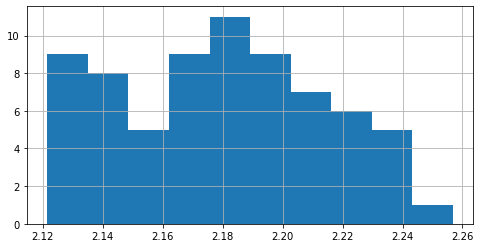

In [71]:
check_normality(zip_psf_box, 'zip_price_sf_box', bins=10)

Distribution of boxcox price per square foot is not idea but best option. Proceed with creating deciles

In [72]:
# get the bin edges of 10 deciles with retbin
results, bins_edges = pd.qcut(zip_psf_box['zip_price_sf_box'], q=10, retbins=True)

# function to create intervals dictionary from array of bin edges
def create_intervals(array):
    ''' Simple function to print the width of each bin from the bin edges in the passed list.'''
    interval_dict = {}
    zip_psf_deciles = []
    for index, edge in enumerate(array):
        if index == 0:
            continue
        interval_dict = {'decile': index, 'upper_range': edge}
        zip_psf_deciles.append(interval_dict)
    return zip_psf_deciles

# store decile intervals of boxcox price per square foot in variable zip_psf_deciles
zip_psf_deciles = create_intervals(bins_edges)
zip_psf_deciles

[{'decile': 1, 'upper_range': 2.131502681750592},
 {'decile': 2, 'upper_range': 2.1434853039526396},
 {'decile': 3, 'upper_range': 2.1608433532433304},
 {'decile': 4, 'upper_range': 2.168390229052141},
 {'decile': 5, 'upper_range': 2.1817738704687497},
 {'decile': 6, 'upper_range': 2.1885994360144547},
 {'decile': 7, 'upper_range': 2.199363148678238},
 {'decile': 8, 'upper_range': 2.2138002397137817},
 {'decile': 9, 'upper_range': 2.224337147729981},
 {'decile': 10, 'upper_range': 2.256872144006299}]

In [73]:
# function to return decile for any value
def map_psf_decile(val):
    ''' Function returns a decile value for any price_sf_box value'''
    for d in zip_psf_deciles:
        if val <= d['upper_range']:
            return d['decile']
        elif (d['decile']==10) & (val > d['upper_range']):
            return d['decile']
    return 'value out of range'

In [74]:
# create array of boxcox price_sf from kc dataframe
fit_price_sf = stats.boxcox(kc['price_sf'], fitted_lambda)
box_kc = pd.DataFrame(fit_price_sf, columns = ['price_sf_box'])

In [75]:
# validate lengths
fit_price_sf.shape, box_kc.shape, kc.shape

((21596,), (21596, 1), (21596, 44))

In [76]:
# concatenate primary df with box_kc
kc = pd.concat([kc, box_kc], axis=1)
kc.tail(1)

id       date            price   price_log  \
21596 1,523,300,157.00000000 2014-10-15 325,000.00000000 12.69158046   

       price_box   bedrooms  bedrooms_log  bedrooms_box  sqft_per_bedroom  \
21596 4.03872181 2.00000000    0.69314718    1.54151148      510.00000000   

       sqft_per_bedroom_log  bedroom_der  bathrooms  bathrooms_log  \
21596            6.23441073   2.00000000 0.75000000    -0.28768207   

       bathrooms_box    sqft_living  sqft_living_log  sqft_living_box  \
21596     1.01512581 1,020.00000000       6.92755791       8.22587403   

            sqft_lot  sqft_lot_log  sqft_lot_box     floors  waterfront  \
21596 1,076.00000000    6.98100574    4.25860061 2.00000000  0.00000000   

            view  condition      grade grade_grp     sqft_above  \
21596 0.00000000 3.00000000 7.00000000   gr0_avg 1,020.00000000   

       sqft_above_log  sqft_basement  basement_ind       yr_built  \
21596      6.92755791     0.00000000    0.00000000 2,008.00000000   

       yr_renovated  renovation_ind         zipcode         lat          long  \
21596    0.00000000      0.00000000 98,144.00000000 47.59410000 -122.29900000   

                        home_lat_long  miles_fr_seattle_log  sqft_living15  \
21596  (47.5941, -122.29899999999999)            2.33441902 1,020.00000000   

          sqft_lot15  sqft_lot15_log  miles_fr_seattle  miles_fr_seattle_sqrt  \
21596 1,357.00000000      7.21303166       10.32346046             3.21301423   

          price_sf  price_sf_box  
21596 318.62745098           nan

In [77]:
# correcting nan on last records, fill with median
box_fillna(kc, 'price_sf_box')

In [78]:
# isolate phantom record 15856 that reappears after concat function
kc.iloc[15856:15857]

id date  price  price_log  price_box  bedrooms  bedrooms_log  \
15856 nan  NaT    nan        nan        nan       nan           nan   

       bedrooms_box  sqft_per_bedroom  sqft_per_bedroom_log  bedroom_der  \
15856           nan               nan                   nan          nan   

       bathrooms  bathrooms_log  bathrooms_box  sqft_living  sqft_living_log  \
15856        nan            nan            nan          nan              nan   

       sqft_living_box  sqft_lot  sqft_lot_log  sqft_lot_box  floors  \
15856              nan       nan           nan           nan     nan   

       waterfront  view  condition  grade grade_grp  sqft_above  \
15856         nan   nan        nan    nan       NaN         nan   

       sqft_above_log  sqft_basement  basement_ind  yr_built  yr_renovated  \
15856             nan            nan           nan       nan           nan   

       renovation_ind  zipcode  lat  long home_lat_long  miles_fr_seattle_log  \
15856             nan      nan  nan   nan           NaN                   nan   

       sqft_living15  sqft_lot15  sqft_lot15_log  miles_fr_seattle  \
15856            nan         nan             nan               nan   

       miles_fr_seattle_sqrt  price_sf  price_sf_box  
15856                    nan       nan    2.12695927

In [79]:
# record index 15856, dropped in outliers section keeps reappearing when running this code:
# kc = pd.concat([kc, box_kc], axis=1); somehow the concatenation is bring back this index with all nans.  
kc.drop([15856], inplace=True)

In [80]:
# applying map_psf_deciles function to get deciles in a column
kc['price_sf_box_decile'] = kc['price_sf_box'].apply(lambda x: map_psf_decile(x)).astype(int)

In [81]:
# check for duplicate columns from running multiple times
kc.tail(1)

id       date            price   price_log  \
21596 1,523,300,157.00000000 2014-10-15 325,000.00000000 12.69158046   

       price_box   bedrooms  bedrooms_log  bedrooms_box  sqft_per_bedroom  \
21596 4.03872181 2.00000000    0.69314718    1.54151148      510.00000000   

       sqft_per_bedroom_log  bedroom_der  bathrooms  bathrooms_log  \
21596            6.23441073   2.00000000 0.75000000    -0.28768207   

       bathrooms_box    sqft_living  sqft_living_log  sqft_living_box  \
21596     1.01512581 1,020.00000000       6.92755791       8.22587403   

            sqft_lot  sqft_lot_log  sqft_lot_box     floors  waterfront  \
21596 1,076.00000000    6.98100574    4.25860061 2.00000000  0.00000000   

            view  condition      grade grade_grp     sqft_above  \
21596 0.00000000 3.00000000 7.00000000   gr0_avg 1,020.00000000   

       sqft_above_log  sqft_basement  basement_ind       yr_built  \
21596      6.92755791     0.00000000    0.00000000 2,008.00000000   

       yr_renovated  renovation_ind         zipcode         lat          long  \
21596    0.00000000      0.00000000 98,144.00000000 47.59410000 -122.29900000   

                        home_lat_long  miles_fr_seattle_log  sqft_living15  \
21596  (47.5941, -122.29899999999999)            2.33441902 1,020.00000000   

          sqft_lot15  sqft_lot15_log  miles_fr_seattle  miles_fr_seattle_sqrt  \
21596 1,357.00000000      7.21303166       10.32346046             3.21301423   

          price_sf  price_sf_box  price_sf_box_decile  
21596 318.62745098    2.18260094                    6

In [82]:
# review medians by assigned deciles
kc.groupby('price_sf_box_decile')['price_sf'].median()

price_sf_box_decile
1    143.54066986
2    167.10201651
3    188.29268293
4    208.10810811
5    229.11740159
6    250.00000000
7    272.30046948
8    306.16681072
9    350.82236842
10   417.35537190
Name: price_sf, dtype: float64

price_sf_box 4 Std Dev: 2.3455369341160752 | Home Counts above this size: 0 | Skew: -0.2585338862647854 | Kurtosis: -0.29294699462834517


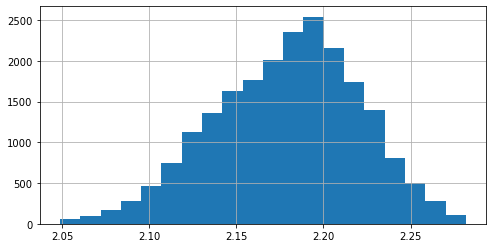

In [83]:
# check distribution for price_sf_box (applied by record)
check_normality(kc, 'price_sf_box')

price_sf 4 Std Dev: 616.2264312072768 | Home Counts above this size: 0 | Skew: 0.9731375539795851 | Kurtosis: 0.83652013622229


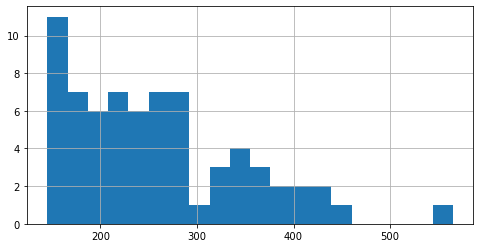

In [84]:
# check distributions of zip code medians
check_normality(zip_psf_box, 'price_sf')

zip_price_sf_box 4 Std Dev: 2.3181398805616467 | Home Counts above this size: 0 | Skew: 0.04165867960961311 | Kurtosis: -0.8938377485526492


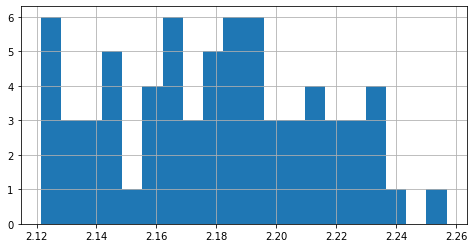

In [85]:
# check distributions of zip code medians boxcox'd
check_normality(zip_psf_box, 'zip_price_sf_box')

price_sf_box_decile 4 Std Dev: 17.750301584014835 | Home Counts above this size: 0 | Skew: -0.07110207640085976 | Kurtosis: -1.297031875548991


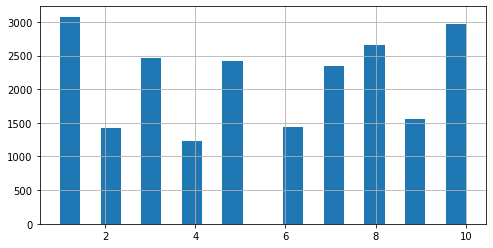

In [86]:
# check distributions of applied deciles
check_normality(kc, 'price_sf_box_decile')

After all this work, this feature did not perform well and applied distributions were skewed negatively towards lower price per square foot deciles. Moved on to another approach below.

#### Zip Price Sqft Box

   Slightly different take on this feature. Apply the zipcode-based median price per square foot to each record based on the zip code.

price_sf 4 Std Dev: 704.1333051746667 | Home Counts above this size: 76 | Skew: 1.2471022617551608 | Kurtosis: 2.0999301666916343


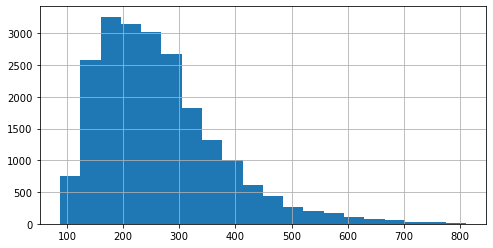

In [87]:
check_normality(kc, 'price_sf')

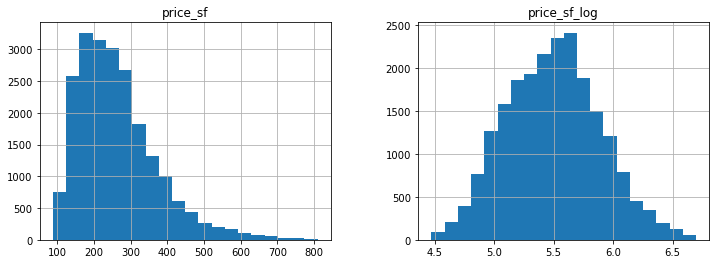

price_sf_log skew: 0.1405260365890009
price_sf_log kurtosis: -0.2951939509791961


In [88]:
create_log(kc, 'price_sf')

In [89]:
# create lookup list of median price_sf for each zipcode
zip_psf_medians = kc.groupby('zipcode')['price_sf'].median()
zip_psf_medians.head()

zipcode
98,001.00000000   147.14134463
98,002.00000000   147.17741935
98,003.00000000   154.81924571
98,004.00000000   456.94444444
98,005.00000000   316.34043088
Name: price_sf, dtype: float64

In [90]:
# apply zip_psf_median lookup to all homes based on zip
kc['zip_psf_median'] = kc.zipcode.apply(
    lambda z: zip_psf_medians.get(z, 'zip not found'))

zip_psf_median 4 Std Dev: 569.7755353275165 | Home Counts above this size: 0 | Skew: 0.6116961603141974 | Kurtosis: -0.1132435579740112


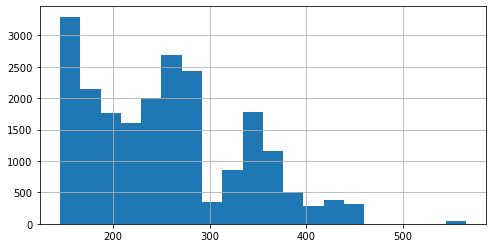

In [91]:
check_normality(kc, 'zip_psf_median')

In [92]:
kc[kc.zip_psf_median.isnull()==True]

Empty DataFrame
Columns: [price_sf_log, id, date, price, price_log, price_box, bedrooms, bedrooms_log, bedrooms_box, sqft_per_bedroom, sqft_per_bedroom_log, bedroom_der, bathrooms, bathrooms_log, bathrooms_box, sqft_living, sqft_living_log, sqft_living_box, sqft_lot, sqft_lot_log, sqft_lot_box, floors, waterfront, view, condition, grade, grade_grp, sqft_above, sqft_above_log, sqft_basement, basement_ind, yr_built, yr_renovated, renovation_ind, zipcode, lat, long, home_lat_long, miles_fr_seattle_log, sqft_living15, sqft_lot15, sqft_lot15_log, miles_fr_seattle, miles_fr_seattle_sqrt, price_sf, price_sf_box, price_sf_box_decile, zip_psf_median]
Index: []

In [93]:
# apply boxcox to zip_psf_median to see if normalizes feature
fit_psf_median, median_lambda = stats.boxcox(kc['zip_psf_median'])
box_zip_median = pd.DataFrame(fit_psf_median, columns=['zip_psf_median_box'])
print(f'zip median lambda is {median_lambda}')

zip median lambda is -0.07960809846686995


zip_psf_median_box 4 Std Dev: 5.242478152668861 | Home Counts above this size: 0 | Skew: 0.0075463489065949055 | Kurtosis: -0.9249159873746322


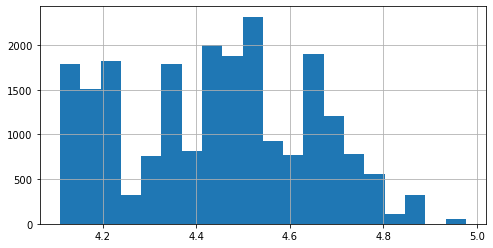

In [94]:
check_normality(box_zip_median, 'zip_psf_median_box')

In [95]:
# concatenate primary dataframe to box feature
kc = pd.concat([kc, box_zip_median], axis=1)

In [96]:
# check for nan on last record
kc.tail(1)

price_sf_log                     id       date            price  \
21596    5.76402256 1,523,300,157.00000000 2014-10-15 325,000.00000000   

        price_log  price_box   bedrooms  bedrooms_log  bedrooms_box  \
21596 12.69158046 4.03872181 2.00000000    0.69314718    1.54151148   

       sqft_per_bedroom  sqft_per_bedroom_log  bedroom_der  bathrooms  \
21596      510.00000000            6.23441073   2.00000000 0.75000000   

       bathrooms_log  bathrooms_box    sqft_living  sqft_living_log  \
21596    -0.28768207     1.01512581 1,020.00000000       6.92755791   

       sqft_living_box       sqft_lot  sqft_lot_log  sqft_lot_box     floors  \
21596       8.22587403 1,076.00000000    6.98100574    4.25860061 2.00000000   

       waterfront       view  condition      grade grade_grp     sqft_above  \
21596  0.00000000 0.00000000 3.00000000 7.00000000   gr0_avg 1,020.00000000   

       sqft_above_log  sqft_basement  basement_ind       yr_built  \
21596      6.92755791     0.00000000    0.00000000 2,008.00000000   

       yr_renovated  renovation_ind         zipcode         lat          long  \
21596    0.00000000      0.00000000 98,144.00000000 47.59410000 -122.29900000   

                        home_lat_long  miles_fr_seattle_log  sqft_living15  \
21596  (47.5941, -122.29899999999999)            2.33441902 1,020.00000000   

          sqft_lot15  sqft_lot15_log  miles_fr_seattle  miles_fr_seattle_sqrt  \
21596 1,357.00000000      7.21303166       10.32346046             3.21301423   

          price_sf  price_sf_box  price_sf_box_decile  zip_psf_median  \
21596 318.62745098    2.18260094           6.00000000    302.63157895   

       zip_psf_median_box  
21596                 nan

In [97]:
# correcting nan on last records, fill with median
box_fillna(kc, 'zip_psf_median_box')

In [98]:
kc[kc.isna().any(axis=1)==True]

price_sf_log  id date  price  price_log  price_box  bedrooms  \
15856           nan nan  NaT    nan        nan        nan       nan   

       bedrooms_log  bedrooms_box  sqft_per_bedroom  sqft_per_bedroom_log  \
15856           nan           nan               nan                   nan   

       bedroom_der  bathrooms  bathrooms_log  bathrooms_box  sqft_living  \
15856          nan        nan            nan            nan          nan   

       sqft_living_log  sqft_living_box  sqft_lot  sqft_lot_log  sqft_lot_box  \
15856              nan              nan       nan           nan           nan   

       floors  waterfront  view  condition  grade grade_grp  sqft_above  \
15856     nan         nan   nan        nan    nan       NaN         nan   

       sqft_above_log  sqft_basement  basement_ind  yr_built  yr_renovated  \
15856             nan            nan           nan       nan           nan   

       renovation_ind  zipcode  lat  long home_lat_long  miles_fr_seattle_log  \
15856             nan      nan  nan   nan           NaN                   nan   

       sqft_living15  sqft_lot15  sqft_lot15_log  miles_fr_seattle  \
15856            nan         nan             nan               nan   

       miles_fr_seattle_sqrt  price_sf  price_sf_box  price_sf_box_decile  \
15856                    nan       nan           nan                  nan   

       zip_psf_median  zip_psf_median_box  
15856             nan          4.11898861

In [99]:
kc.drop([15856], inplace=True)

### Time Series Analysis

#### Sales By Month

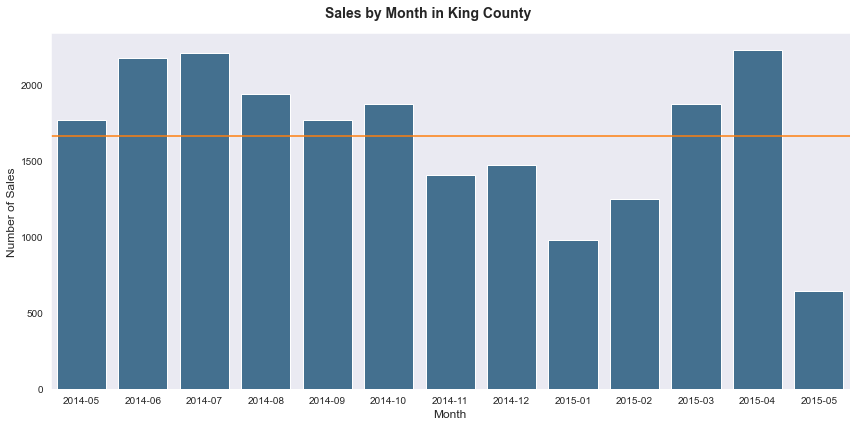

In [101]:
# plot number of sales by month for King County home sales data
kc['sales_cnt']=1 # dummy variable to sum sales
kc['year_month'] = kc.date.dt.to_period('m') # transform date into month
df_grp = kc.groupby(['year_month'])['sales_cnt'].sum().reset_index()

# create barplot with average line
f, ax = plt.subplots(1, 1, figsize=(12, 6))
f.suptitle('Sales by Month in King County', fontsize=14, fontweight ='bold')
sns.set_style("dark")
ax = sns.barplot(data=df_grp, x='year_month', y='sales_cnt', color='tab:blue', saturation=.5)
ax.axhline(df_grp.sales_cnt.mean(), color='tab:orange')
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Number of Sales', fontsize=12)
plt.tight_layout()
plt.show()

**Notes on Sales Trend**
- Total sales transations of 21,597 spread across 13 months with 1,661 average/month in our sample
- May 2015 looks to be a partial month, but we do have a complete 1 year of data (2014-05 through 2015-04)
- Sales time series exhibits expected seasonality in Spring/Summer with slower Winter months

#### Sales By Year Built

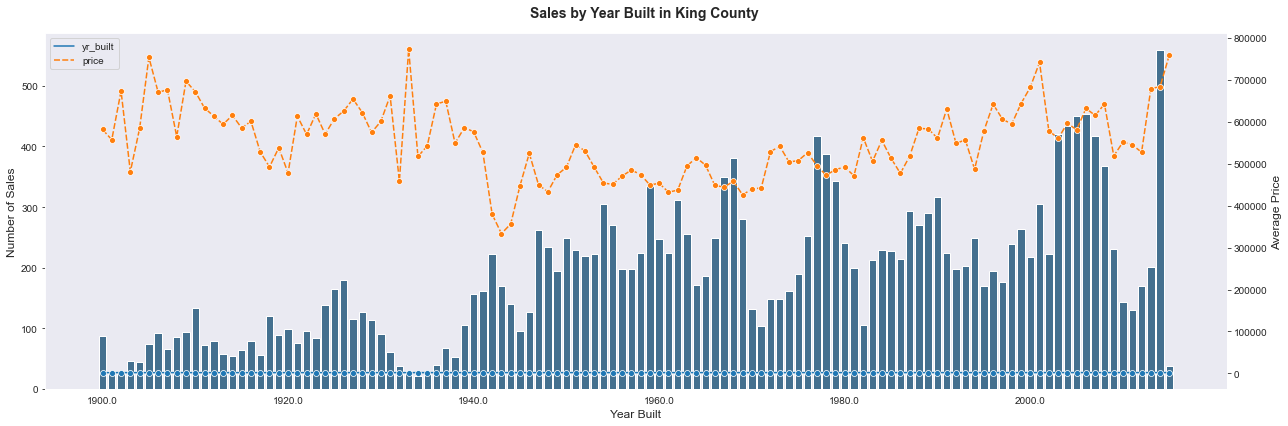

In [103]:
# plot number of sales by month for King County home sales data
df_grp = kc.groupby(['yr_built'])['sales_cnt'].sum().reset_index()
df_grp2 = kc.groupby(['yr_built'])['price'].mean().reset_index()

# create barplot with average line
f, ax = plt.subplots(figsize=(18, 6)) 
f.suptitle('Sales by Year Built in King County', fontsize=14, fontweight ='bold')
sns.set_style("dark")
ax = sns.barplot(data=df_grp, x='yr_built', y='sales_cnt', color='tab:blue', saturation=.5, ax=ax)
ax.set_xlabel('Year Built', fontsize=12)
ax.set_ylabel('Number of Sales', fontsize=12)
ax.xaxis.set_major_locator(ticker.AutoLocator())
ax2 = ax.twinx()
ax2 = sns.lineplot(data=df_grp2, marker='o', ax=ax2)
ax2.set_ylabel('Average Price', fontsize=12)
plt.tight_layout()
plt.show()

**Notes on Sales Trends by Year Built**
- Positive slope with more homes built in recent years in our 2014-15 sales dataset
- Still many homes sold were built more than 50 years ago
- Average price on on historic homes is high. Average price since 1980-built is increasing.

#### Avg Living Space and BR

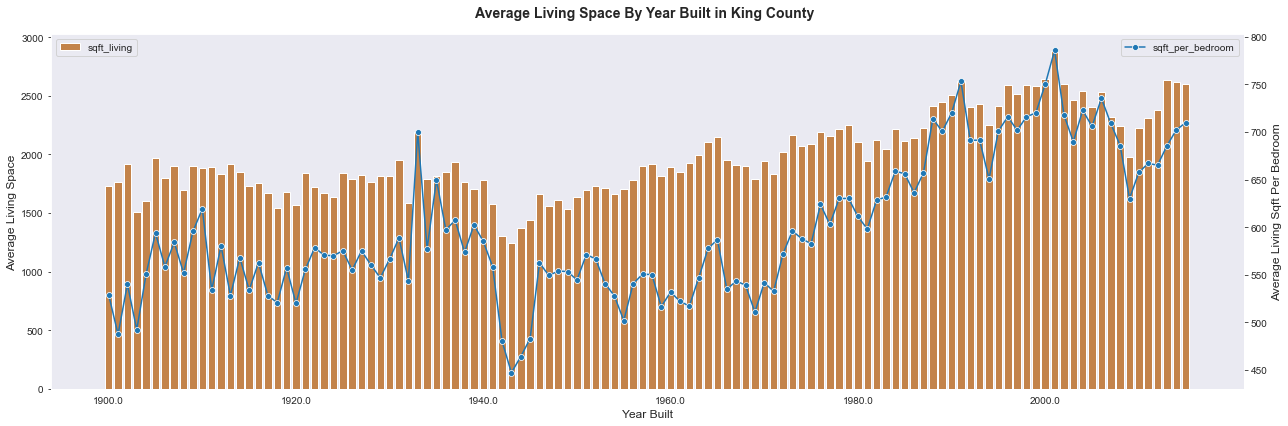

In [104]:
# generate group by year built for sqft_living, bedrooms and sqft_per_bedroom
df_grp = kc.groupby(['yr_built'])['sqft_living'].mean().reset_index()
df_grp2 = kc.groupby(['yr_built'])['bedrooms'].mean().reset_index()
df_grp3 = df_grp.merge(df_grp2)
df_grp3['sqft_per_bedroom']=df_grp3['sqft_living']/df_grp3['bedrooms']

# create barplot of sqft_living with trend line sqft_per_bedroom
f, ax = plt.subplots(figsize=(18, 6)) 
f.suptitle('Average Living Space By Year Built in King County', 
           fontsize=14, fontweight ='bold')
sns.set_style("dark")
ax = sns.barplot(data=df_grp, x='yr_built', y='sqft_living', 
                 color='tab:orange', saturation=.5, ax=ax, label='sqft_living')
ax.set_xlabel('Year Built', fontsize=12)
ax.set_ylabel('Average Living Space', fontsize=12)
ax.legend(loc='upper left')
ax.xaxis.set_major_locator(ticker.AutoLocator())
ax2 = ax.twinx()
ax2 = sns.lineplot(data=df_grp3['sqft_per_bedroom'], marker='o', ax=ax2, 
                   label='sqft_per_bedroom')
ax2.set_ylabel('Average Living Sqft Per Bedroom', fontsize=12)
plt.tight_layout()
plt.show()

**Notes on Living Space Year Built**
- Average Living Space: has increase by~25% in recent decades
- Average Bedrooms (not show): has also increased in recent decades
- Living Sqft Per Bedroom: shows significant trend upwards after 1970's

In [105]:
df_grp3['yr_built_der'] = df_grp3.yr_built.map(lambda x: 'pre-1970' if x < 1970 else 'post-1970')
df_grp3.groupby('yr_built_der').mean()

yr_built    sqft_living   bedrooms  sqft_per_bedroom
yr_built_der                                                           
post-1970    1,992.50000000 2,325.48255558 3.48562209      666.76342341
pre-1970     1,934.50000000 1,764.51674968 3.19600958      552.48304298

In [106]:
print(f'{len(kc[kc.bedrooms>6])} homes, or {round(len(kc[kc.bedrooms>6])/len(kc),3)}% of total, have greater than 6 bedrooms ')

61 homes, or 0.003% of total, have greater than 6 bedrooms 


### Category Variable Plots

This section reviews some standard plots using below functions for candidate categorical (or discrete) variables.

#### Plot Functions

In [107]:
# define function to generate Top N values, counts and % total for a column
def topn_count(df, column, topn):
    c = df[column].value_counts(dropna=False)
    p = df[column].value_counts(dropna=False, normalize=True).mul(100).round(1).astype(str) + '%'
    cp = (100*df.groupby(column).size().cumsum()/df.groupby(column).size().sum()).round(1).astype(str) + '%'
    print(f'Top 10 Counts By {column.title()}')
    return pd.concat([c, p ,cp], axis=1, keys=['Counts', '%', 'Cum %']).iloc[:topn]

In [108]:
# define function to generate 3 plots for X and Y columns in a dataframe: Histogram, Price Box Plot and Top N % Distribution
def distplots(df, xcol, ycol, topn):
    # Set a figure with 3 subplots and figure-level settings
    f, (ax,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(18, 6))
    sns.set_theme(style='ticks', palette='deep')
    sns.set_style('whitegrid')
    f.suptitle('Column Value Distributions', fontsize=14, fontweight ='bold')
    
    # Subplot 1 - Histogram by desired xcol showing probability %
    ax = plt.subplot2grid((1, 7), (0, 0), colspan=2)
    ax = sns.histplot(data=df, x=xcol, color='skyblue', stat='probability', discrete = True, ax=ax)
    ax.set_title('Histogram')

    # Subplot 2 - Scatter plot xcol vs. ycol
    ax2 = plt.subplot2grid((1, 7), (0, 2), colspan=2)
    ax2 = sns.scatterplot(df[xcol], df[ycol])
    ax2.set_title(f'{ycol.title()} vs {xcol.title()} Scatterplot')
    
    # Subplot 3 - Boxplot by desired xcol against ycol (e.g. price) to see distributions grouped by xcol
    ax3 = plt.subplot2grid((1, 7), (0, 4), colspan=2)
    ax3 = sns.boxplot(data=df, x=xcol, y=ycol, showfliers=False, color='skyblue', ax=ax3) # Excludes outliers for presentability 
    ax3.set_title('Boxplot')

    # Calculate medians and number of observations per group for use in positioning labels on plot
    medians = df.groupby([xcol])[ycol].median().values
    nobs = df[xcol].value_counts(sort=False).sort_index().values
    nobs = [str(x) for x in nobs.tolist()]
    nobs = ["n: " + i for i in nobs]

    # Add number of observations to the boxplot for indication of each box's relative likelihood
    pos = range(len(nobs))
    for tick, label in zip(pos, ax2.get_xticklabels()):
        ax3.text(pos[tick], medians[tick] + 0.2, nobs[tick], horizontalalignment='center', size='x-small', color='w', weight='bold')
    
    # Subplot 4 - Add dataframe top N value counts and % of group as a table in 3rd plot
    top = topn_count(df, xcol, topn)
    ax4 = plt.subplot2grid((1, 7), (0, 6))
    ax4.table(cellText=top.values,rowLabels=top.index, colLabels=top.columns, cellLoc = 'center', rowLoc = 'center', loc='center')
    ax4.axis("off")
    ax4.set_title('Top Values')
    
    f.tight_layout()
    plt.show()

#### Bedrooms

/Users/cutterback/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Top 10 Counts By Bedrooms


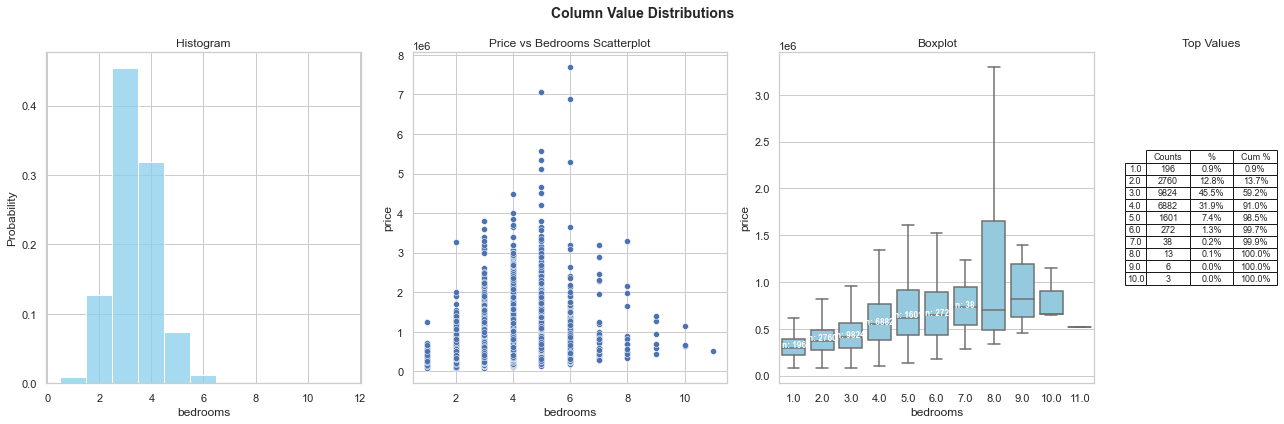

In [109]:
distplots(kc, 'bedrooms', 'price', 10)

**Notes on Bedrooms**
- One outlier at 33 BR excluded for graph presentability
- Mode is 3 BR and 78% are 3/4 BR. Only 1.5% higher than 5 BR and only 1% at 1 BR.
- Limiting to 1-6 BR looks relatively normal, might not need log transformation. This would mean dropping 0.3% of the data from modeling.
- Median price increases from 1-7 BRs, assume strong correlation. The IQR upper whisker increases more than lower whisker for higher bedrooms.

#### Bathrooms

/Users/cutterback/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Top 10 Counts By Bathrooms


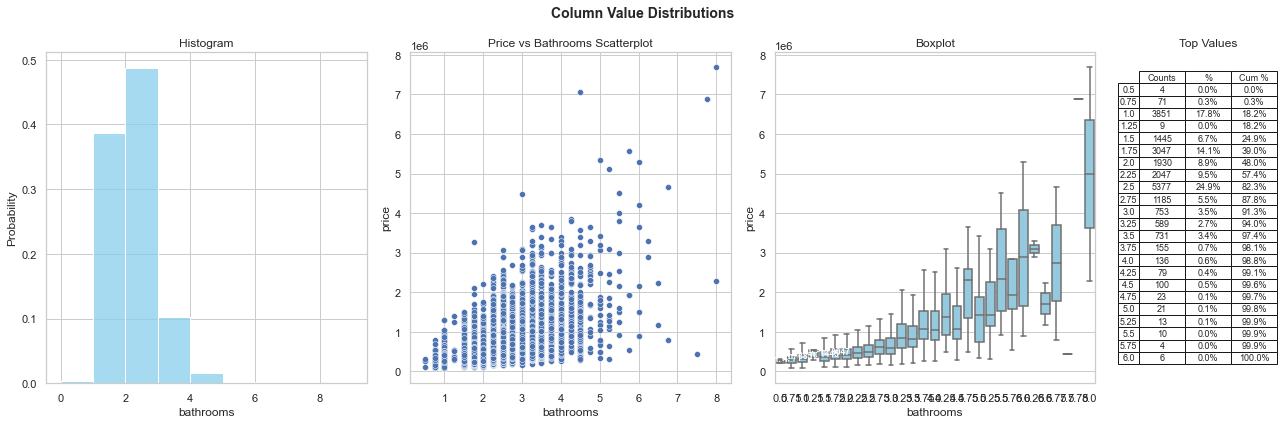

In [110]:
distplots(kc, 'bathrooms', 'price', 23)

**Notes on Bathrooms**
- Over 50% of homes have quarter or half bathrooms listed (.25, .5 or .75); Are half-baths worth 50% of a bath count in regression?
- Roughly 49% home have 2-3 baths, another 39% have 1-2 baths; 98% have 3 baths or under.
- Outliers: 75 homes (0.3%) have less than 1 bathroom. 12 homes have 6 or more. If bathrooms in model, might drop both outliers (1-6 baths).
- Distribution looks skewed right, might need log transformation.
- Median price increases with bathrooms, linear if not exponetially.

#### Floors

/Users/cutterback/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Top 10 Counts By Floors


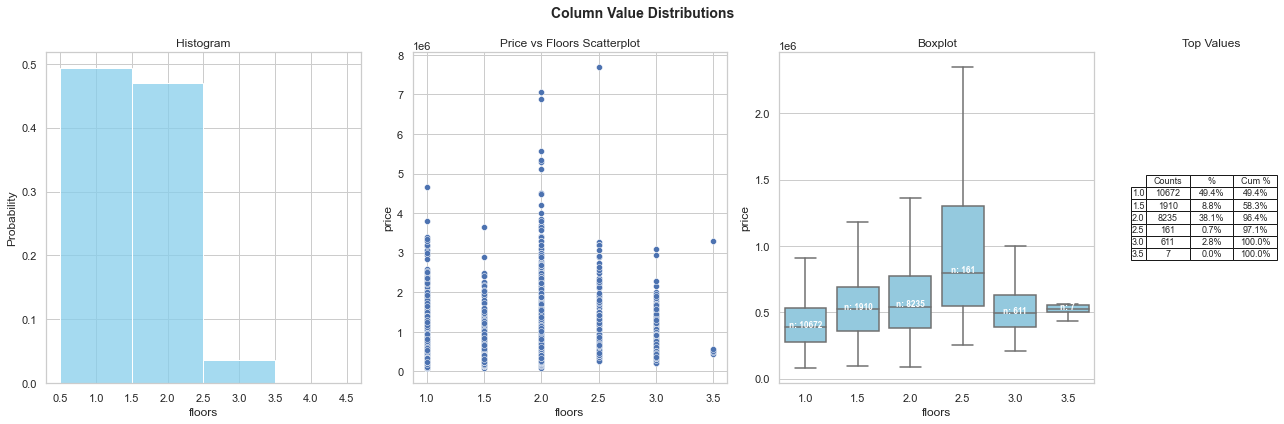

In [111]:
distplots(kc, 'floors', 'price', 10)

**Notes on Floors**
- Approximately 10% of homes have split-levels; Are half-floors worth 50% of a floor in regression?
- Roughly 49% home have single floor, another 38% have 2; Only 3% have 3 floors or higher (small samples and prices don't scale).
- Outliers: None
- Distribution not normal, would use category OHE variables.
- Median price and upper whisker band increases linearly with floors until 3+. Split level 1.5 similar to 2 floors in pricing.

#### Condition

/Users/cutterback/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Top 10 Counts By Condition


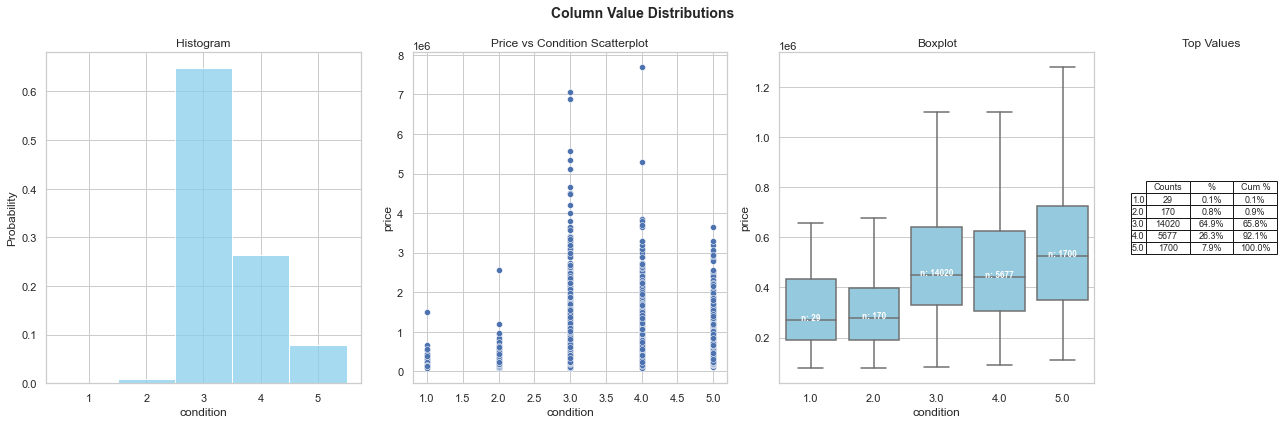

In [112]:
distplots(kc, 'condition', 'price', 5)

**Notes on Condition**
- From data dictionary: Score of 1/2 indicate major repairs required. Score 3 is average, with 4/5 be above average and exceptional.
- Roughly 2/3rd of homes are average (3), 1/4 are above average (4) and top 8% score excellent (5).
- Only 1% have 1/2 scores, probably due to market requirements to have a functional home to list for sale.
- Outliers: None denoted
- Distribution skewed left, candidate for category feature using OHE.
- Median price and IQR bands exhibit increasing step functions: 1/2 cluster-->3/4 cluster-->5

#### Grade

/Users/cutterback/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Top 10 Counts By Grade


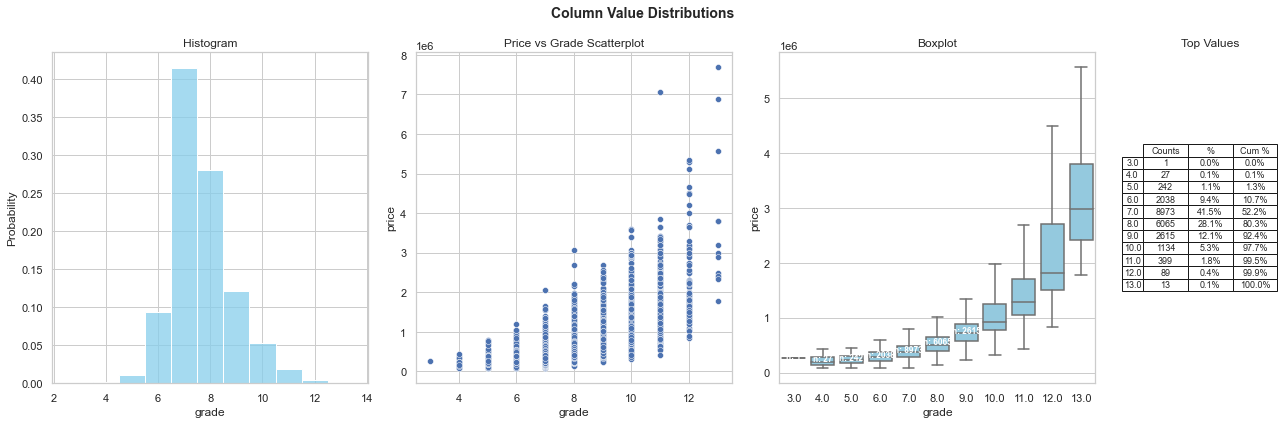

In [113]:
distplots(kc, 'grade', 'price', 13)

**Notes on Grade**
- From data dictionary: Range from 1-13 as an indication of quality level of building. 1-3 unfit, 13 mansion, 7 average.
- Roughly 41% of homes are average (7), another 37% at 6 or 8. Top 20% are 9+.
- Outliers: None denoted
- Distribution appears farily normal, candidate for continuous variable without log transformation.
- Median price and IQR bands exhibit exponetialality, pivoting at 9-13 markedly upwards.

#### Waterfront

/Users/cutterback/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Top 10 Counts By Waterfront


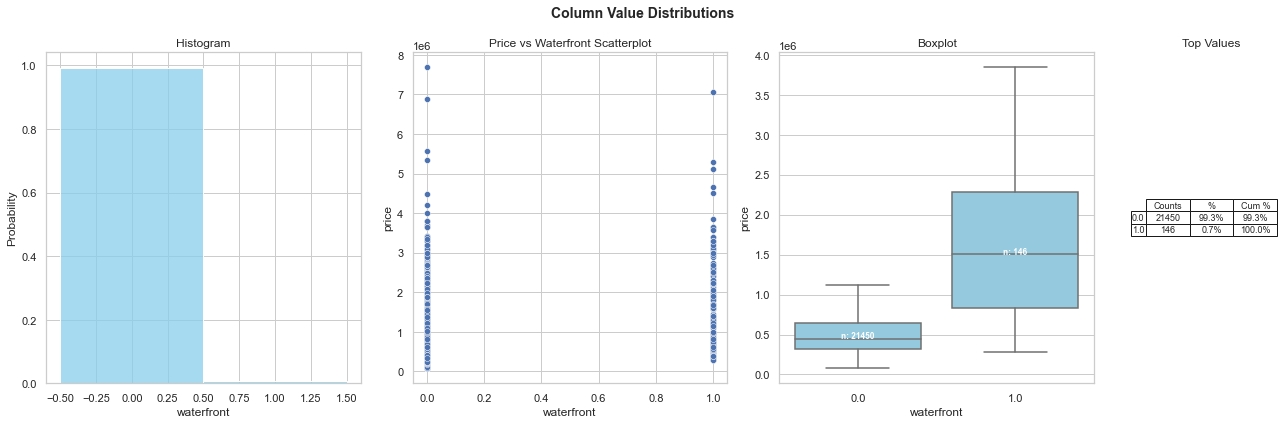

In [114]:
distplots(kc, 'waterfront', 'price', 10)

**Notes on Waterfront**
- Small sample of 146 but nearly triple the prices with high skew higher

#### Renovation Ind

/Users/cutterback/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Top 10 Counts By Renovation_Ind


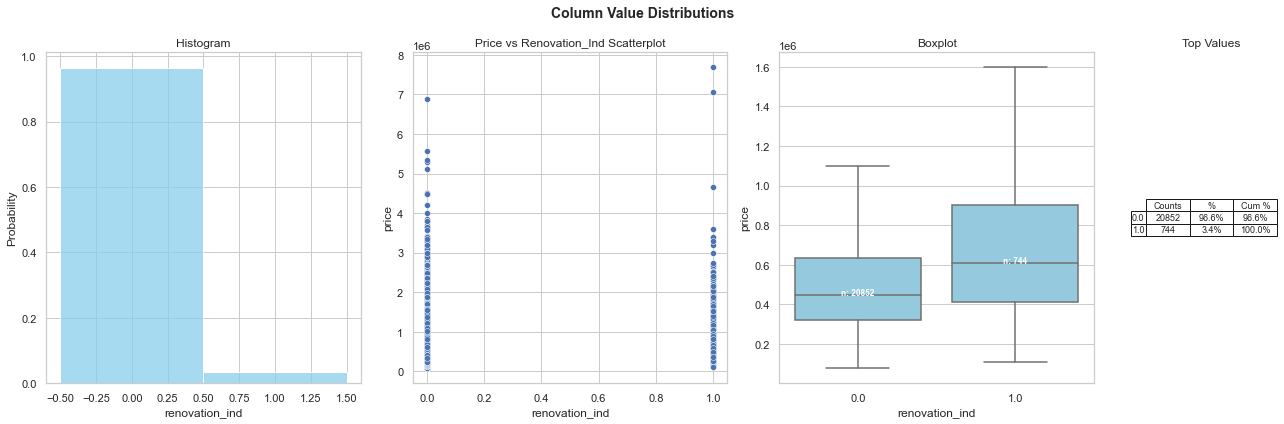

In [115]:
distplots(kc, 'renovation_ind', 'price', 10)

**Notes on Renovation Indicator**
- Small sample of 744 but median price is ~25% higher

#### View

/Users/cutterback/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Top 10 Counts By View


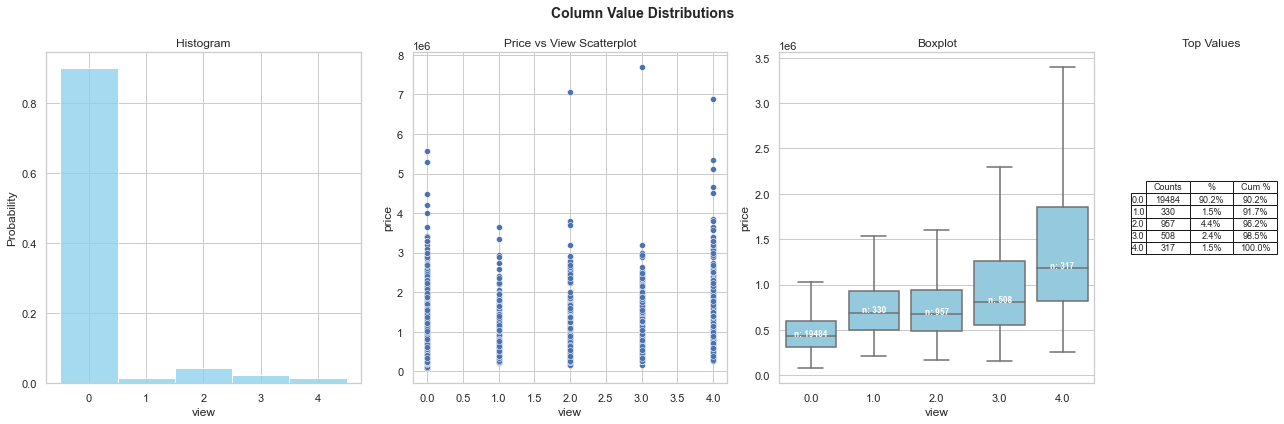

In [116]:
distplots(kc, 'view', 'price', 10)
plt.show()

**Notes on View**
- Only about 10% have a view value but median prices definitely get a lift, especially views 3/4

#### Zip

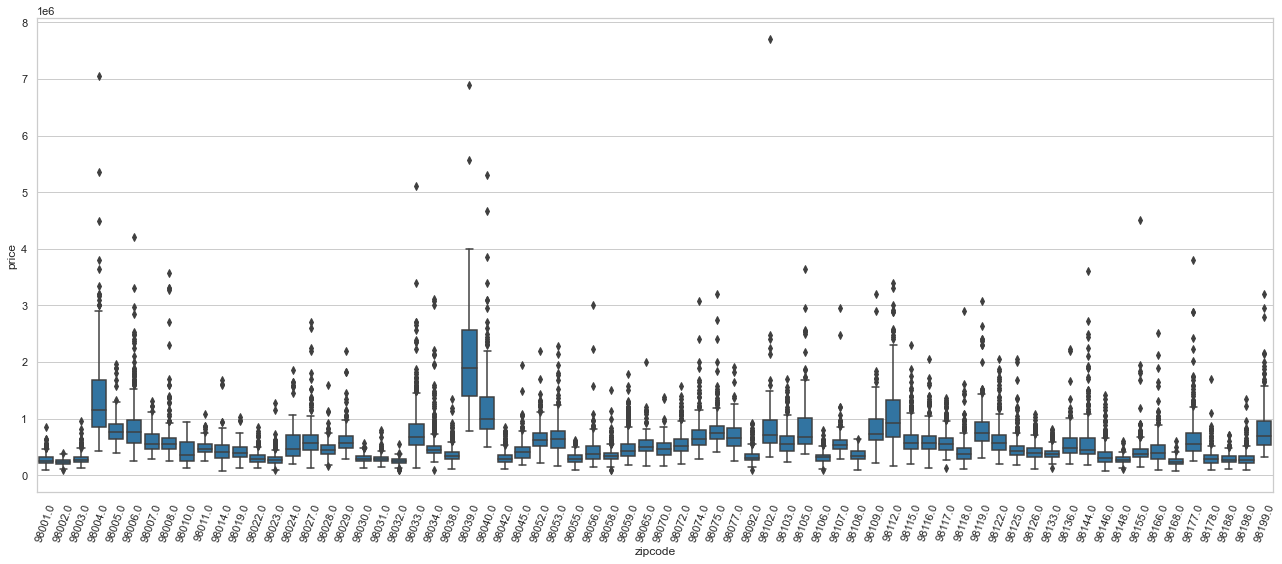

In [117]:
# boxplot showing distributions of sales price by zipcode
plt.figure(figsize=(18,8))
sns.boxplot(data=kc, x='zipcode', y='price', color='tab:blue')
plt.xticks(rotation=70)
plt.tight_layout()
plt.show()

**Notes on Zip**
- 70 distinct zip codes
- Zipcode definitely influence prices and price distributions
- Medians above \\$1M: 3 zips, Upper Whiskers above \\$1M: 8
- Outliers above \\$4M: 6 zips 

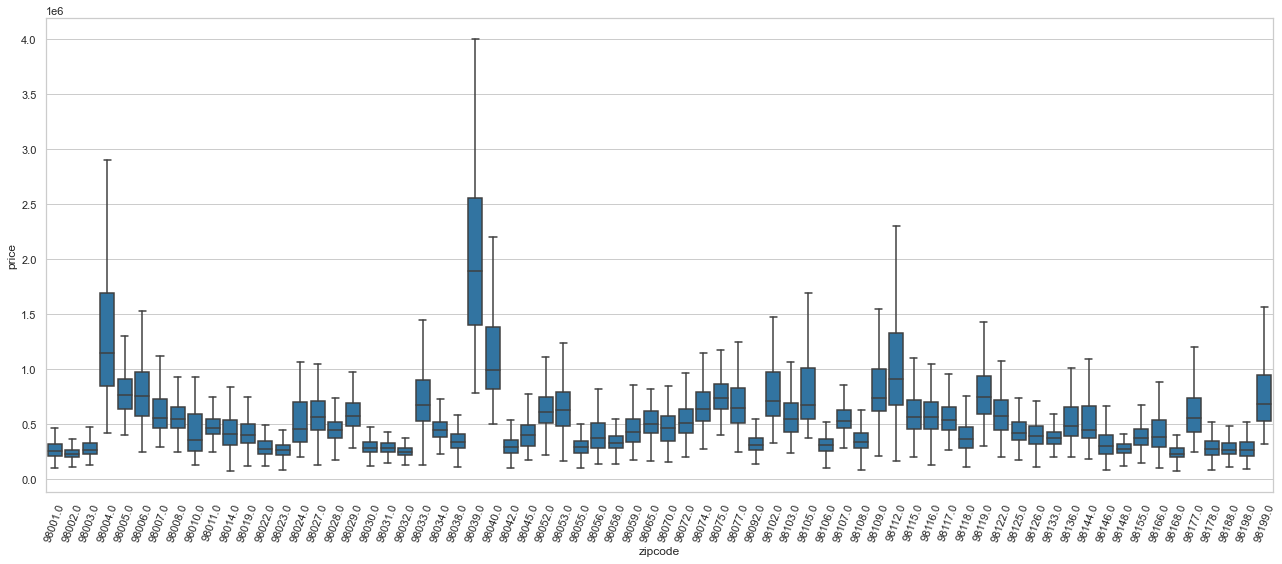

In [118]:
# Boxplot showing distributions of sales price by zipcode (no outliers shown)
plt.figure(figsize=(18,8))
sns.boxplot(data=kc, x='zipcode', y='price', color='tab:blue', showfliers=False)
plt.xticks(rotation=70)
plt.tight_layout()
plt.show()

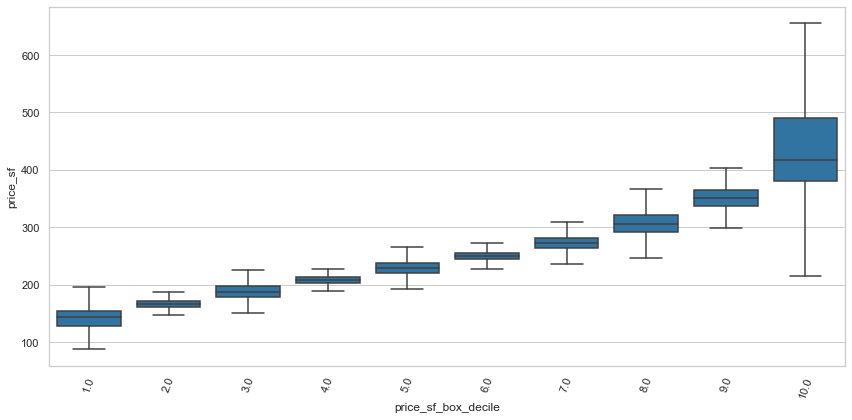

In [119]:
# boxplot showing distributions of sales price by zipcode (no outliers shown)
plt.figure(figsize=(12,6))
sns.boxplot(data=kc, x='price_sf_box_decile', y='price_sf', color='tab:blue', showfliers=False)
plt.xticks(rotation=70)
plt.tight_layout()
plt.show()

### Continuous Profiles

In [120]:
# columns on which to generate histograms to distribution exploration
pair_col1 = ['price', 'price_log', 'floors', 'bedrooms', 'bathrooms', 
             'waterfront', 'view', 'condition', 'grade', 'basement_ind',
             'yr_built', 'renovation_ind']
pair_col2 = ['price', 'price_log', 'sqft_living', 'sqft_living_log', 'sqft_lot', 
             'sqft_lot_log', 'sqft_above', 'sqft_basement', 'sqft_living15', 
             'sqft_lot15', 'sqft_lot15_log']
pair_col3 = ['price', 'price_log', 'miles_fr_seattle', 'miles_fr_seattle_log', 
             'miles_fr_seattle_sqrt']
pair_col4 = ['price', 'price_log', 'bedrooms', 'bathrooms', 'condition', 
             'grade','sqft_living','sqft_lot']

# function for scatterplot and diagonal histogram matrix for list of columns
def pairplot(df, column_list):
    sns.pairplot(df[column_list], kind='scatter', diag_kind='kde', 
                 height=1)
    sns.set(font_scale=0.6)
    plt.tight_layout()
    plt.show()

#### Pairgrid 1

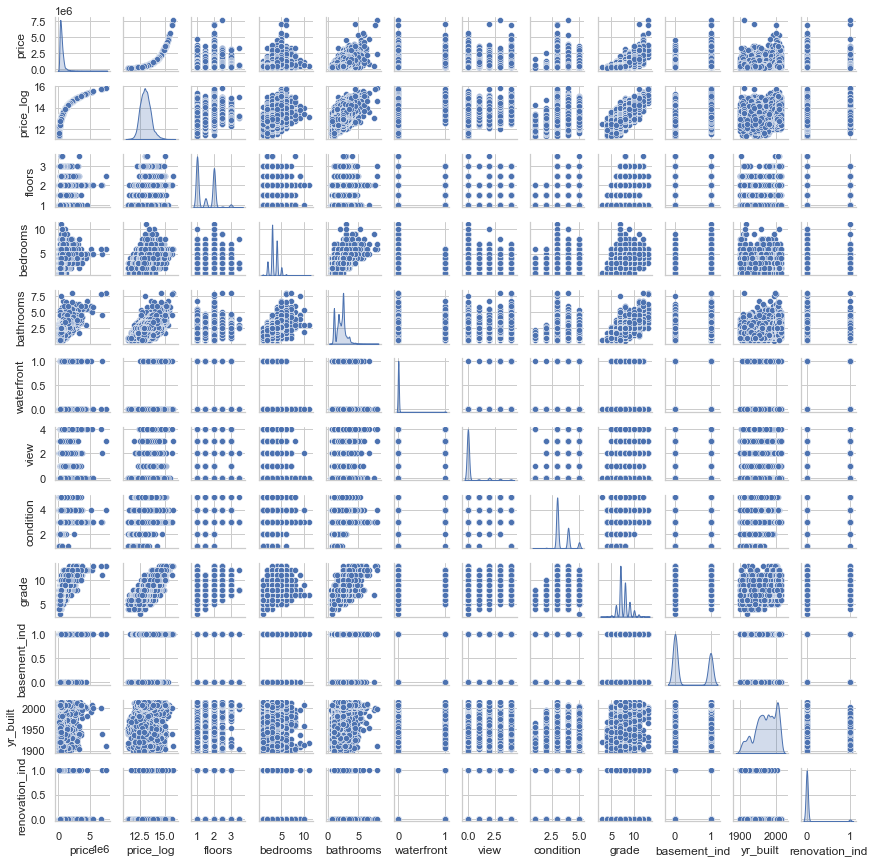

In [121]:
# plot the pairgrid for column set #1
pairplot(kc, pair_col1)

**Notes of Pairgrid 1**
- Linear with price: Grade, Condition, Bathrooms
- Inconclusive or non-linear with price: Year Built, Indicators, Bedrooms

#### Pairgrid 2

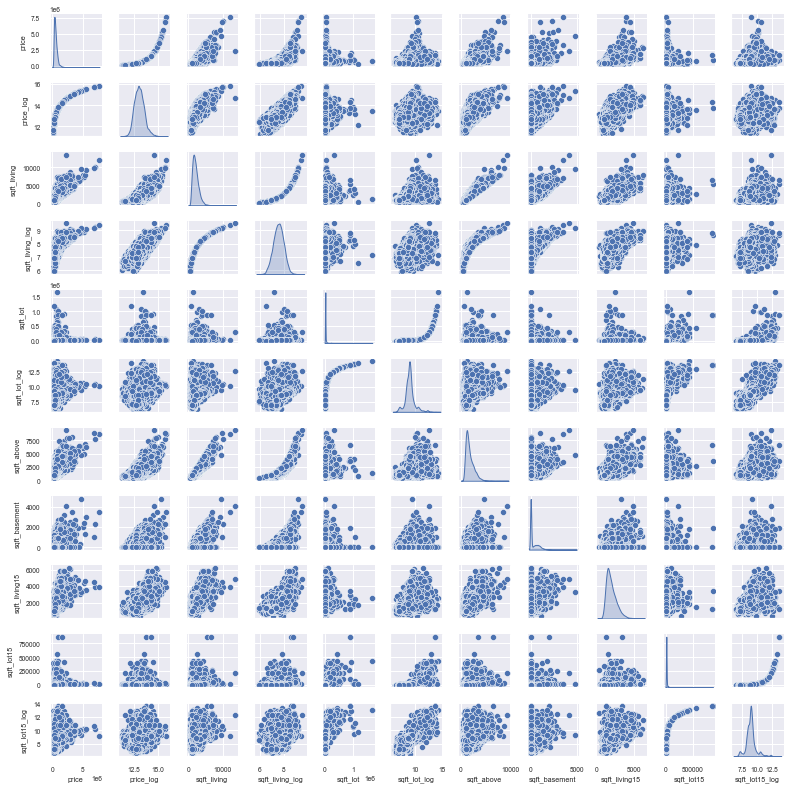

In [122]:
# plot the pairgrid for column set #2
pairplot(kc, pair_col2)

**Notes of Pairgrid 2**
- Linear with price: Sqft_living, sqft_above, sqft_living15
- sqft_living15 (nearest 15 neighbors) has linear relations to price, but also to sqft_living (with more spread). Check collinearity
- sqft_lot15 doesn't seem to matter much to price

#### Pairgrid 3

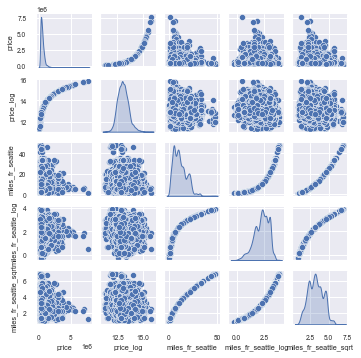

In [123]:
# plot the pairgrid for column set #3
pairplot(kc, pair_col3)

**Notes of Pairgrid 3**
- Miles from Seattle negative correlation to price (closer is higher priced)

# Predictive Models

This section contains model prep like correlations, checks for multicollinearity, one-hot-encoding features and creation of the test-trian splits for modeling. Then each model that I tried is included below starting with Model 1 and proceeding through Model 8. Within each model, the following steps are followed:

- Select model features and copy X/y dataset slices
- Run the OLS model with summaries for interpretation
- Review overal residuals with QQ-plot
- Review individual features for residuals and homeskedacity
- Check model's training data for kfolds cross-validation issues
- Run model to predict on test data and compare RMSE and MAE against training results 

## Model Preparation

### Correlations

In [124]:
# generate full correlation matrix
corr = kc.corr()
corr

price_sf_log          id       price   price_log  \
price_sf_log             1.00000000 -0.00295810  0.53215780  0.60890682   
id                      -0.00295810  1.00000000 -0.01676258 -0.00372960   
price                    0.53215780 -0.01676258  1.00000000  0.89174614   
price_log                0.60890682 -0.00372960  0.89174614  1.00000000   
price_box                0.46747296  0.00255221  0.63074742  0.74776730   
bedrooms                -0.21726525  0.00232775  0.31596053  0.35087137   
bedrooms_log            -0.24003565  0.00467756  0.29920654  0.34315520   
bedrooms_box            -0.16612332  0.00590519  0.22478078  0.25461109   
sqft_per_bedroom         0.01098328 -0.01201608  0.58023627  0.58382086   
sqft_per_bedroom_log    -0.01907184 -0.00656618  0.54212627  0.58640074   
bedroom_der             -0.22041398  0.00258507  0.31709130  0.35327199   
bathrooms               -0.08366482  0.00514521  0.52591525  0.55127040   
bathrooms_log           -0.12352406  0.01423784  0.45612727  0.52029238   
bathrooms_box           -0.07727252  0.01012130  0.37263909  0.40862041   
sqft_living             -0.09849961 -0.01225837  0.70192889  0.69520908   
sqft_living_log         -0.17449541 -0.00187756  0.61184636  0.67482039   
sqft_living_box         -0.11933913  0.00364300  0.45284853  0.50082955   
sqft_lot                -0.02786935 -0.13192016  0.08987924  0.10003188   
sqft_lot_log            -0.16589862 -0.14981417  0.16156579  0.13827133   
sqft_lot_box            -0.11990911 -0.10636059  0.09120132  0.06953369   
floors                   0.01942762  0.01857633  0.25682047  0.31066454   
waterfront               0.14298334 -0.00360231  0.26430781  0.17072384   
view                     0.19674106  0.01176172  0.39350202  0.34466506   
condition                0.10513931 -0.02372087  0.03603070  0.03885495   
grade                    0.14030613  0.00816891  0.66796382  0.70374741   
sqft_above              -0.09199345 -0.01083144  0.60539181  0.60162128   
sqft_above_log          -0.14779742 -0.00162608  0.54270342  0.58606238   
sqft_basement           -0.03070690 -0.00433599  0.32110304  0.31310625   
basement_ind             0.02788483  0.00353963  0.17825453  0.20907078   
yr_built                -0.26831311  0.02158922  0.05396453  0.08060828   
yr_renovated             0.09168748 -0.01061859  0.11785790  0.10687329   
renovation_ind           0.09148101 -0.01062807  0.11754576  0.10653426   
zipcode                  0.18698329 -0.00819454 -0.05340868 -0.03880143   
lat                      0.55710080 -0.00176562  0.30668729  0.44882367   
long                    -0.20854818  0.02064298  0.02204716  0.05088706   
miles_fr_seattle_log    -0.42970011 -0.01140202 -0.22103598 -0.26732172   
sqft_living15            0.03398163 -0.00273421  0.58526669  0.61937133   
sqft_lot15              -0.05194378 -0.13856988  0.08284895  0.09228997   
sqft_lot15_log          -0.16065524 -0.14759777  0.14792280  0.12373004   
miles_fr_seattle        -0.42375592  0.00034901 -0.21720796 -0.27086045   
miles_fr_seattle_sqrt   -0.43663646 -0.00486786 -0.22329525 -0.27403480   
price_sf                 0.96636714 -0.00520266  0.55606041  0.58335120   
price_sf_box             0.74728753 -0.00345884  0.38450953  0.46154812   
price_sf_box_decile      0.72134429  0.00109793  0.36546063  0.44760698   
zip_psf_median           0.76812044  0.00270170  0.53959749  0.63388287   
zip_psf_median_box       0.57306074  0.00490031  0.38661794  0.48473310   
sales_cnt                       nan         nan         nan         nan   

                        price_box    bedrooms  bedrooms_log  bedrooms_box  \
price_sf_log           0.46747296 -0.21726525   -0.24003565   -0.16612332   
id                     0.00255221  0.00232775    0.00467756    0.00590519   
price                  0.63074742  0.31596053    0.29920654    0.22478078   
price_log              0.74776730  0.35087137    0.34315520    0.25461109   
price_box              1.00000000  0.

In [125]:
# correlation matrix for just price
corr['price'].sort_values(ascending=False)

price                    1.00000000
price_log                0.89174614
sqft_living              0.70192889
grade                    0.66796382
price_box                0.63074742
sqft_living_log          0.61184636
sqft_above               0.60539181
sqft_living15            0.58526669
sqft_per_bedroom         0.58023627
price_sf                 0.55606041
sqft_above_log           0.54270342
sqft_per_bedroom_log     0.54212627
zip_psf_median           0.53959749
price_sf_log             0.53215780
bathrooms                0.52591525
bathrooms_log            0.45612727
sqft_living_box          0.45284853
view                     0.39350202
zip_psf_median_box       0.38661794
price_sf_box             0.38450953
bathrooms_box            0.37263909
price_sf_box_decile      0.36546063
sqft_basement            0.32110304
bedroom_der              0.31709130
bedrooms                 0.31596053
lat                      0.30668729
bedrooms_log             0.29920654
waterfront               0.2

In [126]:
# correlation matrix for just price_log
corr['price_log'].sort_values(ascending=False)

price_log                1.00000000
price                    0.89174614
price_box                0.74776730
grade                    0.70374741
sqft_living              0.69520908
sqft_living_log          0.67482039
zip_psf_median           0.63388287
sqft_living15            0.61937133
price_sf_log             0.60890682
sqft_above               0.60162128
sqft_per_bedroom_log     0.58640074
sqft_above_log           0.58606238
sqft_per_bedroom         0.58382086
price_sf                 0.58335120
bathrooms                0.55127040
bathrooms_log            0.52029238
sqft_living_box          0.50082955
zip_psf_median_box       0.48473310
price_sf_box             0.46154812
lat                      0.44882367
price_sf_box_decile      0.44760698
bathrooms_box            0.40862041
bedroom_der              0.35327199
bedrooms                 0.35087137
view                     0.34466506
bedrooms_log             0.34315520
sqft_basement            0.31310625
floors                   0.3

**Notes on Price Correlation**
- Strong correlations (0.6-0.8): sqft_living, grade, sqft_above, zip_psf_median, sqft_living15
- Moderate correlations (0.4-0.6): bathrooms, view

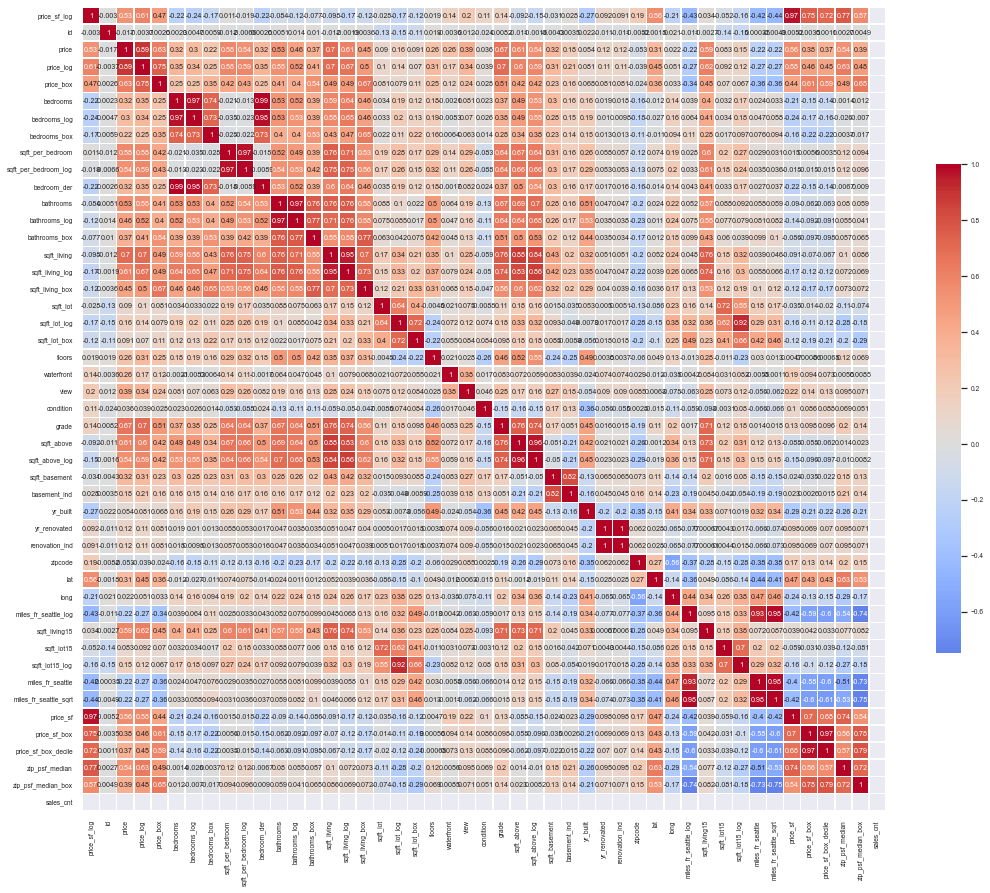

In [127]:
# show heatmap for correlation matrix
f, ax = plt.subplots(figsize=(18,15))
sns.heatmap(corr, center=0, linewidths=0.4, cmap='coolwarm', square=True, annot=True, cbar_kws={'shrink': 0.6})
plt.tight_layout
plt.show()

### Multi-Colinearity

In [128]:
# check for collinearity among potential predictors by pairs
df = (
     corr
     .stack()
     .reset_index()
     .sort_values(0, ascending=False)
)
# zip the default name columns level_0 and level_1
df['pairs'] = list(zip(df.level_0, df.level_1))
# set index to pairs
df.set_index(['pairs'], inplace=True)
# now drop level columns
df.drop(columns=['level_1', 'level_0'], inplace=True)
# rename correlation column rather than 0
df.columns = ['correlation']
# drop duplicates and keep only pair correlations above 0.65
df.drop_duplicates(inplace=True)
df[abs(df.correlation) > .65]

correlation
pairs                                                     
(price_sf_log, price_sf_log)                    1.00000000
(renovation_ind, yr_renovated)                  0.99996841
(bedroom_der, bedrooms)                         0.99396185
(miles_fr_seattle_sqrt, miles_fr_seattle)       0.98467891
(miles_fr_seattle_sqrt, miles_fr_seattle_log)   0.98040861
(bedrooms_log, bedroom_der)                     0.97580536
(bedrooms, bedrooms_log)                        0.97160436
(bathrooms, bathrooms_log)                      0.97055737
(sqft_per_bedroom, sqft_per_bedroom_log)        0.96976949
(price_sf_box, price_sf_box_decile)             0.96714552
(price_sf, price_sf_log)                        0.96636714
(sqft_above, sqft_above_log)                    0.96254543
(sqft_living_log, sqft_living)                  0.95460697
(miles_fr_seattle, miles_fr_seattle_log)        0.93255457
(sqft_lot_log, sqft_lot15_log)                  0.91866584
(price, price_log)                              0.89174614
(sqft_living, sqft_above)                       0.87644846
(sqft_living_log, sqft_above_log)               0.86498579
(sqft_living, sqft_above_log)                   0.84313513
(sqft_living_log, sqft_above)                   0.83238269
(basement_ind, sqft_basement)                   0.82089238
(zip_psf_median_box, price_sf_box_decile)       0.79255854
(zip_psf_median_box, price_sf_box)              0.78045527
(bathrooms_log, bathrooms_box)                  0.77114637
(price_sf_log, zip_psf_median)                  0.76812044
(sqft_living_box, bathrooms_box)                0.76717302
(sqft_living, grade)                            0.76277602
(bathrooms, sqft_living_log)                    0.76213328
(bathrooms_box, bathrooms)                      0.76192869
(sqft_living_log, bathrooms_log)                0.76076251
(sqft_living15, sqft_living)                    0.75639976
(grade, sqft_above)                             0.75606891
(bathrooms, sqft_living)                        0.75575491
(sqft_living, sqft_per_bedroom)                 0.75546250
(price_box, price_log)                          0.74776730
(price_sf_log, price_sf_box)                    0.74728753
(sqft_living, sqft_per_bedroom_log)             0.74600386
(sqft_living_log, sqft_per_bedroom_log)         0.74564765
(sqft_living_log, grade)                        0.74303590
(grade, sqft_above_log)                         0.74286650
(zip_psf_median, price_sf)                      0.74227920
(sqft_living_log, sqft_living15)                0.73721674
(bedrooms, bedrooms_box)                        0.73518375
(bedrooms_box, bedroom_der)                     0.73386390
(sqft_living_box, sqft_living_log)              0.73270973
(sqft_living15, sqft_above)                     0.73175609
(bedrooms_box, bedrooms_log)                    0.73174077
(price_sf_box_decile, price_sf_log)             0.72134429
(zip_psf_median, zip_psf_median_box)            0.72113931
(sqft_lot15, sqft_lot)                          0.71820328
(sqft_lot_box, sqft_lot_log)                    0.71792015
(sqft_living15, sqft_above_log)                 0.71498680
(sqft_per_bedroom, sqft_living_log)             0.71448384
(sqft_living15, grade)                          0.71386261
(bathrooms_log, sqft_living)                    0.70815482
(price_log, grade)                              0.70374741
(price_sf, price_sf_box)                        0.70300032
(price, sqft_living)                            0.70192889
(sqft_lot15, sqft_lot15_log)                    0.70152241
(sqft_living, sqft_living_box)                  0.69716341
(bathrooms, sqft_above_log)                     0.69583764
(sqft_living, price_log)                        0.69520908
(sqft_above, bathrooms)                         0.68666447
(bathrooms_log, sqft_above_log)                 0.68389312
(price_sf, price_sf_box_decile)                 0.67555712
(price_log, sqft_living_log)                    0.67482039
(sqft_above, sqft_per_bedroom)     

**Notes on multi-colinearity**
- Ignore logs of columns compared to source column.
- Probably don't need sqft_living and sqft_above (0.88) as highly duplicatative.
- sqft_living and grade at 0.76 leave in for now (grade should be independent of sqft)
- sqft_living and bathrooms at 0.76 leave in for now (common knowledge pricing is set by # bathrooms somewhat independent of sqft?)
- Bathrooms and grade at 0.67, leave for now perhaps look at interaction term.

### One-hot encoding

In [129]:
# Convert category variables data type
categoricals= ['zipcode','grade_grp']
kc['zipcode']=kc['zipcode'].astype(int).astype('category')
# kc[categoricals] = kc[categoricals].astype('category')

In [130]:
# create one-hot encoded variables for categoricals
kc_ohe = pd.get_dummies(kc[categoricals], drop_first=True)
kc_ohe.head()

zipcode_98002  zipcode_98003  zipcode_98004  zipcode_98005  zipcode_98006  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   
3              0              0              0              0              0   
4              0              0              0              0              0   

   zipcode_98007  zipcode_98008  zipcode_98010  zipcode_98011  zipcode_98014  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   
3              0              0              0              0              0   
4              0              0              0              0              0   

   zipcode_98019  zipcode_98022  zipcode_98023  zipcode_98024  zipcode_98027  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   
3              0              0              0              0              0   
4              0              0              0              0              0   

   zipcode_98028  zipcode_98029  zipcode_98030  zipcode_98031  zipcode_98032  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              1              0              0              0              0   
3              0              0              0              0              0   
4              0              0              0              0              0   

   zipcode_98033  zipcode_98034  zipcode_98038  zipcode_98039  zipcode_98040  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   
3              0              0              0              0              0   
4              0              0              0              0              0   

   zipcode_98042  zipcode_98045  zipcode_98052  zipcode_98053  zipcode_98055  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   
3              0              0              0              0              0   
4              0              0              0              0              0   

   zipcode_98056  zipcode_98058  zipcode_98059  zipcode_98065  zipcode_98070  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   
3              0              0              0              0              0   
4              0              0              0              0              0   

   zipcode_98072  zipcode_98074  zipcode_98075  zipcode_98077  zipcode_98092  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   
3              0              0              0              0              0   
4              0              1              0              0              0   

   zipcode_98102  zipcode_98103  zipcode_98105  zipcode_98106  zipcode_98107  \
0              0              0              0              0              

In [131]:
kc.tail()

price_sf_log                     id       date            price  \
21592    5.46083630   263,000,018.00000000 2014-05-21 360,000.00000000   
21593    5.15421702 6,600,060,120.00000000 2015-02-23 400,000.00000000   
21594    5.97690067 1,523,300,141.00000000 2014-06-23 402,101.00000000   
21595    5.52146092   291,310,100.00000000 2015-01-16 400,000.00000000   
21596    5.76402256 1,523,300,157.00000000 2014-10-15 325,000.00000000   

        price_log  price_box   bedrooms  bedrooms_log  bedrooms_box  \
21592 12.79385931 4.03319976 3.00000000    1.09861229    2.13756008   
21593 12.89921983 4.03344865 4.00000000    1.38629436    0.85488198   
21594 12.90445858 4.03319976 2.00000000    0.69314718    1.54151148   
21595 12.89921983 4.02308293 3.00000000    1.09861229    0.85488198   
21596 12.69158046 4.03872181 2.00000000    0.69314718    1.54151148   

       sqft_per_bedroom  sqft_per_bedroom_log  bedroom_der  bathrooms  \
21592      510.00000000            6.23441073   3.00000000 2.50000000   
21593      577.50000000            6.35870844   4.00000000 2.50000000   
21594      510.00000000            6.23441073   2.00000000 0.75000000   
21595      533.33333333            6.27914662   3.00000000 2.50000000   
21596      510.00000000            6.23441073   2.00000000 0.75000000   

       bathrooms_log  bathrooms_box    sqft_living  sqft_living_log  \
21592     0.91629073     1.18233024 1,530.00000000       7.33302301   
21593     0.91629073    -0.26665138 2,310.00000000       7.74500280   
21594    -0.28768207     1.18233024 1,020.00000000       6.92755791   
21595     0.91629073    -0.26665138 1,600.00000000       7.37775891   
21596    -0.28768207     1.01512581 1,020.00000000       6.92755791   

       sqft_living_box       sqft_lot  sqft_lot_log  sqft_lot_box     floors  \
21592       8.45124244 1,131.00000000    7.03085748    4.20913332 3.00000000   
21593       7.48908158 5,813.00000000    8.66785207    3.89251821 2.00000000   
21594       8.01682138 1,350.00000000    7.20785987    4.02691439 2.00000000   
21595       7.48908158 2,388.00000000    7.77821147    3.83481334 2.00000000   
21596       8.22587403 1,076.00000000    6.98100574    4.25860061 2.00000000   

       waterfront       view  condition      grade      grade_grp  \
21592  0.00000000 0.00000000 3.00000000 8.00000000  gr2_above_avg   
21593  0.00000000 0.00000000 3.00000000 8.00000000  gr2_above_avg   
21594  0.00000000 0.00000000 3.00000000 7.00000000        gr0_avg   
21595  0.00000000 0.00000000 3.00000000 8.00000000  gr2_above_avg   
21596  0.00000000 0.00000000 3.00000000 7.00000000        gr0_avg   

          sqft_above  sqft_above_log  sqft_basement  basement_ind  \
21592 1,530.00000000      7.33302301     0.00000000    0.00000000   
21593 2,310.00000000      7.74500280     0.00000000    0.00000000   
21594 1,020.00000000      6.92755791     0.00000000    0.00000000   
21595 1,600.00000000      7.37775891     0.00000000    0.00000000   
21596 1,020.00000000      6.92755791     0.00000000    0.00000000   

            yr_built  yr_renovated  renovation_ind zipcode         lat  \
21592 2,009.00000000    0.00000000      0.00000000   98103 47.69930000   
21593 2,014.00000000    0.00000000      0.00000000   98146 47.51070000   
21594 2,009.00000000    0.00000000      0.00000000   98144 47.59440000   
21595 2,004.00000000    0.00000000      0.00000000   98027 47.53450000   
21596 2,008.00000000    0.00000000      0.00000000   98144 47.59410000   

               long                   home_lat_long  miles_fr_seattle_log  \
21592 -122.34600000             (47.6993, -122.346)            1.92265595   
21593 -122.36200000  (47.5107, -122.36200000000001)            0.65737438   
21594 -122.29900000  (47.5944, -122.29899999999999)            2.59576844   
21595 -122.06900000             (47.5345, -122.069)            0.66264194   
21596 -122.29900000  (47.5941, -122.29899999999999)            2.33441902   

       sqft_living15     sqft_lot15  sqft_lot15_lo

In [132]:
# concatenate OHE columns with original dataframe, and drop some some columns not needed
kc_comb = pd.concat([kc, kc_ohe], axis=1)
kc_comb.drop(['id','date','lat','long','home_lat_long'], axis=1, inplace=True)
kc_comb.head()

price_sf_log            price   price_log  price_box   bedrooms  \
0    5.23671239 221,900.00000000 12.30998211 4.00314587 3.00000000   
1    5.34395266 538,000.00000000 13.19561384 4.04680802 3.00000000   
2    5.45432162 180,000.00000000 12.10071213 3.99142502 2.00000000   
3    5.73062972 604,000.00000000 13.31132948 4.05186762 4.00000000   
4    5.71561693 510,000.00000000 13.14216600 4.04442395 3.00000000   

   bedrooms_log  bedrooms_box  sqft_per_bedroom  sqft_per_bedroom_log  \
0    1.09861229    1.54151148      393.33333333            5.97465743   
1    1.09861229    1.54151148      856.66666667            6.75304889   
2    0.69314718    0.85488198      385.00000000            5.95324333   
3    1.38629436    2.13756008      490.00000000            6.19440539   
4    1.09861229    1.54151148      560.00000000            6.32793678   

   bedroom_der  bathrooms  bathrooms_log  bathrooms_box    sqft_living  \
0   3.00000000 1.00000000     0.00000000     0.00000000 1,180.00000000   
1   3.00000000 2.25000000     0.81093022     1.01512581 2,570.00000000   
2   2.00000000 1.00000000     0.00000000     0.00000000   770.00000000   
3   4.00000000 3.00000000     1.09861229     1.49488011 1,960.00000000   
4   3.00000000 2.00000000     0.69314718     0.83902461 1,680.00000000   

   sqft_living_log  sqft_living_box        sqft_lot  sqft_lot_log  \
0       7.07326972       7.65931218  5,650.00000000    8.63941082   
1       7.85166118       8.57807664  7,242.00000000    8.88765269   
2       6.64639051       7.16215595 10,000.00000000    9.21034037   
3       7.58069975       8.25644647  5,000.00000000    8.51719319   
4       7.42654907       8.07433240  8,080.00000000    8.99714715   

   sqft_lot_box     floors  waterfront       view  condition      grade  \
0    4.20377896 1.00000000  0.00000000 0.00000000 3.00000000 7.00000000   
1    4.24953666 2.00000000  0.00000000 0.00000000 3.00000000 7.00000000   
2    4.30583245 1.00000000  0.00000000 0.00000000 3.00000000 6.00000000   
3    4.18043282 1.00000000  0.00000000 0.00000000 5.00000000 7.00000000   
4    4.26903318 1.00000000  0.00000000 0.00000000 3.00000000 8.00000000   

       grade_grp     sqft_above  sqft_above_log  sqft_basement  basement_ind  \
0        gr0_avg 1,180.00000000      7.07326972     0.00000000    0.00000000   
1        gr0_avg 2,170.00000000      7.68248245   400.00000000    1.00000000   
2      gr1_below   770.00000000      6.64639051     0.00000000    0.00000000   
3        gr0_avg 1,050.00000000      6.95654544   910.00000000    1.00000000   
4  gr2_above_avg 1,680.00000000      7.42654907     0.00000000    0.00000000   

        yr_built   yr_renovated  renovation_ind zipcode  miles_fr_seattle_log  \
0 1,955.00000000     0.00000000      0.00000000   98178            2.03046029   
1 1,951.00000000 1,991.00000000      1.00000000   98125            2.05959866   
2 1,933.00000000     0.00000000      0.00000000   98028            2.31800767   
3 1,965.00000000     0.00000000      0.00000000   98136            1.88730642   
4 1,987.00000000     0.00000000      0.00000000   98074            2.60485433   

   sqft_living15     sqft_lot15  sqft_lot15_log  miles_fr_seattle  \
0 1,340.00000000 5,650.00000000      8.63941082        7.61759185   
1 1,690.00000000 7,639.00000000      8.94102198        7.84282157   
2 2,720.00000000 8,062.00000000      8.99491694       10.15542122   
3 1,360.00000000 5,000.00000000      8.51719319        6.60156288   
4 1,800.00000000 7,503.00000000      8.92305822       13.52925438   

   miles_fr_seattle_sqrt     price_sf  price_sf_box  price_sf_box_decile  \
0             2.75999852 188.05084746    2.15349572           3.00000000   
1             2.80050381 209.33852140    2.16574291           4.00000000   
2             3.18675716 233.76623377    2.17779734           5.00000000   
3             2.56935067 308.16326531    2.20568742           8.00000000   
4             3.67821348 303.57142857    2.20425188           8.00000

### Train-Test Split

In [133]:
# divide dataset into X predictors and y target
X = kc_comb.drop(['price', 'price_log', 'price_box'], axis=1)
y = kc_comb[['price', 'price_log', 'price_box']]

In [134]:
# split data 80% training and 20% test w/ random state for reproducability
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42)

In [135]:
# validate rows in splits look as expected
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((17276, 115), (4320, 115), (17276, 3), (4320, 3))

In [136]:
# last check for any nans
X_train[X_train.isna().any(axis=1)]
X_test[X_test.isna().any(axis=1)]
y_train[y_train.isna().any(axis=1)]
y_test[y_test.isna().any(axis=1)]

Empty DataFrame
Columns: [price, price_log, price_box]
Index: []

In [137]:
# full list of available columns to choose features for this model
print(X_train.columns.tolist())

['price_sf_log', 'bedrooms', 'bedrooms_log', 'bedrooms_box', 'sqft_per_bedroom', 'sqft_per_bedroom_log', 'bedroom_der', 'bathrooms', 'bathrooms_log', 'bathrooms_box', 'sqft_living', 'sqft_living_log', 'sqft_living_box', 'sqft_lot', 'sqft_lot_log', 'sqft_lot_box', 'floors', 'waterfront', 'view', 'condition', 'grade', 'grade_grp', 'sqft_above', 'sqft_above_log', 'sqft_basement', 'basement_ind', 'yr_built', 'yr_renovated', 'renovation_ind', 'zipcode', 'miles_fr_seattle_log', 'sqft_living15', 'sqft_lot15', 'sqft_lot15_log', 'miles_fr_seattle', 'miles_fr_seattle_sqrt', 'price_sf', 'price_sf_box', 'price_sf_box_decile', 'zip_psf_median', 'zip_psf_median_box', 'sales_cnt', 'year_month', 'zipcode_98002', 'zipcode_98003', 'zipcode_98004', 'zipcode_98005', 'zipcode_98006', 'zipcode_98007', 'zipcode_98008', 'zipcode_98010', 'zipcode_98011', 'zipcode_98014', 'zipcode_98019', 'zipcode_98022', 'zipcode_98023', 'zipcode_98024', 'zipcode_98027', 'zipcode_98028', 'zipcode_98029', 'zipcode_98030', 'zipc

## Functions

### calc_sm_ols

In [138]:
# function takes X and y dataframes and generates statsmodel OLS results
def calc_sm_ols(model_nbr, X, y):
    """Runs and returns statsmodel Ordinary Least Squares (OLS) regression model.
       Takes in X predictors and y target, generates model, predictions and 
       performance stats.
    
        Parameters:
        model_nbr (int): sequence number you've created for model iteration
        X (pd.DataFrame): train or test slice contains predictors
        y (pd.DataFrame)): train or test slice contains target

        Returns:
        model (linear_model): statsmodel fitted OLS model object
        rsq_adj (float): model adjusted r-squared
        rmse (float): model root mean squared error
        mae (float): models mean absolute error
   """
    
    model = sm.OLS(y, X).fit()
    print(model.summary())
    
    # generate model predictions and calculate errors 
    y_pred = model.predict(X)
    if y.name == 'price' :
        rmse = round(ev.rmse(y, y_pred))
        mae = round(ev.meanabs(y, y_pred))
        print(f'\nModel {model_nbr} Summary Statistics')
        print(f'Root Mean Squared Error (RMSE): {rmse}.')
        print(f'Mean Absolute Error (MAE): {mae}.')
    elif y.name == 'price_log' :
        rmse = round(ev.rmse(np.exp(y), np.exp(y_pred)))
        mae = round(ev.meanabs(np.exp(y), np.exp(y_pred)))
        mae_log = ev.meanabs(y, y_pred)
        print(f'\nModel {model_nbr} Summary Statistics')
        print(f'Root Mean Squared Error (RMSE): {rmse}.')
        print(f'Mean Absolute Error (MAE): {mae} | Log y: {mae_log}')
    else :
        print(f'Cannot calculate RMSE and MAE from y variable {y}')
    rsq_adj = model.rsquared_adj                 
    return model, rsq_adj, rmse, mae

### qqplot

In [139]:
# function to generate QQ-plot for an OLS model
def qqplot(model_nbr, model):
    """Displays a QQ-plot for a statsmodel OLS object to inspect
       normality of model residual errors.
    
        Parameters:
        model_nbr (int): sequence number you've created for model iteration
        model (linear_model): statsmodel fitted OLS model object

        Returns: no return
   """
        
    # generate QQ-plot
    residuals = model.resid
    sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
    plt.title(f'\nModel {model_nbr} QQ-plot' )
    plt.tight_layout()
    plt.show()

### plot_residuals

In [140]:
# function to generate residuals for each independent variable in an OLS model
def plot_residuals(model_nbr, model):
    """Displays sequential residual plots for each predictor (X) in a statsmodel OLS object for 
       testing normality of model residuals on specific features.
    
        Parameters:
        model_nbr (int): sequence number you've created for model iteration
        model (linear_model): statsmodel fitted OLS model object

        Returns: no return
   """    
    
    # loop through variables to show residuals for each
    x_vars = model.params.keys().tolist()
    x_vars.remove('const')

    for x in x_vars:
        f = plt.figure(figsize=(15,8))
        f = sm.graphics.plot_regress_exog(model, x, fig=f)   
        f.tight_layout()
        plt.show()

# review in future iteration Checking Heteroscadasticity (Goldfeld-Quandt test)

### normalize

In [141]:
# normalize a feature (subract mean and divide by std)
def normalize(feature):
    return (feature - feature.mean()) / feature.std()

#denormalize (add mean and multiple by std)
def denormalize(feature, log_df):
    return log_df['price_log'].std()*feature + log_df['price_log'].mean()

### kfolds

In [142]:
# function using K-folds cross-validation to validate OLS model
def kfolds(X, y, cv=5):
    """Performs cross-validation using cv number of folds against full 
       sample X and y. Prints out CV mean absolute errors for comparison 
       to OLS model MAE. Supplemental validation to OLS train-test split.
    
        Parameters:
        X (pd.DataFrame): full sample contains model predictors
        y (pd.DataFrame)): full sample contains model target

        Returns: no return
   """
    
    model = LinearRegression()
    model.fit(X, y)
    mae = make_scorer(mean_absolute_error)
    cv_5_results = cross_val_score(model, X, y, cv=cv, scoring=mae)
    print(f'Cross-Validation MAE results: {cv_5_results} | CV MAE Mean: {cv_5_results.mean()}')

### predict

In [143]:
# function predicts y_pred using model, compares rmse / mae between training and test
def predict(model_nbr, model, X_train, X_test, y_train, y_test):
    """Generates predictions, prints comparison stats for train and test dataframes.
       Works for price and price_log targets. For price_log, calculates RMSE and MAE
       by transforming back to price.
    
        Parameters:
        model_nbr (int): sequence number you've created for model iteration
        model (linear_model): statsmodel fitted OLS model object
        X_train (pd.DataFrame): train slice contains predictors
        X_test (pd.DataFrame): test slice contains predictors
        y_train (pd.DataFrame): train slice contains target
        y_test (pd.DataFrame): test slice contains target

        Returns: 
        y_pred_train (float): train set predictions
        y_pred_test (float): test set predictions
   """   
    
    # Calculate predictions on training and test sets
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    if y_train.name == 'price':
        rmse_train = round(ev.rmse(y_train, y_pred_train))
        mae_train = round(ev.meanabs(y_train, y_pred_train))
        rmse_test = round(ev.rmse(y_test, y_pred_test))
        mae_test = round(ev.meanabs(y_test, y_pred_test))       
        
    elif y_train.name == 'price_log':
        rmse_train = round(ev.rmse(np.exp(y_train), np.exp(y_pred_train)))
        mae_train = round(ev.meanabs(np.exp(y_train), np.exp(y_pred_train)))
        rmse_test = round(ev.rmse(np.exp(y_test), np.exp(y_pred_test)))
        mae_test = round(ev.meanabs(np.exp(y_test), np.exp(y_pred_test)))
    else :
        print(f'Cannot calculate RMSE and MAE from y variable {y_train.name}')
                     
    print(f'\nModel {model_nbr} Prediction Statistics\n--------------------------')
    print(f'Root Mean Squared Error (RMSE): Test {rmse_test} | Train {rmse_train} | \
          Difference {rmse_test-rmse_train} | % Diff {(rmse_test-rmse_train)/rmse_train}')
    print(f'Mean Absolute Error (MAE): Test {mae_test} | Train {mae_train} | \
          Difference {mae_test-mae_train} | % Diff {(mae_test-mae_train)/mae_train}')
    
    return y_pred_train, y_pred_test

## Model 1:  Naive Start (Abandon)

### Features

**Model 1 Approach**
- This model is a baseline model that we'll build on in future iterations with more complexity and features
- Model 1 will start without use of log columns and solve for price using top correlated columns
- Columns to try include all high (sqft_living, grade, sqft_above) and medium correlations (sqft_living15, bathrooms, view)
- Model 1 will not incorporate much colinearity concerns to start, let's just see what we get

In [144]:
# model 1 setup and call statsmodel function
features_m1 = ['sqft_living', 'sqft_above', 'sqft_living15', 'bathrooms', 'view', 'grade']

# apply features to X_train and chose which y to predict
X_train_m1 = sm.add_constant(X_train[features_m1])
y_train_m1 = y_train['price']

# apply features to X_test and chose which y to predict
X_test_m1 = sm.add_constant(X_test[features_m1])
y_test_m1 = y_test['price']

# quick check of rows
X_train_m1.head()

const    sqft_living     sqft_above  sqft_living15  bathrooms  \
6243  1.00000000 1,440.00000000 1,440.00000000 1,300.00000000 2.00000000   
8986  1.00000000 1,430.00000000 1,140.00000000 1,310.00000000 1.75000000   
9419  1.00000000 3,120.00000000 3,120.00000000 3,200.00000000 2.75000000   
10155 1.00000000 2,060.00000000 1,220.00000000 1,760.00000000 2.50000000   
10436 1.00000000 2,500.00000000 1,680.00000000 1,550.00000000 2.00000000   

            view      grade  
6243  0.00000000 7.00000000  
8986  2.00000000 7.00000000  
9419  0.00000000 9.00000000  
10155 0.00000000 7.00000000  
10436 0.00000000 7.00000000

### Run OLS

In [145]:
# run the model iteration and store in model variable
model_1, rsq_adj_m1, rmse_m1, mae_m1 = calc_sm_ols(model_nbr=1, X=X_train_m1, y=y_train_m1)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.577
Model:                            OLS   Adj. R-squared:                  0.577
Method:                 Least Squares   F-statistic:                     3921.
Date:                Fri, 02 Apr 2021   Prob (F-statistic):               0.00
Time:                        11:43:45   Log-Likelihood:            -2.3853e+05
No. Observations:               17276   AIC:                         4.771e+05
Df Residuals:                   17269   BIC:                         4.771e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -5.949e+05   1.49e+04    -40.034

**Model 1 Summary Interpretation**
- Adj r^2 = 0.577 | would be good start if all else checks
- P-value = 0.00 | would be good if all else checks
- Skew = 3 (tgt ~0), Kurtosis = 35 (tgt 3), JB = 764K (tgt 0-6) | Indicates major non-normality, not good
- Cond. No. 30K | indicates strong multicollinearity (ill-conditioned)
- Predictors:
    - Intercept: negative intercept
    - Sqft_Living: \\$211/sqft average doesn't see unreasonable for Seattle area, low p-value 0.00
    - Sqft_above: negative coefficient of \\$51 doesn't make sense. Somethings off with variable ranges or multicollinearity
    - Bathrooms: negative coefficient of \\$2K doesn't make sense.
    - View: p-value of 0.00. This feature seems to make sense adding \\$90K for a home with a view.
- Net/net: Move on from this, need to get a better base model without these issues.

### QQ-plot

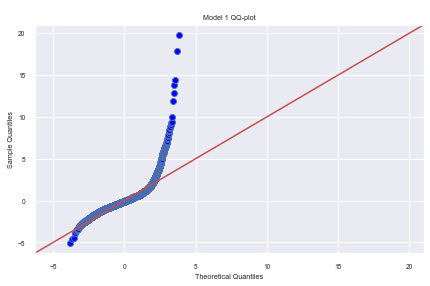

In [146]:
# plot the overall residuals via QQ-plot
qqplot(model_nbr=1, model=model_1)

**QQ-Plot Interpretation**
- This is WAY off, showing major outliers on both ends. Back to the drawing board.

### Plot Residuals

**Notes on Residuals**

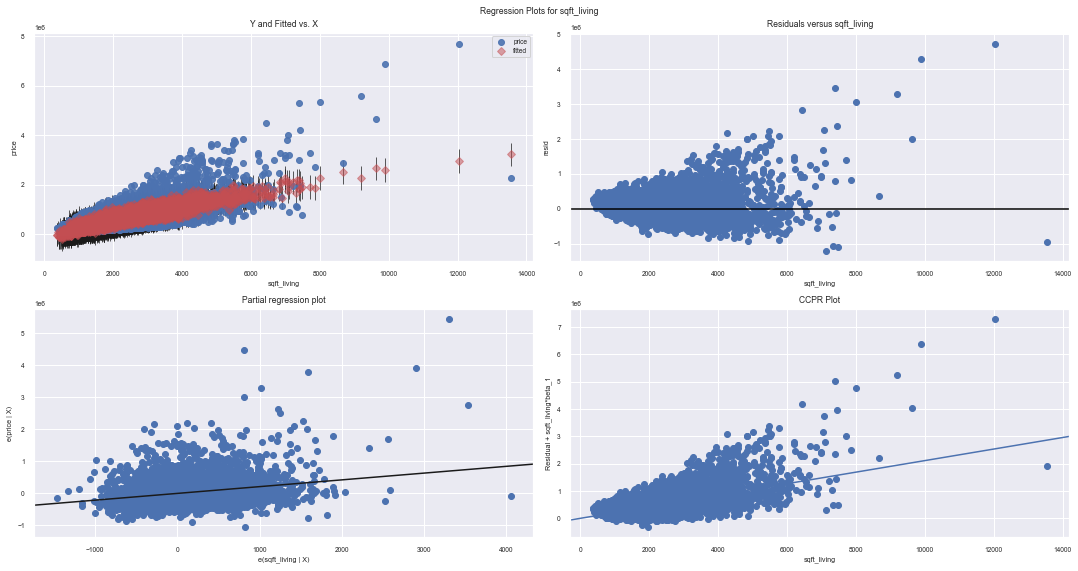

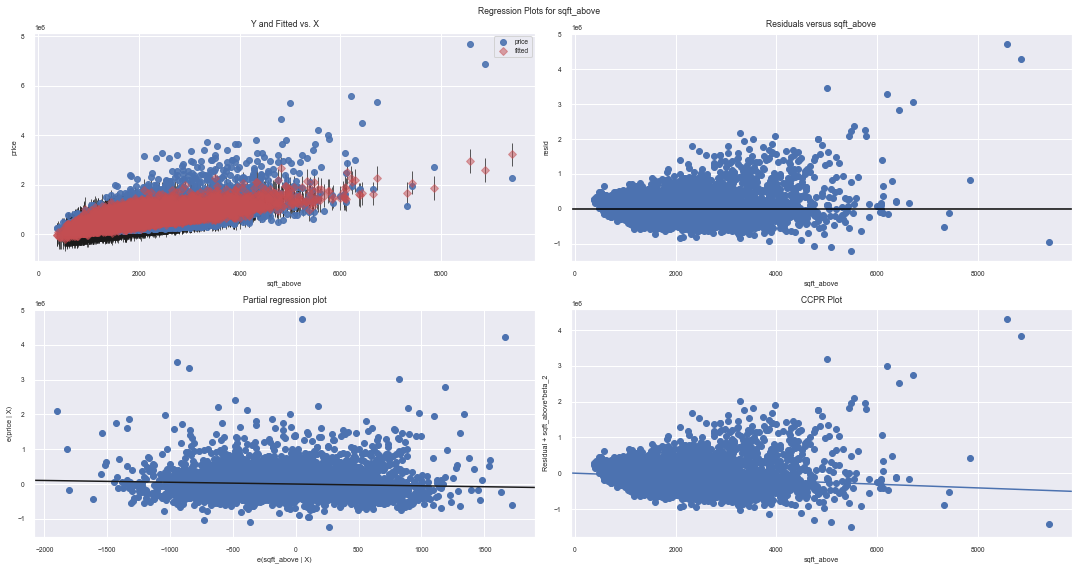

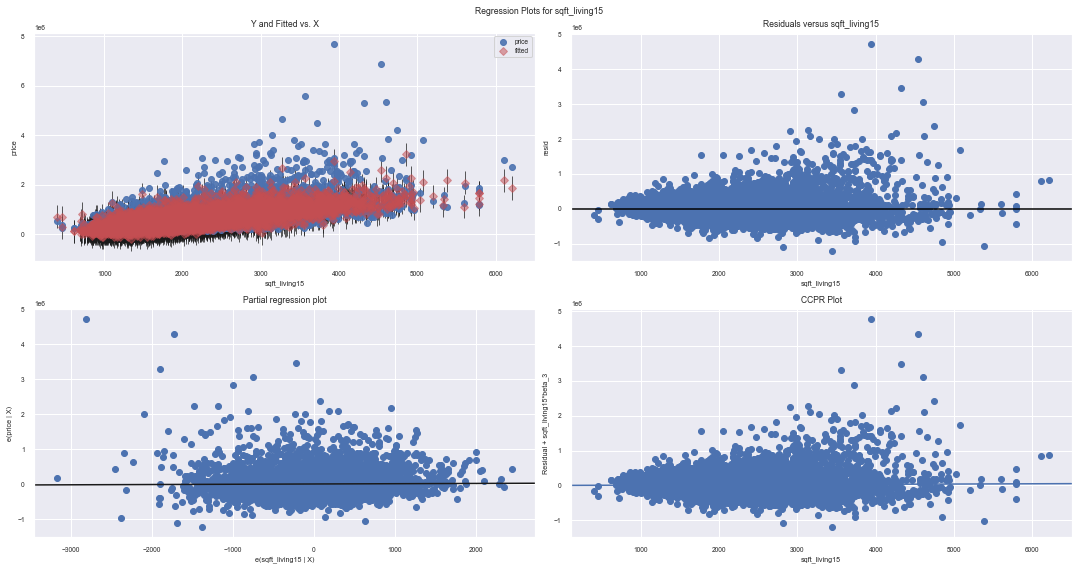

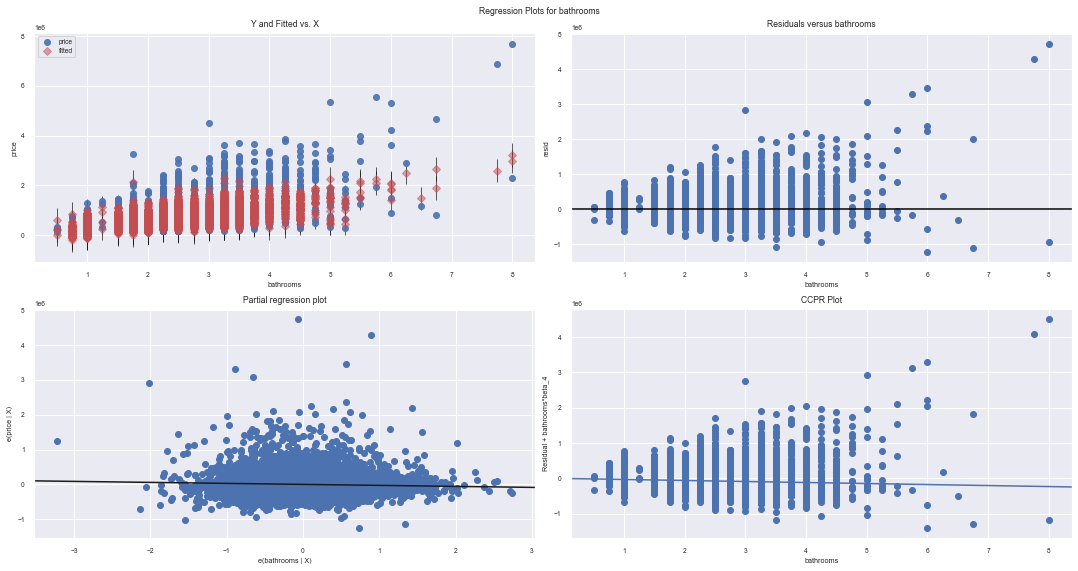

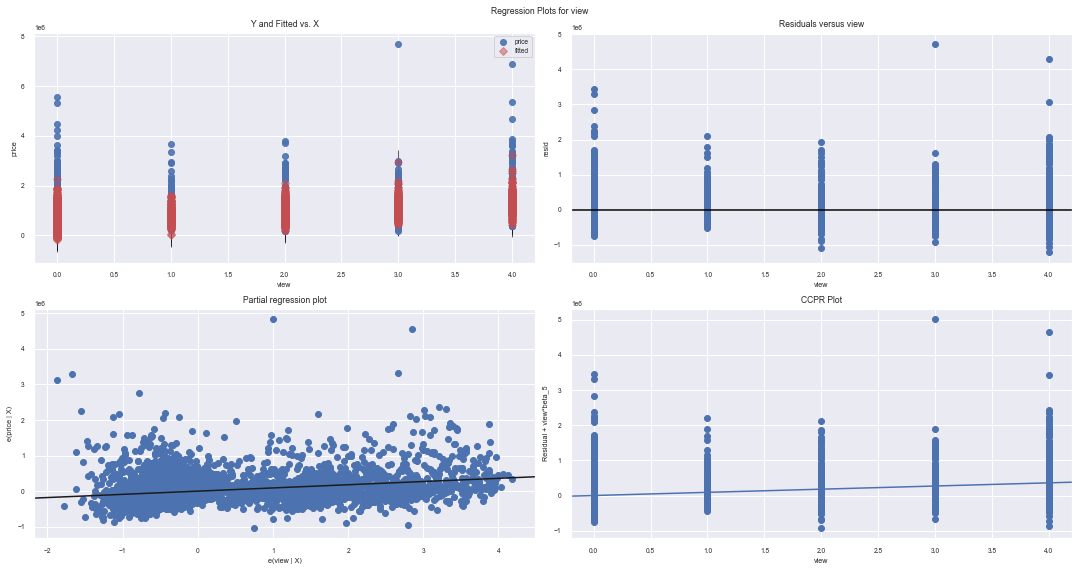

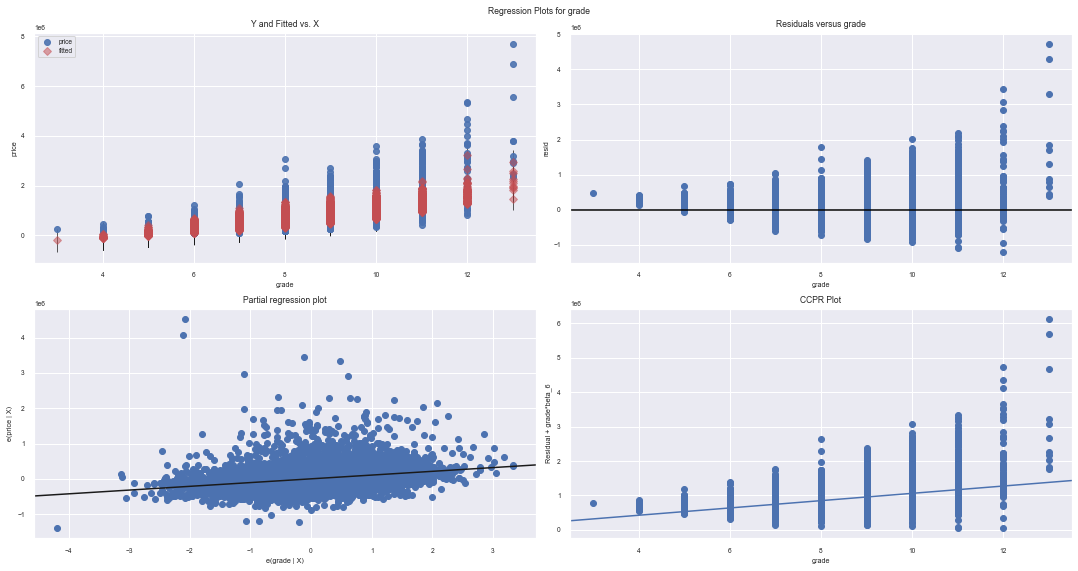

In [147]:
# plot feature residuals and check for homoskedacity
plot_residuals(model_nbr=1, model=model_1)

### K-folds

In [148]:
# cross validation to compare MAE on entire sample for m1 features
X_CV_m1 = X[features_m1]
y_CV_m1 = y['price']

kfolds(X_CV_m1, y_CV_m1, cv=5)

Cross-Validation MAE results: [158703.9082036  156381.58157917 153770.28214012 156600.97428371
 157512.44774119] | CV MAE Mean: 156593.83878956022


### Model 1 Prediction

In [149]:
y_pred_train_m1, y_pred_test_m1 = predict(1, model_1, X_train_m1, X_test_m1, y_train_m1, y_test_m1)


Model 1 Prediction Statistics
--------------------------
Root Mean Squared Error (RMSE): Test 237278.0 | Train 239891.0 |           Difference -2613.0 | % Diff -0.01089244698633963
Mean Absolute Error (MAE): Test 154921.0 | Train 156717.0 |           Difference -1796.0 | % Diff -0.011460147909926811


**Model 1 Conclusion**
- Move on to fix these problems

## Model 2: Price Log + 3 Features (Rank #4)

### Features

**Model 2 Approach**
- Goal for this model is to get a simple baseline model without major issues to build upon
- Shifting (y) from price to price_log given the negative skew
- Starting with 3 continuous variables that had highest correlations: grade, view and sqft_living_log (given skew)

In [150]:
# model 2 Setup and call statsmodel function
features_m2 = ['sqft_living_log', 'grade', 'view']

# apply features to X_train and chose which y to predict
X_train_m2 = sm.add_constant(X_train[features_m2])
y_train_m2 = y_train['price_log']

# apply features to X_test and chose which y to predict
X_test_m2 = sm.add_constant(X_test[features_m2])
y_test_m2 = y_test['price_log']

# quick check of rows
X_train_m2.head()

const  sqft_living_log      grade       view
6243  1.00000000       7.27239839 7.00000000 0.00000000
8986  1.00000000       7.26542972 7.00000000 2.00000000
9419  1.00000000       8.04558828 9.00000000 0.00000000
10155 1.00000000       7.63046126 7.00000000 0.00000000
10436 1.00000000       7.82404601 7.00000000 0.00000000

### Run OLS

In [151]:
# run the model iteration and store in model variable
model_2, rsq_adj_m2, rmse_m2, mae_m2 = calc_sm_ols(model_nbr=2, X=X_train_m2, y=y_train_m2)

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     7678.
Date:                Fri, 02 Apr 2021   Prob (F-statistic):               0.00
Time:                        11:44:07   Log-Likelihood:                -6145.2
No. Observations:               17276   AIC:                         1.230e+04
Df Residuals:                   17272   BIC:                         1.233e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               8.5512      0.054    1

**Model 2 Summary Interpretation**
- Adj r^2 = 0.571 | ok to start with if all else checks
- P-value = 0.00 | would be good if all else checks
- Skew = 0.1 (tgt ~0), Kurtosis = 2.8 (tgt 3), JB = 42 (tgt 0-6) | these look great
- Cond. No. 227 | well-conditioned
- Predictors:
    - Coefficients: y is price_log as one dependent variable sqft_living is log
    - All features have p-values of 0.0000 so significant
    - MAE is \\$147K
- This can be initial baseline model

### QQ-plot

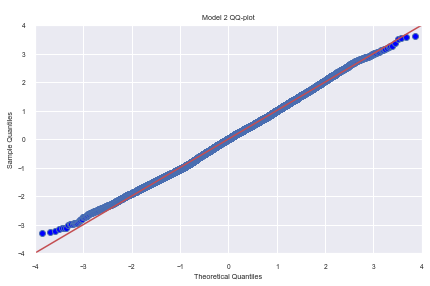

In [152]:
qqplot(model_nbr=2, model=model_2)

**QQ-Plot Interpretation**
- This QQ looks pretty good, with slight divergence at both tails only. Acceptable.

### Plot Residuals

**Notes on Residuals**
- Residual plots below do not show much pattern for 3 features; concluding each is homoskedastic

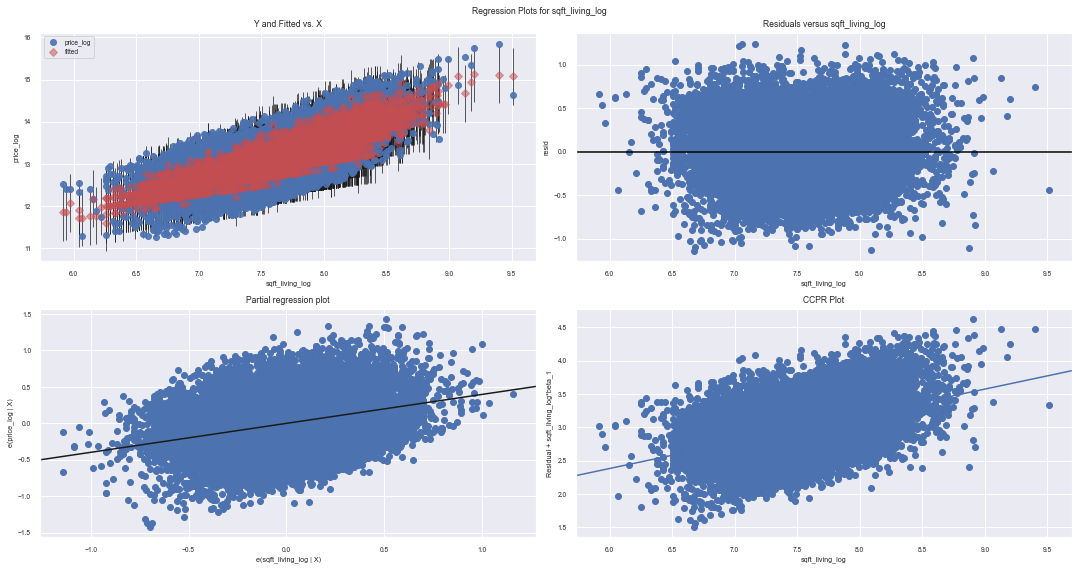

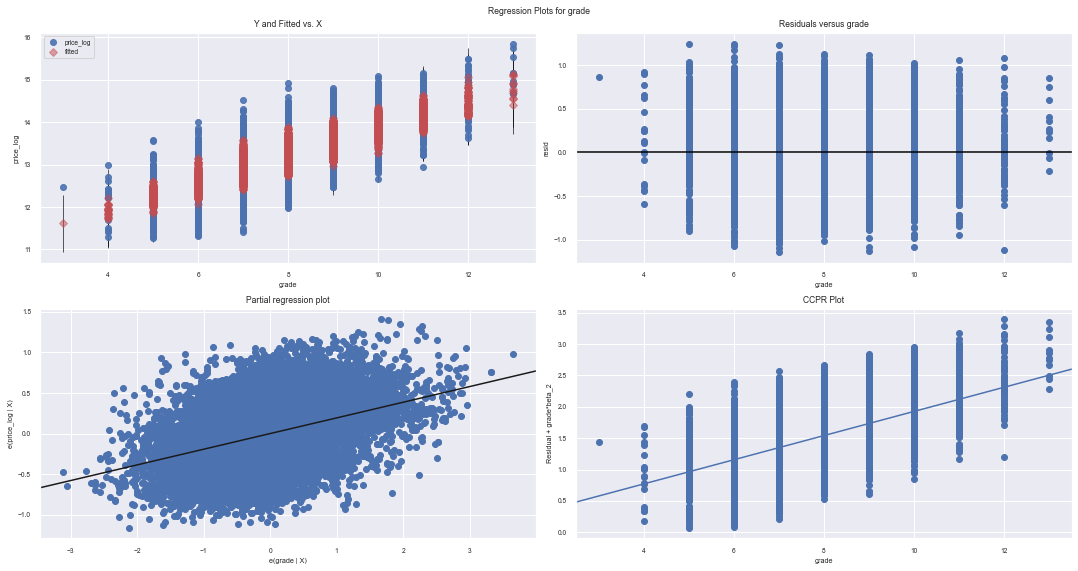

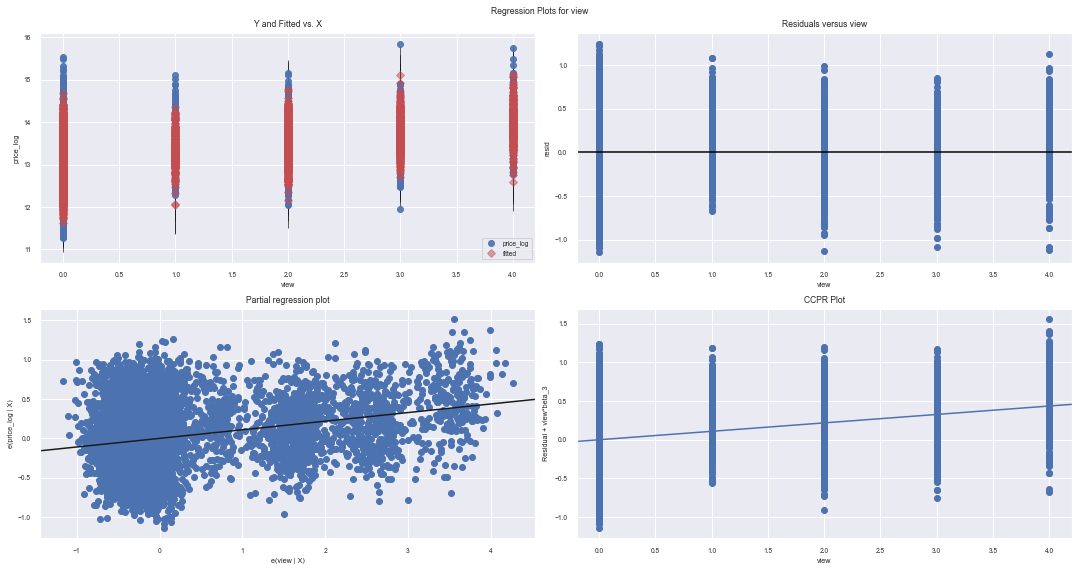

In [153]:
# plot feature residuals and check for homoskedacity
plot_residuals(model_nbr=2, model=model_2)

### K-folds

In [154]:
# cross validation to compare MAE on entire sample for m2 features
X_CV_m2 = X[features_m2]
y_CV_m2 = y['price_log']

kfolds(X_CV_m2, y_CV_m2, cv=5)

Cross-Validation MAE results: [0.28493316 0.28016789 0.28157809 0.28150706 0.25904354] | CV MAE Mean: 0.27744594759085456


### Model 2 Prediction

In [155]:
y_pred_train_m2, y_pred_test_m2 = predict(2, model_2, X_train_m2, X_test_m2, y_train_m2, y_test_m2)


Model 2 Prediction Statistics
--------------------------
Root Mean Squared Error (RMSE): Test 229834.0 | Train 233813.0 |           Difference -3979.0 | % Diff -0.01701787325768884
Mean Absolute Error (MAE): Test 144730.0 | Train 146914.0 |           Difference -2184.0 | % Diff -0.01486583987911295


**Model 2 Conclusion**
- These 3 features look good as a baseline with a MAE of \\$145K on test, only \\$2K different than training.

## Model 3: m2 + SqFt Above Log (Abandon)

### Features

**Model 3 Approach**
- Start with model 2 features using price_log
- Trying to make sqft_above work, one of the highest correlation
- First try sqft_above, improves model very slightly r2 +0.001 and MAE +\\$383 but warning on multicollinearity; residuals cone-shaped
- Next try sqft_above_log, improves model slightly r2 +0.004, MAE +||$1229 but negative coefficent and warning on multicol.
- Next try sqft_above_log with interaction term with sqft_living_box: causes both terms to flip negative coefficient
- Concluding not going to inclucde sqft_above in model at this point. Model is not good.

In [156]:
# model 3 setup and call statsmodel function
features_m3 = ['sqft_living_log', 'grade', 'view', 'sqft_above_log']

# apply features to X_train and chose which y to predict
X_train_m3 = sm.add_constant(X_train[features_m3])
X_train_m3['sqft_living_above_int'] = X_train_m3['sqft_living_log']*X_train_m3['sqft_above_log'] # add interaction term
y_train_m3 = y_train['price_log']

# apply features to X_test and chose which y to predict
X_test_m3 = sm.add_constant(X_test[features_m3])
X_test_m3['sqft_living_above_int'] = X_test_m3['sqft_living_log']*X_test_m3['sqft_above_log']
y_test_m3 = y_test['price_log']

# quick check of rows
X_train_m3.head()

const  sqft_living_log      grade       view  sqft_above_log  \
6243  1.00000000       7.27239839 7.00000000 0.00000000      7.27239839   
8986  1.00000000       7.26542972 7.00000000 2.00000000      7.03878354   
9419  1.00000000       8.04558828 9.00000000 0.00000000      8.04558828   
10155 1.00000000       7.63046126 7.00000000 0.00000000      7.10660614   
10436 1.00000000       7.82404601 7.00000000 0.00000000      7.42654907   

       sqft_living_above_int  
6243             52.88777838  
8986             51.13978716  
9419             64.73149078  
10155            54.22668284  
10436            58.10566164

### Run OLS

In [157]:
# run the model iteration and store in model variable
model_3, rsq_adj_m3, rmse_m3, mae_m3 = calc_sm_ols(model_nbr=3, X=X_train_m3, y=y_train_m3)

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.582
Method:                 Least Squares   F-statistic:                     4819.
Date:                Fri, 02 Apr 2021   Prob (F-statistic):               0.00
Time:                        11:44:29   Log-Likelihood:                -5919.6
No. Observations:               17276   AIC:                         1.185e+04
Df Residuals:                   17270   BIC:                         1.190e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    19.39

**Model 3 Summary Interpretation**
- Adj r^2 = 0.583 | dropped slighly from Model 2
- P-value = 0.00 | would be good if all else checks
- Skew = 0.1 (tgt ~0), Kurtosis = 2.9 (tgt 3), JB = 18 (tgt 0-6) | these look great, similar to model 2
- Cond. No. 15K | indicates strong multicollinearity (ill-conditioned) with warning
- Predictors: intercept jumped extremely high with negative coefficients on sqft_living_log and sqft_above_log. Even with interaction term, was unable to get sqft_above to work in this model

### QQ-plot

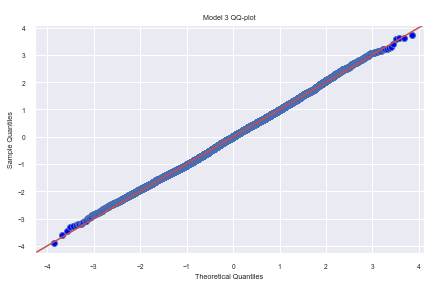

In [158]:
# plot the overall residuals via QQ-plot
qqplot(model_nbr=3, model=model_3)

**QQ-Plot Interpretation**
- QQ-plot looks great, very normalish

### Plot Residuals

**Notes on Residuals**
- Not finding major issues with residuals for sqft_above_log. 

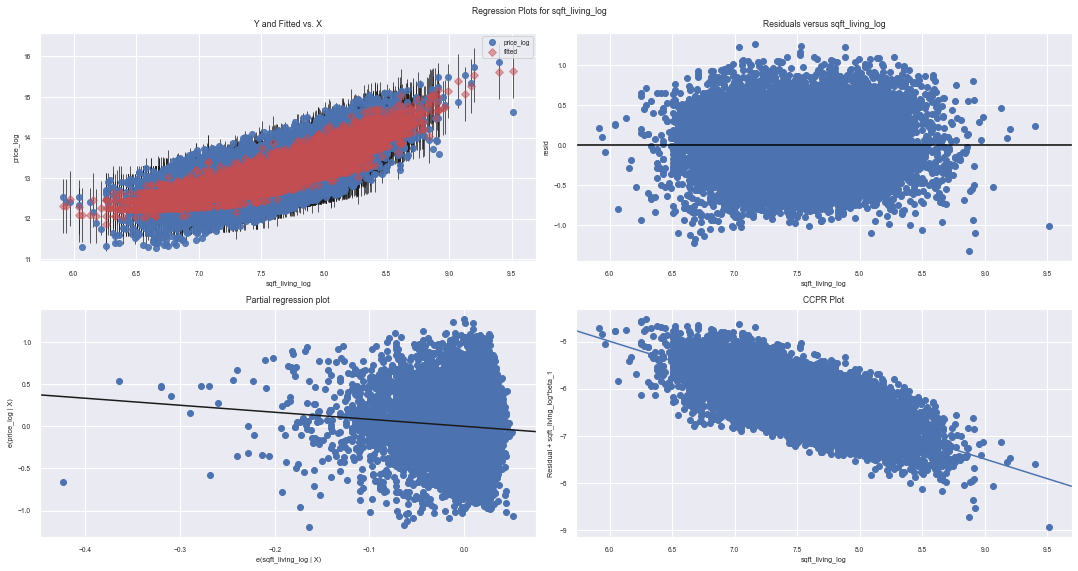

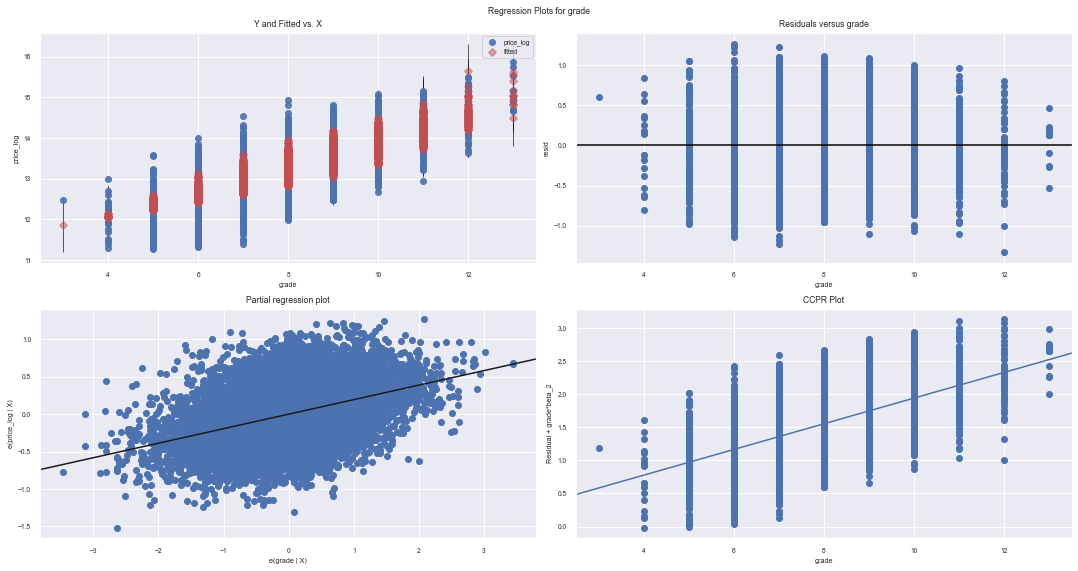

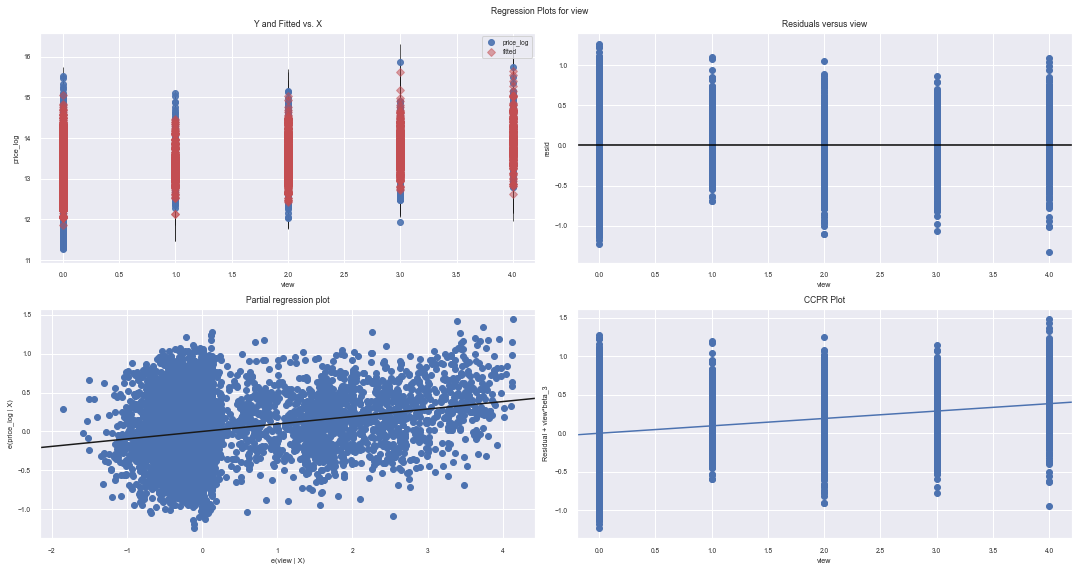

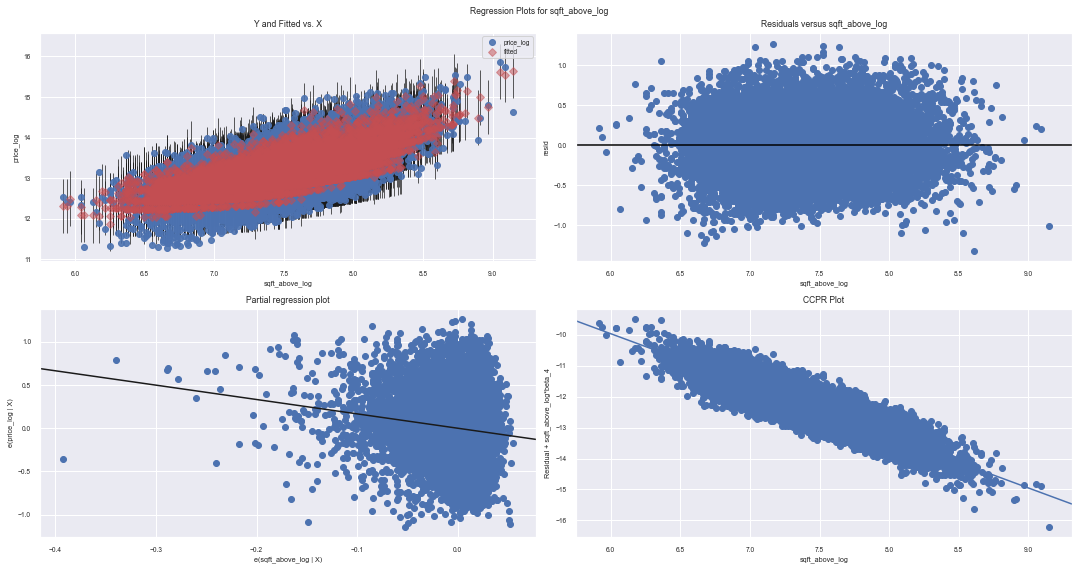

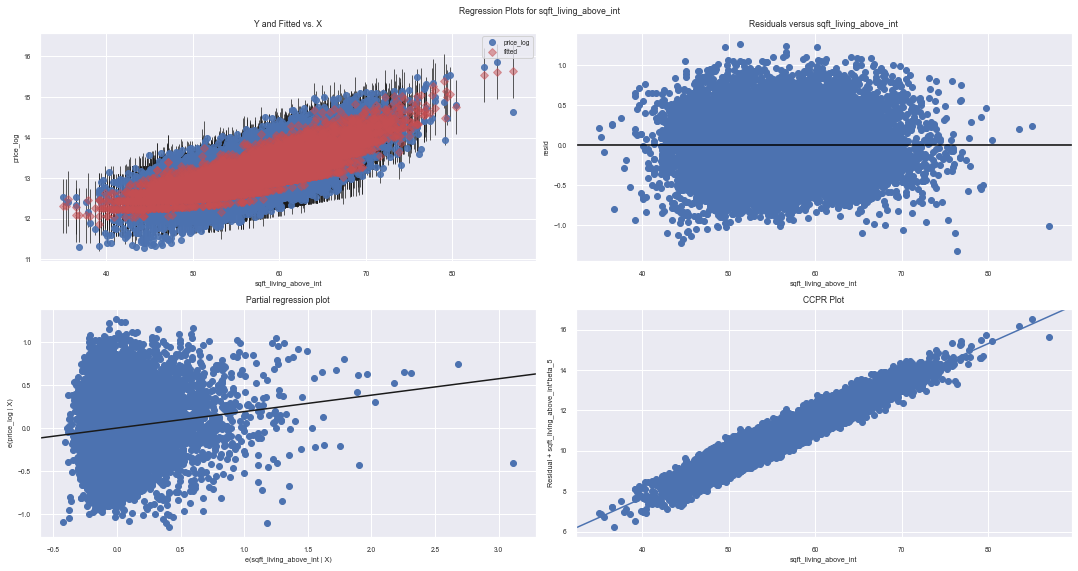

In [159]:
# plot feature residuals and check for homoskedacity
plot_residuals(model_nbr=3, model=model_3)

### K-folds

In [160]:
# cross validation to compare MAE on entire sample for m3 features
X_CV_m3 = X[features_m3]
y_CV_m3 = y['price_log']

kfolds(X_CV_m3, y_CV_m3, cv=5)

Cross-Validation MAE results: [0.28263836 0.27883299 0.27906775 0.2794183  0.25562632] | CV MAE Mean: 0.27511674296816996


### Model 3 Prediction

In [161]:
y_pred_train_m3, y_pred_test_m3 = predict(3, model_3, X_train_m3, X_test_m3, y_train_m3, y_test_m3)


Model 3 Prediction Statistics
--------------------------
Root Mean Squared Error (RMSE): Test 220410.0 | Train 227260.0 |           Difference -6850.0 | % Diff -0.030141687934524333
Mean Absolute Error (MAE): Test 143083.0 | Train 145184.0 |           Difference -2101.0 | % Diff -0.014471291602380427


**Model 3 Conclusion**
- Many metrics look ok, but not lifting above Model 2 plus warning on multi-collinearity. Model 3 is not a candidate for further development.

## Model 4: m2 + 5 features (Rank #3)

### Features

**Model 4 Approach**
- Start with Model 2 baseline and tried to add a bunch of core features. Five features were ultimately grouped incrementally to Model 2.

**Added Features**
- Trying to incorporate bedrooms based on intuition of housing pricing in market:
    - bedrooms: Gave negative coefficient and slighly raise MAE. Residuals show heteroskedascity at higher range of bedrooms.
    - bedrooms_log: Still negative coefficient. r2 improved 0.3% and \\$500 MAE improvement. Residuals still show heteroskedascity.
    - bedrooms_box-cod: lambda 0.58 (versus log lambda 0). Same, still negative coefficient and r2/MAE slightly worse than bedrooms_log.
    - bedrooms_der: Capping bedrooms at 6 removed heterosk. But didn't improve model in r2/MAE.
    - sqft_per_bedroom_log: Improved, keep this feature.
- Renovation_ind: Adding this included adjusted r2 by 0.005, MAE +1366, RMSA+2757 and lowered JB by 8 to 36. Residuals ok.
- Waterfront, Basement both increased as well
- Condition also bumped r2 0.01 and MAE another $3K.

**Tried but dropping**
- Sqft_Living15 barely most r2/MAE but caused a condition number warning about multi-colliarity. Dropping since 0.76 correlation to sqft_living.
- Sqft_Lot_Box less skewed than log and performed 150 MAE better. residuals look good. Coefficents are negative which I interpret as larger lot sizes probably outside suburbs where prices are lower.
- Trying again to add bathrooms given correlation after dropping in Model2.
    - adding bathrooms results in negative coefficent and does not improve model
    - adding bathroom_log also results in negative coefficient and no improvement.
    - Dropping bathroom feature
- Tried grouping condition for just excellent or poor but lost precision so scrapped.

In [162]:
# model 4 setup and call statsmodel function
features_m4 = ['sqft_living_log', 'grade', 'view', 'sqft_per_bedroom_log', 'renovation_ind', 
               'waterfront', 'basement_ind', 'condition'] 

# apply features to X_train and chose which y to predict
X_train_m4 = sm.add_constant(X_train[features_m4])
y_train_m4 = y_train['price_log']

# apply features to X_test and chose which y to predict
X_test_m4 = sm.add_constant(X_test[features_m4])
y_test_m4 = y_test['price_log']

# quick check of rows
X_train_m4.head()

const  sqft_living_log      grade       view  sqft_per_bedroom_log  \
6243  1.00000000       7.27239839 7.00000000 0.00000000            5.88610403   
8986  1.00000000       7.26542972 7.00000000 2.00000000            6.16681743   
9419  1.00000000       8.04558828 9.00000000 0.00000000            6.65929392   
10155 1.00000000       7.63046126 7.00000000 0.00000000            6.24416690   
10436 1.00000000       7.82404601 7.00000000 0.00000000            6.72543372   

       renovation_ind  waterfront  basement_ind  condition  
6243       0.00000000  0.00000000    0.00000000 4.00000000  
8986       0.00000000  0.00000000    1.00000000 4.00000000  
9419       0.00000000  0.00000000    0.00000000 3.00000000  
10155      0.00000000  0.00000000    1.00000000 3.00000000  
10436      0.00000000  0.00000000    1.00000000 5.00000000

### Run OLS

In [163]:
# run the model iteration and store in model variable
model_4, rsq_adj_m4, rmse_m4, mae_m4 = calc_sm_ols(model_nbr=4, X=X_train_m4, y=y_train_m4)

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     3272.
Date:                Fri, 02 Apr 2021   Prob (F-statistic):               0.00
Time:                        11:44:50   Log-Likelihood:                -5495.8
No. Observations:               17276   AIC:                         1.101e+04
Df Residuals:                   17267   BIC:                         1.108e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    8.1542 

**Model 4 Summary Interpretation**
- Adj r^2 = 0.602 | improved over Model 2 by 0.03 (from 0.571)
- P-value = 0.00 | would be good if all else checks
- Skew = 0.06 (tgt ~0), Kurtosis = 3 (tgt 3), JB = 10 (tgt 0-6) | Near perfect, similar to Model 2
- Cond. No. 334 | indicates well-conditioned, no warning and similar to model 2
- MAE \\$139K is an improvement of \\$8K over Model 2. This is good, and Model 4 is now best model.
- Predictors:
    - All features have p-values of 0.000 and reasonable standard errors.
    - Intercept: dropped from 8.55 in Model 2 to 8.15 with new feautres explaining more of price_log.
    - Sqft_Living_log and view coefficients dropped from Model 2 but grade increased.
    - New indicator features look good, with waterfront stronger than renovation stronger than basement.

### QQ-plot

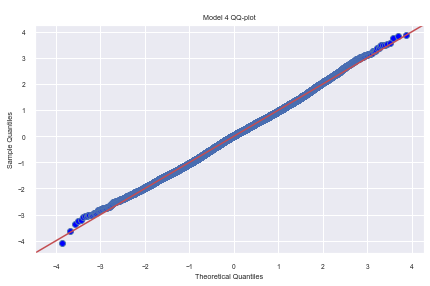

In [164]:
# plot the overall residuals via QQ-plot
qqplot(model_nbr=4, model=model_4)

**QQ-Plot Interpretation**
- Still looking really good, slight degradation on lower bound (-4 std dev)

### Plot Residuals

**Notes on Residuals**
- Final 5 features selected to be added do not display any obvious issues with heteoskedicity on residuals.

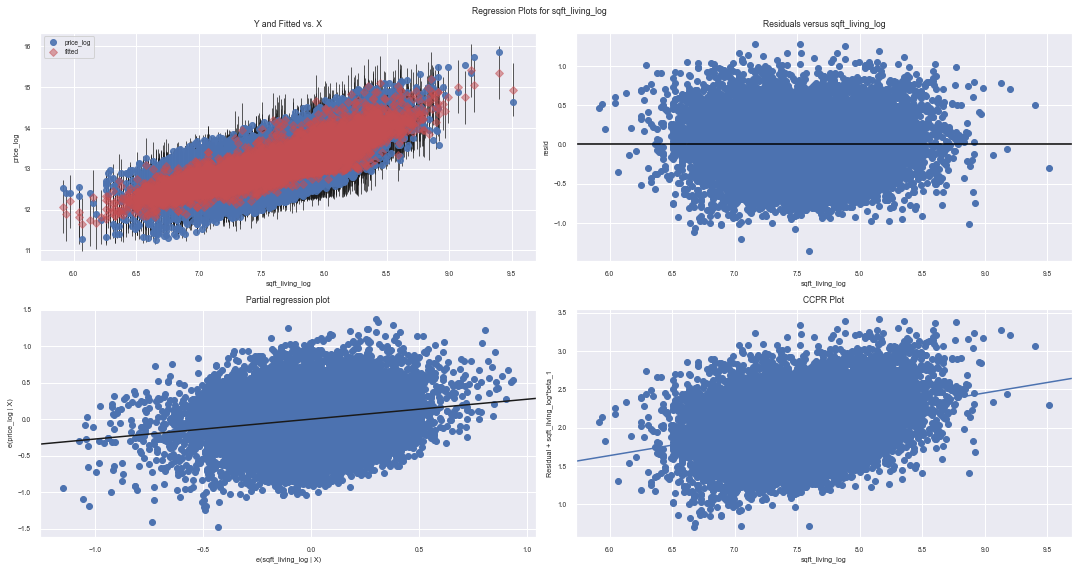

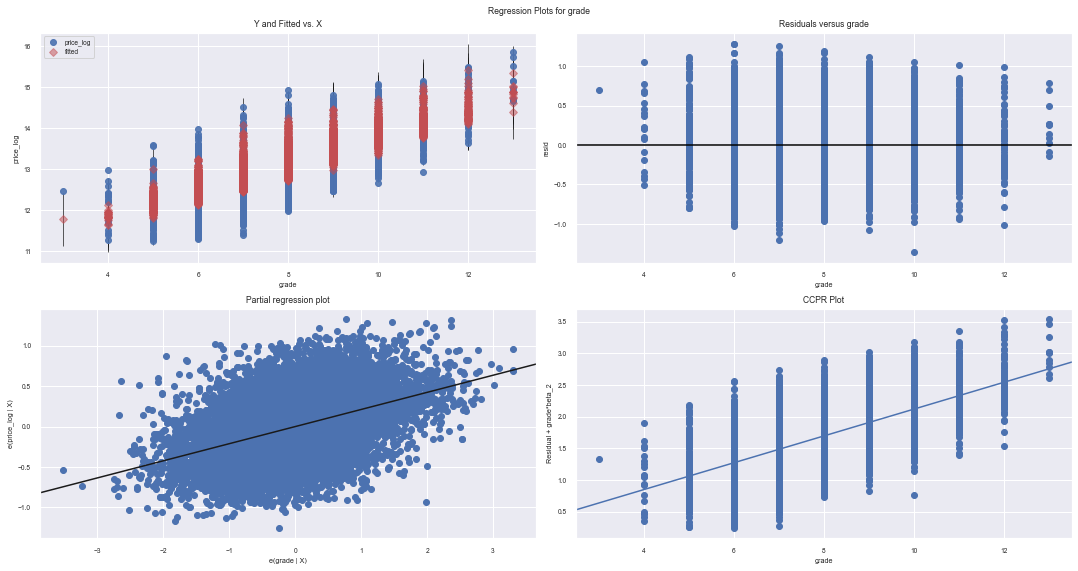

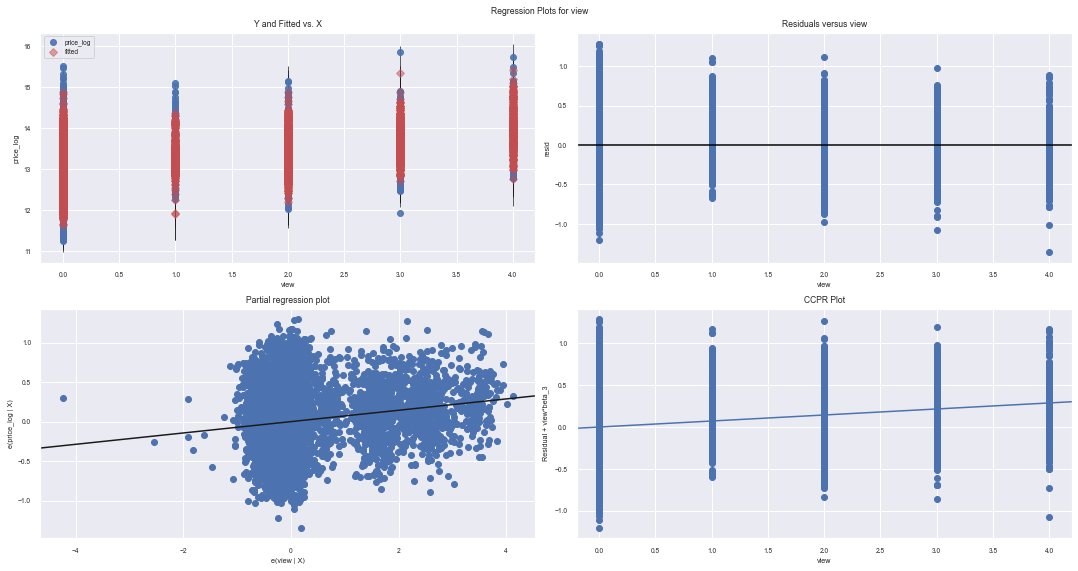

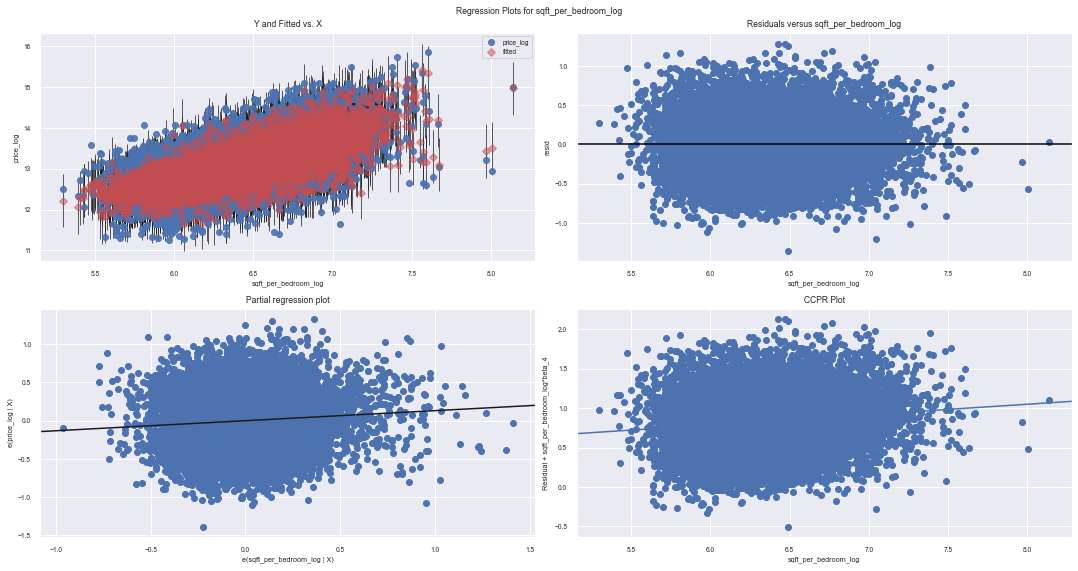

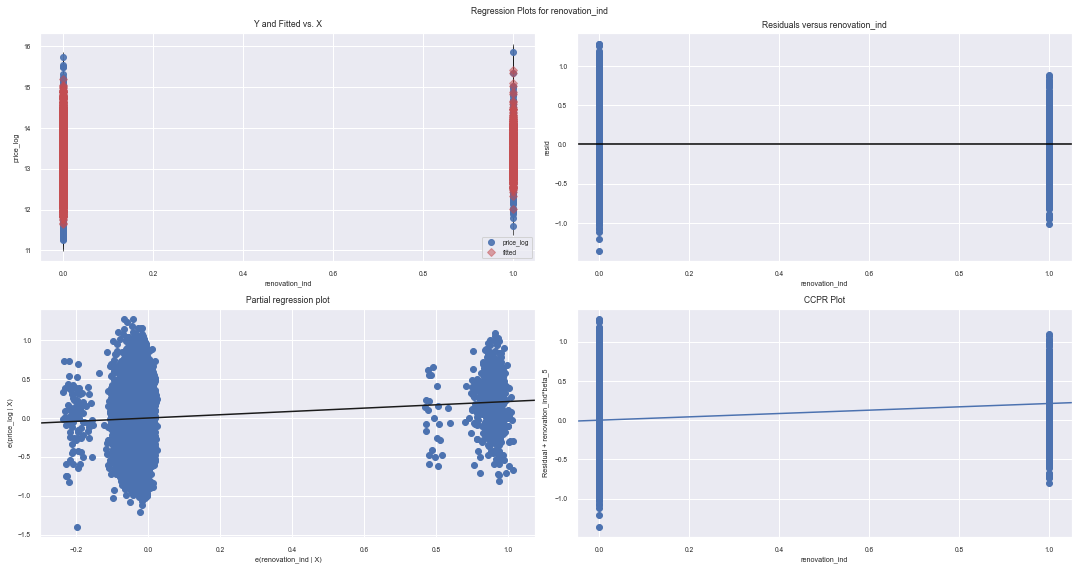

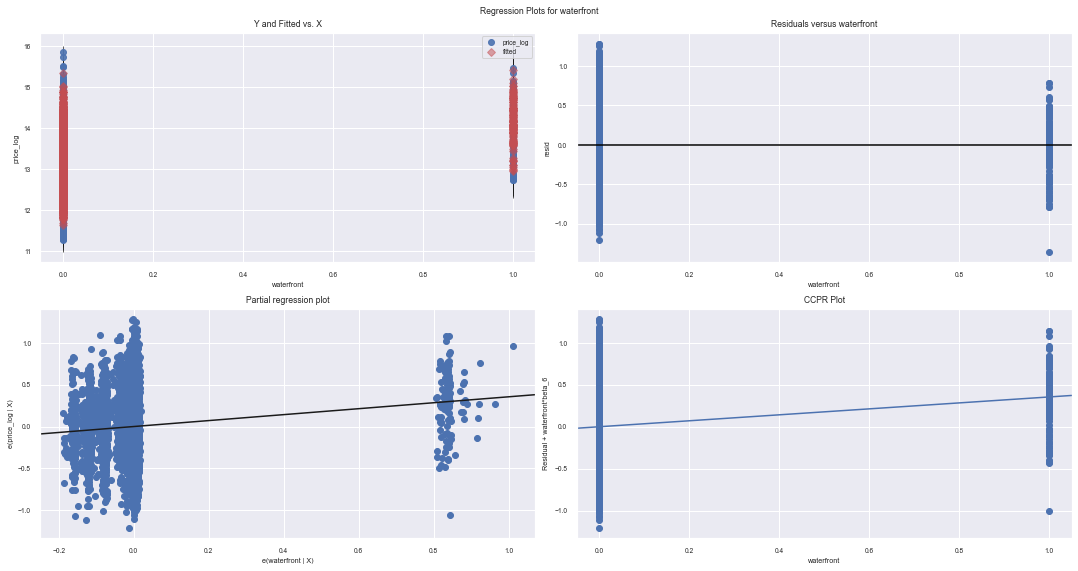

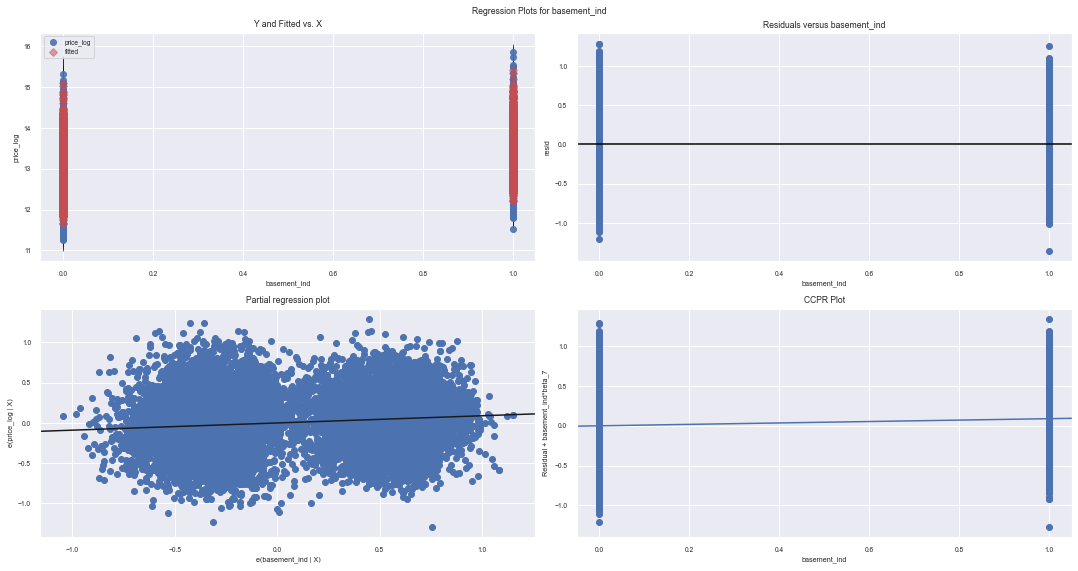

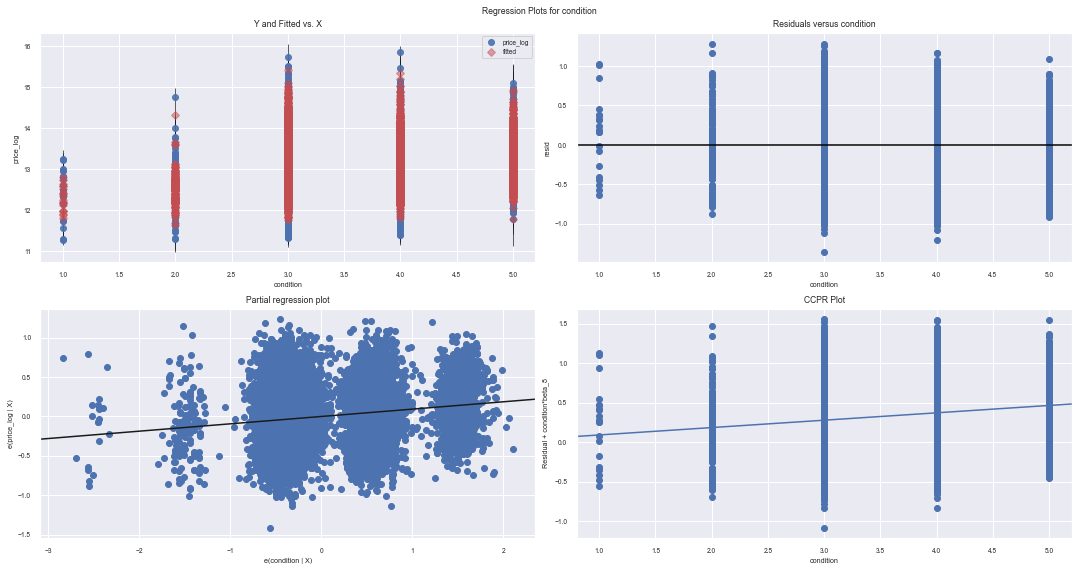

In [165]:
# plot feature residuals and check for homoskedacity
plot_residuals(model_nbr=4, model=model_4)

### K-folds

In [166]:
# cross validation to compare MAE on entire sample for m4 features
X_CV_m4 = X[features_m4]
y_CV_m4 = y['price_log']

kfolds(X_CV_m4, y_CV_m4, cv=5)

Cross-Validation MAE results: [0.27195817 0.27043085 0.26864477 0.27088094 0.24698612] | CV MAE Mean: 0.26578017081550015


Cross-validation using 5 kfolds results in 0.26532 MAE mean versus OLS model summary of 0.26519 (price_log). Very good!

### Model 4 Prediction

In [167]:
y_pred_train_m4, y_pred_test_m4 = predict(4, model_4, X_train_m4, X_test_m4, y_train_m4, y_test_m4)


Model 4 Prediction Statistics
--------------------------
Root Mean Squared Error (RMSE): Test 211305.0 | Train 218810.0 |           Difference -7505.0 | % Diff -0.0342991636579681
Mean Absolute Error (MAE): Test 137959.0 | Train 139025.0 |           Difference -1066.0 | % Diff -0.007667685668045316


**Model 4 Conclusion**
- Model 4 supplants Model 2 as best model so far
- MAE improved by +\\$8K and Adj R^2 by 0.03 versus Model 2
- MAE on test data for Model 4 is \\$138K, even \\$1K better than training

## Model 5: m4 + Seattle Miles (Rank #2)

### Features

**Model 5 Approach**
- Start with Model 4 baseline
- Add just one feature: Miles from Seattle Square Root (based on prior normality plots): 
    - Raised r2 by strong +0.07. MAE dropped by \\$12459. No issues with skew or residuals. Has negative correlation with price as expected.

In [168]:
# model 5 setup and call statsmodel function
features_m5 = ['sqft_living_log', 'grade', 'view', 'sqft_per_bedroom_log', 'renovation_ind', 
               'waterfront', 'basement_ind', 'condition', 'miles_fr_seattle_sqrt']

# apply features to X_train and chose which y to predict
X_train_m5 = sm.add_constant(X_train[features_m5])
y_train_m5 = y_train['price_log']

# apply features to X_test and chose which y to predict
X_test_m5 = sm.add_constant(X_test[features_m5])
y_test_m5 = y_test['price_log']

# quick check of rows
X_train_m5.head()

const  sqft_living_log      grade       view  sqft_per_bedroom_log  \
6243  1.00000000       7.27239839 7.00000000 0.00000000            5.88610403   
8986  1.00000000       7.26542972 7.00000000 2.00000000            6.16681743   
9419  1.00000000       8.04558828 9.00000000 0.00000000            6.65929392   
10155 1.00000000       7.63046126 7.00000000 0.00000000            6.24416690   
10436 1.00000000       7.82404601 7.00000000 0.00000000            6.72543372   

       renovation_ind  waterfront  basement_ind  condition  \
6243       0.00000000  0.00000000    0.00000000 4.00000000   
8986       0.00000000  0.00000000    1.00000000 4.00000000   
9419       0.00000000  0.00000000    0.00000000 3.00000000   
10155      0.00000000  0.00000000    1.00000000 3.00000000   
10436      0.00000000  0.00000000    1.00000000 5.00000000   

       miles_fr_seattle_sqrt  
6243              1.83478680  
8986              5.23596768  
9419              3.57258119  
10155             3.35003736  
10436             2.25581412

### Run OLS

In [169]:
# run the model iteration and store in model variable
model_5, rsq_adj_m5, rmse_m5, mae_m5 = calc_sm_ols(model_nbr=5, X=X_train_m5, y=y_train_m5)

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     4035.
Date:                Fri, 02 Apr 2021   Prob (F-statistic):               0.00
Time:                        11:45:12   Log-Likelihood:                -3682.2
No. Observations:               17276   AIC:                             7384.
Df Residuals:                   17266   BIC:                             7462.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     8.22

**Model 5 Summary Interpretation**
- Adj r^2 = 0.678 | nice jump of 0.076 from Model 4's 0.602. Nearly 68% of variance explained
- P-value = 0.00 | would be good if all else checks
- Skew = 0.03 (tgt ~0), Kurtosis = 3.3 (tgt 3), JB = 54 (tgt 0-6) | still great, slight increase in kurtosis from Model 4
- Cond. No. 344 | indicates well-conditioned
- MAE of \\$125K is better than Model 4 by \\$14K
- Predictors:
    - All feature coefficients have p-value of 0.00
    - Intercept: rose slighly over Model 4
    - Miles from Seattle sqrt: new feature has negative coefficient meaning city center locations have highest value
    - Sqft_living_log, waterfront features saw significant increases in coefficients. Sqft living strenght might be complimentary with miles away.
    - Grade, view, condition coefficients relatively flat versus Model 4
    - Basement and renovation coefficients declined signifcantly from Model 4

### QQ-plot

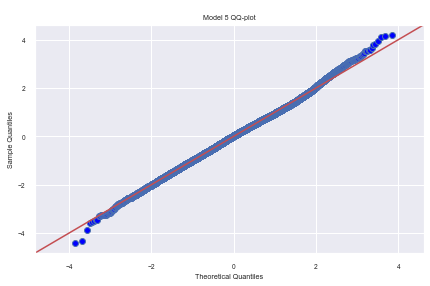

In [170]:
# plot the overall residuals via QQ-plot
qqplot(model_nbr=5, model=model_5)

**QQ-Plot Interpretation**
- Still acceptable, normal, but with begining of divergences on both tails now. If had more time, could investigate outliers or ways to modify transformation of miles away from seattle feature.

### Plot Residuals

**Notes on Residuals**
- Miles away from Seattle sqrt feature shows some minor heteoskedascity toward right tail. Model results still look good and reliable.

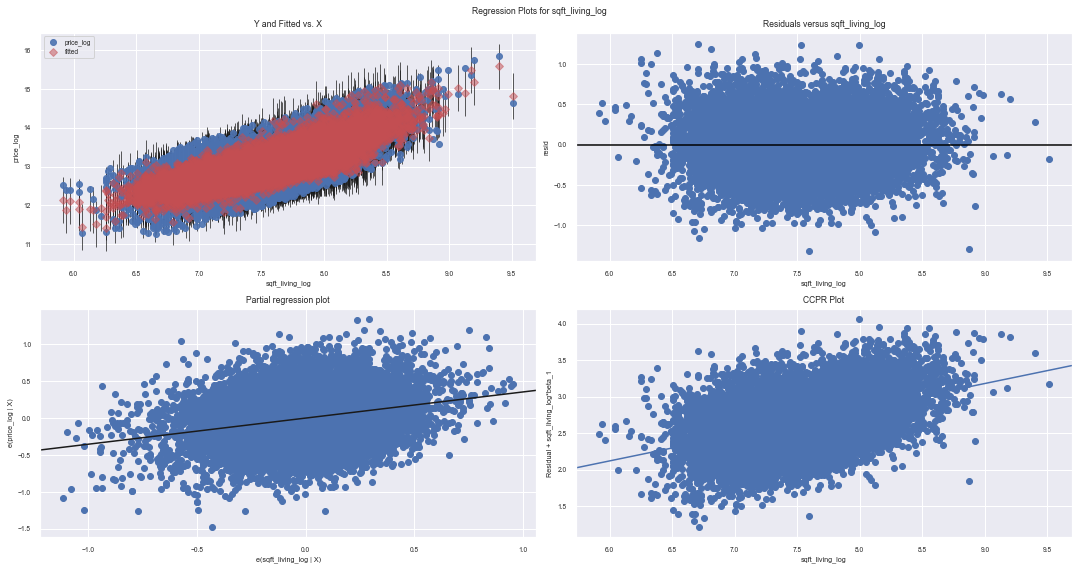

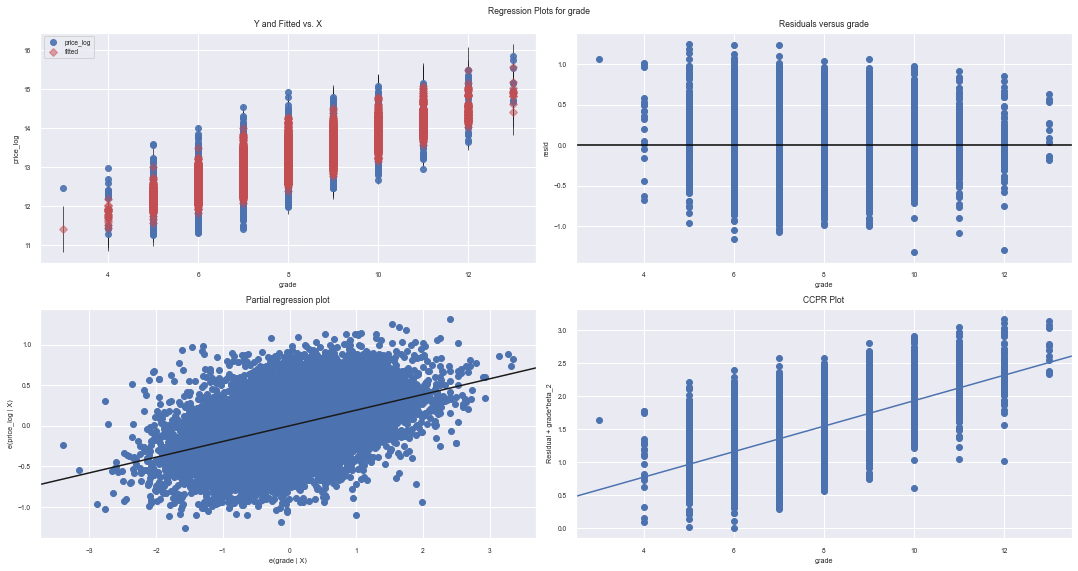

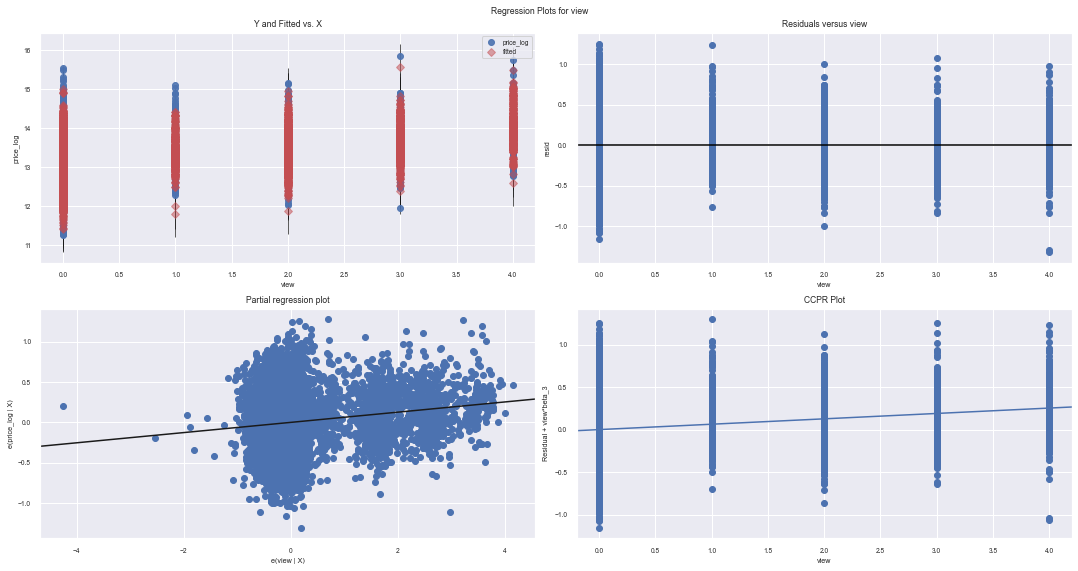

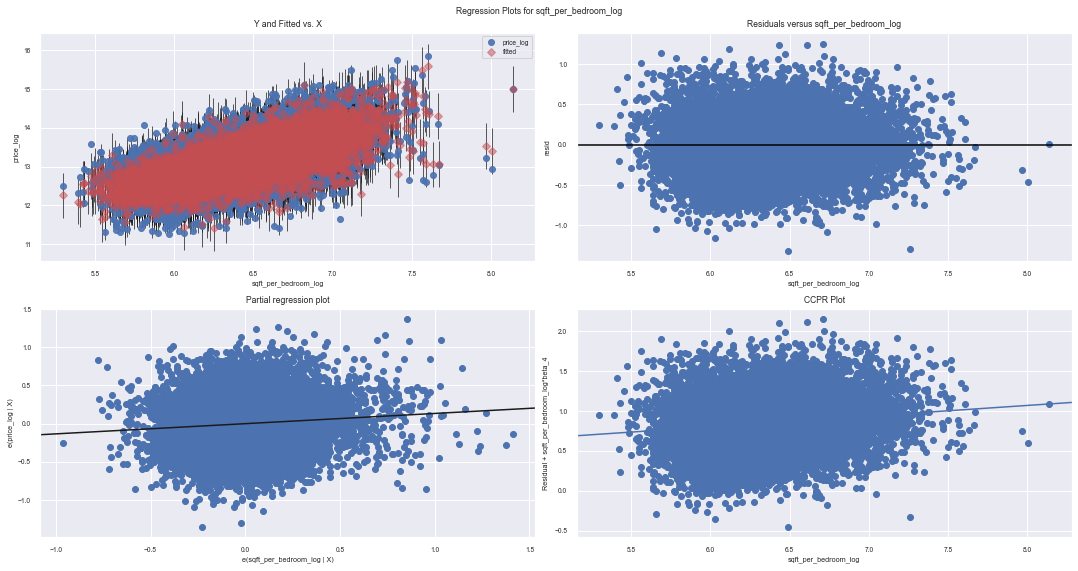

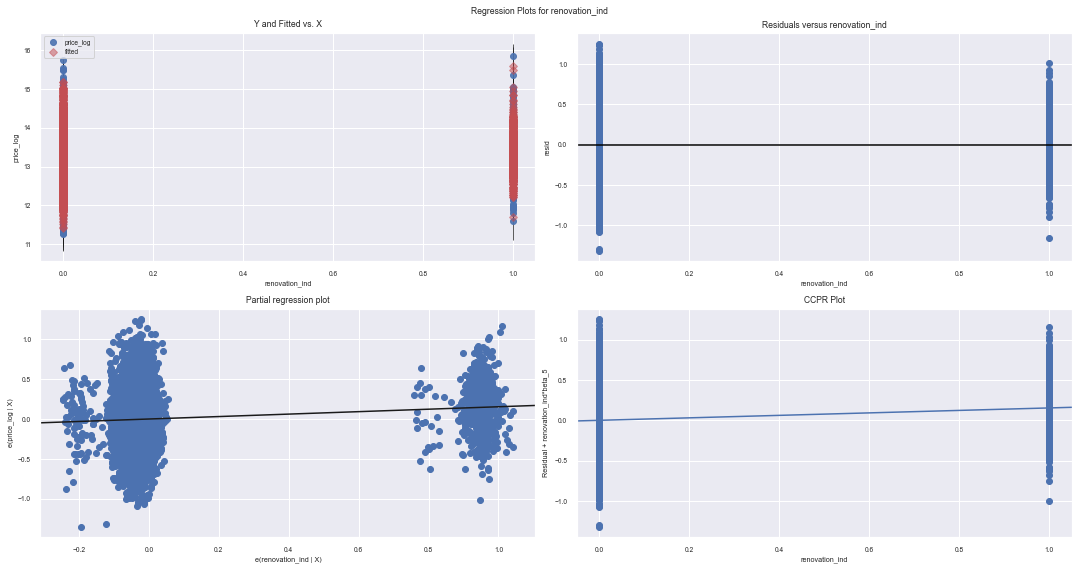

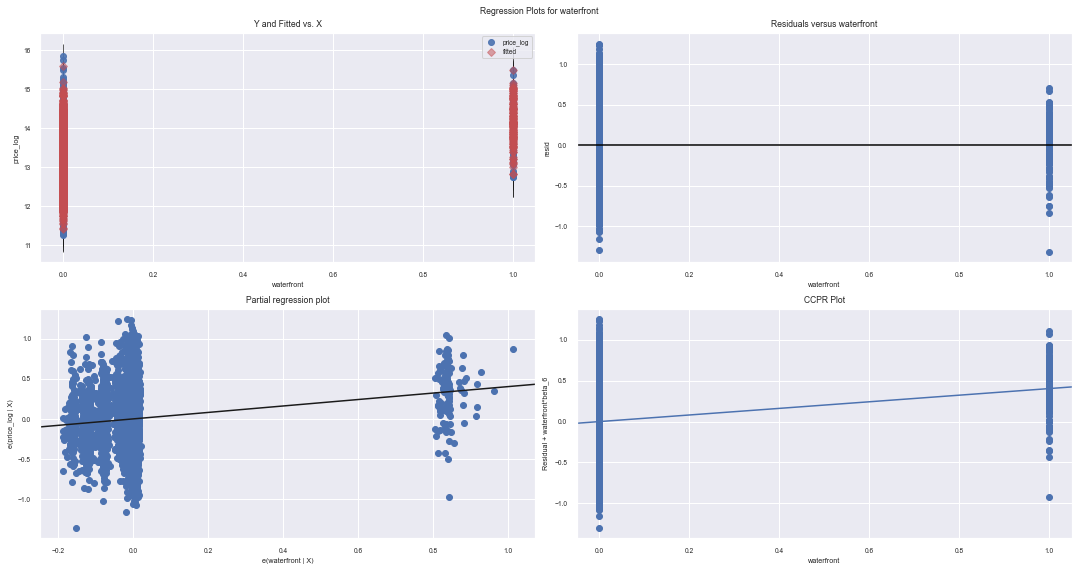

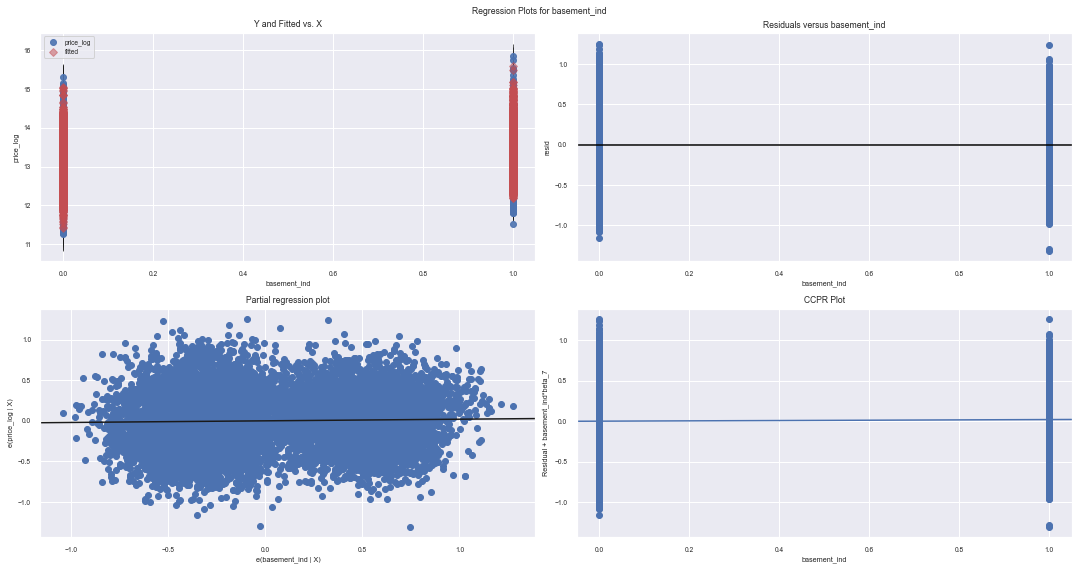

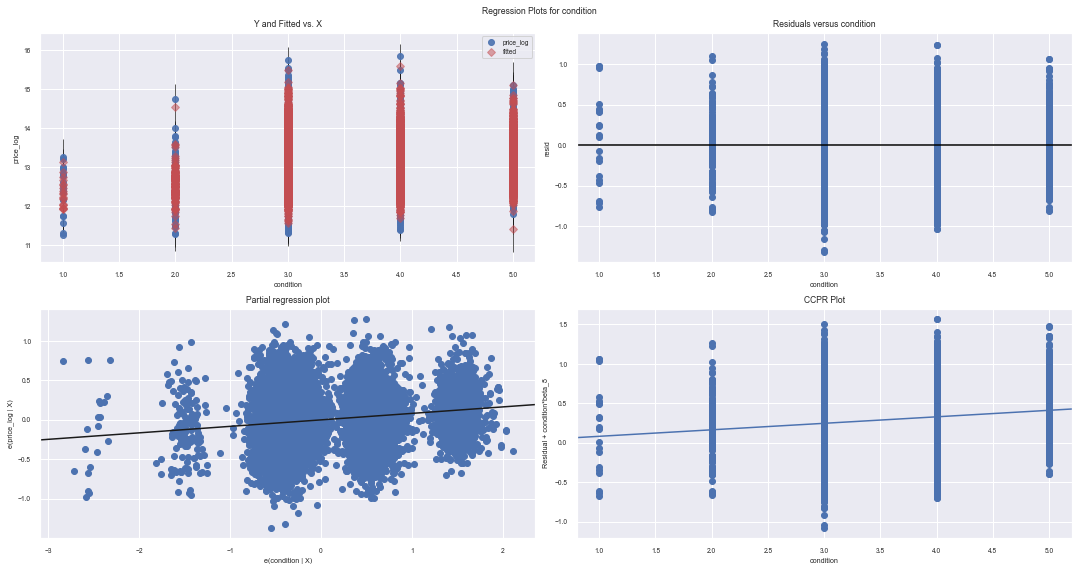

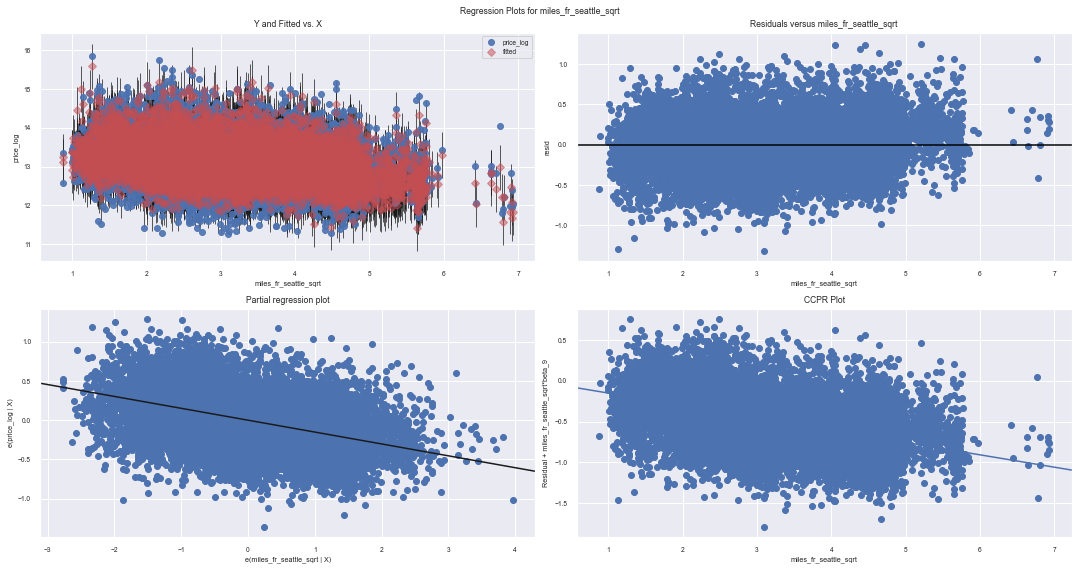

In [171]:
# plot feature residuals and check for homoskedacity
plot_residuals(model_nbr=5, model=model_5)

### K-folds

In [172]:
# cross validation to compare MAE on entire sample for m5 features
X_CV_m5 = X[features_m5]
y_CV_m5 = y['price_log']

kfolds(X_CV_m5, y_CV_m5, cv=5)

Cross-Validation MAE results: [0.22582049 0.22525236 0.22171873 0.24443528 0.30954385] | CV MAE Mean: 0.24535413984292087


Cross-validation using 5 kfolds results in 0.23747 MAE mean versus OLS model summary of 0.23730 (price_log). Very good!

### Model 5 Prediction

In [173]:
y_pred_train_m5, y_pred_test_m5 = predict(5, model_5, X_train_m5, X_test_m5, y_train_m5, y_test_m5)


Model 5 Prediction Statistics
--------------------------
Root Mean Squared Error (RMSE): Test 192026.0 | Train 196814.0 |           Difference -4788.0 | % Diff -0.024327537675165385
Mean Absolute Error (MAE): Test 123136.0 | Train 125099.0 |           Difference -1963.0 | % Diff -0.01569157227475839


**Model 5 Conclusion**
- Model 5 supplants Model 4 as best model so far
- MAE improved by +\\$14K and Adj R^2 by 0.076 versus Model 4
- MAE on test data for Model 5 is \\$123K, even \\$2K better than training

## Model 6  m5 + Zip Codes (Abandon)

### Strategy

**Model 6 Approach**
- Start with Model 5 baseline
- Add zipcode OHE feature for 69 zipcodes, holding back one

In [174]:
# model 6 setup and call statsmodel function
features_m6 = ['sqft_living_log','grade','view','sqft_per_bedroom_log','renovation_ind','waterfront','basement_ind','condition','miles_fr_seattle_sqrt',
               'zipcode_98002', 'zipcode_98003', 'zipcode_98004', 'zipcode_98005', 'zipcode_98006', 'zipcode_98007', 'zipcode_98008', 'zipcode_98010', 
               'zipcode_98011', 'zipcode_98014', 'zipcode_98019', 'zipcode_98022', 'zipcode_98023', 'zipcode_98024', 'zipcode_98027', 'zipcode_98028', 
               'zipcode_98029', 'zipcode_98030', 'zipcode_98031', 'zipcode_98032', 'zipcode_98033', 'zipcode_98034', 'zipcode_98038', 'zipcode_98039', 
               'zipcode_98040', 'zipcode_98042', 'zipcode_98045', 'zipcode_98052', 'zipcode_98053', 'zipcode_98055', 'zipcode_98056', 'zipcode_98058', 
               'zipcode_98059', 'zipcode_98065', 'zipcode_98070', 'zipcode_98072', 'zipcode_98074', 'zipcode_98075', 'zipcode_98077', 'zipcode_98092', 
               'zipcode_98102', 'zipcode_98103', 'zipcode_98105', 'zipcode_98106', 'zipcode_98107', 'zipcode_98108', 'zipcode_98109', 'zipcode_98112', 
               'zipcode_98115', 'zipcode_98116', 'zipcode_98117', 'zipcode_98118', 'zipcode_98119', 'zipcode_98122', 'zipcode_98125', 'zipcode_98126', 
               'zipcode_98133', 'zipcode_98136', 'zipcode_98144', 'zipcode_98146', 'zipcode_98148', 'zipcode_98155', 'zipcode_98166', 'zipcode_98168', 
               'zipcode_98177', 'zipcode_98178', 'zipcode_98188', 'zipcode_98198', 'zipcode_98199']

# apply features to X_train and chose which y to predict
X_train_m6 = sm.add_constant(X_train[features_m6])
y_train_m6 = y_train['price_log']

# apply features to X_test and chose which y to predict
X_test_m6 = sm.add_constant(X_test[features_m6])
y_test_m6 = y_test['price_log']

# quick check of rows
X_train_m6.head()

const  sqft_living_log      grade       view  sqft_per_bedroom_log  \
6243  1.00000000       7.27239839 7.00000000 0.00000000            5.88610403   
8986  1.00000000       7.26542972 7.00000000 2.00000000            6.16681743   
9419  1.00000000       8.04558828 9.00000000 0.00000000            6.65929392   
10155 1.00000000       7.63046126 7.00000000 0.00000000            6.24416690   
10436 1.00000000       7.82404601 7.00000000 0.00000000            6.72543372   

       renovation_ind  waterfront  basement_ind  condition  \
6243       0.00000000  0.00000000    0.00000000 4.00000000   
8986       0.00000000  0.00000000    1.00000000 4.00000000   
9419       0.00000000  0.00000000    0.00000000 3.00000000   
10155      0.00000000  0.00000000    1.00000000 3.00000000   
10436      0.00000000  0.00000000    1.00000000 5.00000000   

       miles_fr_seattle_sqrt  zipcode_98002  zipcode_98003  zipcode_98004  \
6243              1.83478680              0              0              0   
8986              5.23596768              0              0              0   
9419              3.57258119              0              0              0   
10155             3.35003736              0              0              0   
10436             2.25581412              0              0              0   

       zipcode_98005  zipcode_98006  zipcode_98007  zipcode_98008  \
6243               0              0              0              0   
8986               0              0              0              0   
9419               0              0              0              0   
10155              0              0              0              0   
10436              0              0              0              0   

       zipcode_98010  zipcode_98011  zipcode_98014  zipcode_98019  \
6243               0              0              0              0   
8986               0              0              0              0   
9419               0              0              0              0   
10155              0              0              0              0   
10436              0              0              0              0   

       zipcode_98022  zipcode_98023  zipcode_98024  zipcode_98027  \
6243               0              0              0              0   
8986               0              0              0              0   
9419               0              0              0              0   
10155              0              0              0              0   
10436              0              0              0              0   

       zipcode_98028  zipcode_98029  zipcode_98030  zipcode_98031  \
6243               0              0              0              0   
8986               0              0              0              0   
9419               0              0              0              0   
10155              0              0              0              0   
10436              0              0              0              0   

       zipcode_98032  zipcode_98033  zipcode_98034  zipcode_98038  \
6243               0              0              0              0   
8986               0              0              0              0   
9419               0              0              0              0   
10155              0              0              1              0   
10436              0              0              0              0   

       zipcode_98039  zipcode_98040  zipcode_98042  zipcode_98045  \
6243               0              0              0              0   
8986               0              0              0              1   
9419               0              0              0              0   
10155              0              0              0              0   
10436              0              0              0              0   

       zipcode_98052  zipcode_98053  zipcode_98055  zipcode_98056  \
6243               0              0              0              0   
8986               0              0              0          

### Run OLS

In [175]:
# run the model iteration and store in model variable
model_6, rsq_adj_m6, rmse_m6, mae_m6 = calc_sm_ols(model_nbr=6, X=X_train_m6, y=y_train_m6)

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     1510.
Date:                Fri, 02 Apr 2021   Prob (F-statistic):               0.00
Time:                        11:45:38   Log-Likelihood:                 4334.8
No. Observations:               17276   AIC:                            -8512.
Df Residuals:                   17197   BIC:                            -7899.
Df Model:                          78                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     7.64

**Model 6 Summary Interpretation**
- Adj r^2 = 0.872 | jumped 0.19 versus Model 5!
- P-value = 0.00 | would be good if all else checks
- Skew = 0.3 (tgt ~0), Kurtosis = 5.5 (tgt 3), JB = 4711 (tgt 0-6) | skew is good, but kurtosis > 5 indicates uneven tails
- Cond. No. 916 | indicates well-conditioned. No warnings.
- MAE of \\$76K represents a \\$49K improvement over Model 5! Is this too good to be true?
- Predictors:
    - Intercept: drops by about 7% versus Model 6
    - Sqft_Living_Log and Sqft_per_bedroom_log: Both coefficients got much stronger in Model 6 using zipcodes
    - Miles from Seattle feature lost 80+% of it's power, presume zipcodes captured most of the geographical proximity to city centers better than pure mileage
    - Condition, Basement, Renovation and Grade less influential than Model 5
    - Waterfront stronger coefficient
    - Basement actually flipped signs in Model 6 to be negative

### QQ-plot

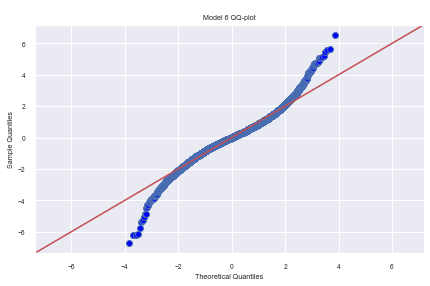

In [176]:
# plot the overall residuals via QQ-plot
qqplot(model_nbr=6, model=model_6)

**QQ-Plot Interpretation**
- Yikes! This model has major problems on the tails. The residuals are not near normal, and my confidene in this model is not good. I think this is poor enough to reject or re-work this model in future iteration.

### Plot Residuals

**Notes on Residuals**

In [ ]:
# plot feature residuals and check for homoskedacity
plot_residuals(model_nbr=6, model=model_6)

### K-folds

In [177]:
# cross validation to compare MAE on entire sample for m6 features
X_CV_m6 = X[features_m6]
y_CV_m6 = y['price_log']

kfolds(X_CV_m6, y_CV_m6, cv=5)

Cross-Validation MAE results: [0.1432868  0.14112342 0.13814072 0.14129817 0.13574397] | CV MAE Mean: 0.13991861736324335


Cross-validation using 5 kfolds results in 0.13909 MAE mean versus OLS model summary of 0.13833(price_log). Good, less than 0.5% off.

### Model 6 Prediction

In [178]:
y_pred_train_m6, y_pred_test_m6 = predict(6, model_6, X_train_m6, X_test_m6, y_train_m6, y_test_m6)


Model 6 Prediction Statistics
--------------------------
Root Mean Squared Error (RMSE): Test 130679.0 | Train 135249.0 |           Difference -4570.0 | % Diff -0.0337895289429127
Mean Absolute Error (MAE): Test 75976.0 | Train 75969.0 |           Difference 7.0 | % Diff 9.214284774052574e-05


**Model 6 Conclusion**
- Model 6 will be shelved, despite great summary stats, due to the QQ-plots show residuals aren't normal. Need to validate this with peer review.
- MAE improved by +\\$49K and Adj R^2 by 0.19 versus Model 5
- MAE on test data for Model 6 is $76K, spot on with training.
- Tough to walk-away from this one. With more time, might be able to tweak zipcode appoach to work with this. I tried a few alterations that didn't work.

## Model 7  m5 + Normalize (Abandon)

### Features

**Model 7 Approach**
- Start with Model 5 baseline
- normalize all features using normalize() funtion : (feature - feature.mean()) / feature.std()
- Goal is to see if standard scaling improves any results

In [179]:
# model 7 setup and call statsmodel function
features_m7 = ['sqft_living_log', 'grade', 'view', 'sqft_per_bedroom_log', 'renovation_ind', 
               'waterfront', 'basement_ind', 'condition', 'miles_fr_seattle_sqrt']

# apply features to X_train and chose which y to predict
X_train_m7 = sm.add_constant(X_train[features_m7].apply(normalize))
y_train_m7 = y_train['price_log']

# apply features to X_test and chose which y to predict
X_test_m7 = sm.add_constant(X_test[features_m7].apply(normalize))
y_test_m7 = y_test['price_log']

# quick check of rows
X_train_m7.head()

const  sqft_living_log       grade        view  \
6243  1.00000000      -0.65882729 -0.56079704 -0.30272758   
8986  1.00000000      -0.67526118 -0.56079704  2.30896866   
9419  1.00000000       1.16455083  1.15001519 -0.30272758   
10155 1.00000000       0.18557589 -0.56079704 -0.30272758   
10436 1.00000000       0.64209789 -0.56079704 -0.30272758   

       sqft_per_bedroom_log  renovation_ind  waterfront  basement_ind  \
6243            -1.50583829     -0.18786936 -0.08327991   -0.79135728   
8986            -0.63759039     -0.18786936 -0.08327991    1.26357859   
9419             0.88564174     -0.18786936 -0.08327991   -0.79135728   
10155           -0.39834812     -0.18786936 -0.08327991    1.26357859   
10436            1.09021246     -0.18786936 -0.08327991    1.26357859   

        condition  miles_fr_seattle_sqrt  
6243   0.90294258            -1.42953230  
8986   0.90294258             2.00270340  
9419  -0.63030256             0.32412920  
10155 -0.63030256             0.09955341  
10436  2.43618773            -1.00466075

### Run OLS

In [180]:
# run the model iteration and store in model variable
model_7, rsq_adj_m7, rmse_m7, mae_m7 = calc_sm_ols(model_nbr=7, X=X_train_m7, y=y_train_m7)

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     4035.
Date:                Fri, 02 Apr 2021   Prob (F-statistic):               0.00
Time:                        11:46:17   Log-Likelihood:                -3682.2
No. Observations:               17276   AIC:                             7384.
Df Residuals:                   17266   BIC:                             7462.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    13.04

**Model 7 Summary Interpretation**
- Adj r^2, p-value, skew, kurtosis, JB and MAE all exactly the same as Model 5
- Only changes:
    - Cond. No. drops from 344 to 3.64 which is good.
    - Coefficients changed across the board:
        - Increase coeff: grade was only one. Why?

### QQ-plot

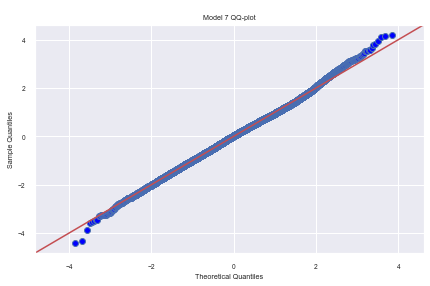

In [181]:
# plot the overall residuals via QQ-plot
qqplot(model_nbr=7, model=model_7)

**QQ-Plot Interpretation**
- Not noticably different than Model 5

### Plot Residuals

**Notes on Residuals**
- Not different than Model 5

In [ ]:
# plot feature residuals and check for homoskedacity
plot_residuals(model_nbr=7, model=model_7)

### K-folds

In [182]:
# cross validation to compare MAE on entire sample for m7 features
X_CV_m7 = X[features_m7]
y_CV_m7 = y['price_log']

kfolds(X_CV_m7, y_CV_m7, cv=5)

Cross-Validation MAE results: [0.22582049 0.22525236 0.22171873 0.24443528 0.30954385] | CV MAE Mean: 0.24535413984292087


Cross-validation using 5 kfolds results in 0.23747 MAE mean versus OLS model summary of 0.23730 (price_log). Almost exact.

### Model 7 Prediction

In [183]:
y_pred_train_m7, y_pred_test_m7 = predict(7, model_7, X_train_m7, X_test_m7, y_train_m7, y_test_m7)


Model 7 Prediction Statistics
--------------------------
Root Mean Squared Error (RMSE): Test 192619.0 | Train 196814.0 |           Difference -4195.0 | % Diff -0.021314540632272096
Mean Absolute Error (MAE): Test 123138.0 | Train 125099.0 |           Difference -1961.0 | % Diff -0.01567558493673011


**Model 7 Conclusion**
- Model 5 is still best model
- Model 7 didn't move the needle on quality metrics that matter for our model performance
- Normalization didn't have much impact besides lowering condition number and slightly better k-folds performance.

## Model 8 m5 + PSF Medians (Rank #1)

### Features

**Model 8 Approach**
- Start with Model 5 baseline
- Round 1: Add Price Per Sqft Decile: Initial feature had r2 0.96 and MAE at \\$41K, but residuals had pattern with deciles 1/10 skewed and deciles 2-8 declining from positive to negative. Shelved this approach.
- Round 2: Using median price-per-sqft by zipcode as feature to train on price instead.
    

In [184]:
# model 8 setup and call statsmodel function
features_m8 = ['sqft_living_log', 'view', 'grade', 'sqft_per_bedroom_log', 'renovation_ind',
               'waterfront', 'basement_ind', 'condition', 'miles_fr_seattle_sqrt', 
               'zip_psf_median_box']

# apply features to X_train and chose which y to predict
X_train_m8 = sm.add_constant(X_train[features_m8])
y_train_m8 = y_train['price_log']

# apply features to X_test and chose which y to predict
X_test_m8 = sm.add_constant(X_test[features_m8])
y_test_m8 = y_test['price_log']

# quick check of rows
X_train_m8.head()

const  sqft_living_log       view      grade  sqft_per_bedroom_log  \
6243  1.00000000       7.27239839 0.00000000 7.00000000            5.88610403   
8986  1.00000000       7.26542972 2.00000000 7.00000000            6.16681743   
9419  1.00000000       8.04558828 0.00000000 9.00000000            6.65929392   
10155 1.00000000       7.63046126 0.00000000 7.00000000            6.24416690   
10436 1.00000000       7.82404601 0.00000000 7.00000000            6.72543372   

       renovation_ind  waterfront  basement_ind  condition  \
6243       0.00000000  0.00000000    0.00000000 4.00000000   
8986       0.00000000  0.00000000    1.00000000 4.00000000   
9419       0.00000000  0.00000000    0.00000000 3.00000000   
10155      0.00000000  0.00000000    1.00000000 3.00000000   
10436      0.00000000  0.00000000    1.00000000 5.00000000   

       miles_fr_seattle_sqrt  zip_psf_median_box  
6243              1.83478680          4.59000241  
8986              5.23596768          4.35340191  
9419              3.57258119          4.48146811  
10155             3.35003736          4.48303042  
10436             2.25581412          4.69956287

### Run OLS

In [185]:
# run the model iteration and store in model variable
model_8, rsq_adj_m8, rmse_m8, mae_m8 = calc_sm_ols(
    model_nbr=8, X=X_train_m8, y=y_train_m8)

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     5050.
Date:                Fri, 02 Apr 2021   Prob (F-statistic):               0.00
Time:                        11:46:38   Log-Likelihood:                -1653.3
No. Observations:               17276   AIC:                             3329.
Df Residuals:                   17265   BIC:                             3414.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     3.31

**Model Summary Interpretation**
- Adj r^2 = 0.745 | represents a lift of 0.067 over Model 5. This is great.
- P-value = 0.00 | would be good if all else checks
- Skew = 0.04 (tgt ~0), Kurtosis = 4.4 (tgt 3), JB = 1406 (tgt 0-6) | skew is good, kurtosis creeped higher by 1 but still ok.
- Cond. No. 629 | indicates well-conditioned
- MAE improves by \\$17K to \\$108K in Model 8 over Model 5. 
- Predictors:
    - Intercept cut by more than half from model 5.
    - zip_psf_median_box becomes strongest predictor, picking up reduced intercept value
    - other predictors shifted a bit up and down but not dramatically. general relationships held

### QQ-plot

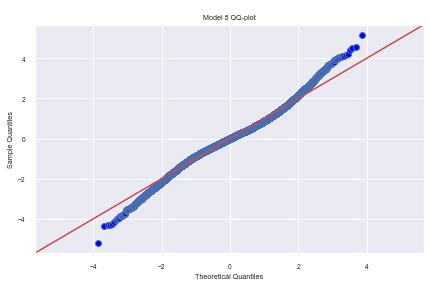

In [186]:
# plot the overall residuals via QQ-plot
qqplot(model_nbr=8, model=model_8)

**QQ-Plot Interpretation**
- Residuals aren't perfectly normal, but I'm going with this model as a mid-point between Model 5 and Model 6.
- Both tails are less precise, and there are probably a few outliers that I could look at other transformations in future iteration.

### Plot Residuals

**Notes on Residuals**
- residuals on zip_psf_median_box do show a sligthly declining slope from left to right. There is a small pattern there. This might disqualify model if it doesn't predict on test data well.

In [ ]:
# plot feature residuals and check for homoskedacity
plot_residuals(model_nbr=8, model=model_8)

### K-folds

In [187]:
# cross validation to compare MAE on entire sample for m8 features
X_CV_m8 = X[features_m8]
y_CV_m8 = y['price_log']

kfolds(X_CV_m8, y_CV_m8, cv=5)

Cross-Validation MAE results: [0.17222658 0.17225107 0.16662543 0.21310348 0.33741885] | CV MAE Mean: 0.21232508191181104


Cross-validation using 5 kfolds results in 0.21235 MAE mean versus OLS model summary of 0.19907 (price_log). 6% off, not ideal but will hold.

### Model 8 Prediction

In [188]:
y_pred_train_m8, y_pred_test_m8 =  predict(8, model_8, X_train_m8, X_test_m8, y_train_m8, y_test_m8)


Model 8 Prediction Statistics
--------------------------
Root Mean Squared Error (RMSE): Test 181934.0 | Train 181748.0 |           Difference 186.0 | % Diff 0.001023395030481766
Mean Absolute Error (MAE): Test 108268.0 | Train 107812.0 |           Difference 456.0 | % Diff 0.004229584832857196


**Model 8 Conclusion**
- Model 8 is now the best model.
- Model 8 increased adj r^2 by 0.067 to 0.745 and reduced MAE by \\$17K to \\$108K with still reasonable normality of residuals.
- Recommending Model 8 as final model for peer review

**Final Model 8 Analysis**

As noted above, I am chosing Model 8 as the best model based on adjusted r^2, MAE and RMSE. The model has 10 predictors (4 transformed through power) and 1 log-transformed target. Due to these transformations, interpretation of the coefficients is challenging. Since the target variable price is log transformed, we cannot easily isolate the relative importance of each coefficient on price. The sum of all applied coefficients must be used to decomponse price_log. I used a single example also used in the non-technical presentation to discuss the model in more detail.

**From the Test Set**
- Index 19497 (see iloc record below)
- Home Name: “Rainy Paradise” (made-up)
- Home ID: 2780910100
- Zip Code: 98038
- Year Built: 2004
- Date Sold: 12/18/2014
- Sales Price: \\$349,900
- Predicted Price: \\$375,586

**Model 8 Influences: Rainy Paradise**
- Model Constant (23% of prediction)
- Living Sq. Ft. 2,530 (26% of prediction)
- Sq. Ft. Per Bedroom 506 (5% of prediction)
- View 0 (None) 0%
- Grade 7 (Average) (9% of prediction)
- Renovation 0 (No) 0%
- Waterfront 0 (No) 0%
- Basement 0 (No) 0%
- Condition 3 (Average) (2% of prediction)
- Miles From Seattle 6.95 (0.2% of prediction)
- Zip Code Price Per Sq. Ft. \\$201.82 (36% of prediction)

Based on this single example, the following is true:

- Heavy Coeffients: Constant, Living Sqft, Zip Code Price Per Sqft
- Medium Coefficients: Sqft Per Bedroom, Grade
- Low Coefficients: Condition, Miles From Seattle
- Not Applicable: View, Renovation, Waterfront and Basement

If these boolen features were added, each by itself, to Rainy Paradise:
- Waterfront: +\\$189K incremental to sales price prediction
- Renovation: +\\$54K incremental to sales price prediction
- Basement: +\\$9K incremental to sales price prediction
- Grade increased from 7 to 10: +\\$240K incremental to sales price prediction

Due to nature of this model, multiple features changes would not be directly additive nor would the incremental amounts be the same for other houses.

**Model 8 Coefficients**
- const 3.3151, sqft_living_log 0.3704, view 0.07, grade 0.1647, sqft_per_bedroom_log 0.0953, renovation_ind 0.1349, waterfront	0.4077, basement_ind 0.0238, condition	0.0723, miles_fr_seattle_sqrt 0.0104, zip_psf_median_box 1.0698
- These coeffients apply towards predicting the log of price. As such the relative influence of each feature will depend on all of the features combined. Since the sum of all coefficients is used to reverse transform the price_log, adding a feature like waterfront would have a larger incremental impact on any already expensive home than a lower-end home.
- In general, we can see from the relative weights of the coefficients from Rainy Paradise that the heavy, medium and low impacts are clear relative to the weighting.
- For boolen predictors, we can infer the relative importance of each one. For instance Waterfront at 0.4077 is 3.02 times Renovation at 0.1349. As compared to Rainy Paradise, the relative impact of adding Waterfront was 3.5 the renovation uplift so all impacts are range-bound depending on the other features given the log transformation.
- The log, box and other power transformations in this model make interpretation/communication quite difficult. In a future iteration, I'd recommend building a function that could express the relative contributions of each feature to the overall price prediction across a range of values.

In [ ]:
# pull Rainy Paradise home example
kc.iloc[19497]

## Model Comparison

In [189]:
# create a dataframe from final four models for presentation
data = [['Model 2', rsq_adj_m2, mae_m2], ['Model 4', rsq_adj_m4, mae_m4], ['Model 5', rsq_adj_m5, mae_m5], ['Model 8', rsq_adj_m8, mae_m8]] 
model_results = pd.DataFrame(data, columns = ['Model', 'Adj R-Squared', 'Mean Absolute Error']) 
model_results

Model  Adj R-Squared  Mean Absolute Error
0  Model 2     0.57140156     146,914.00000000
1  Model 4     0.60232592     139,025.00000000
2  Model 5     0.67761651     125,099.00000000
3  Model 8     0.74508931     107,812.00000000

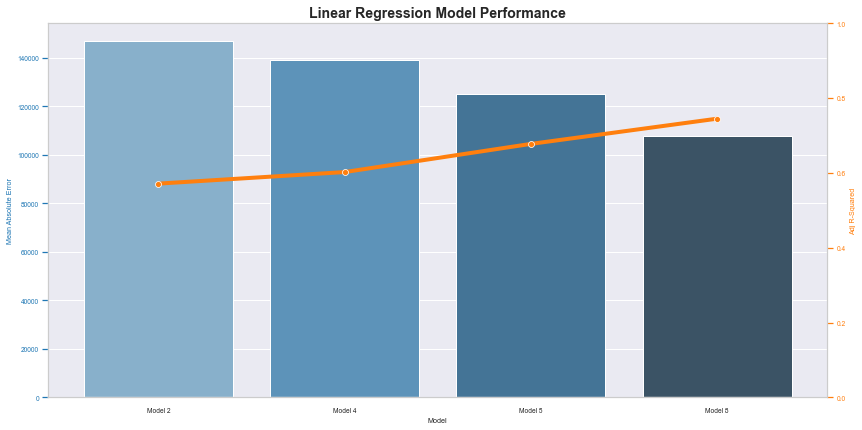

In [190]:
# create a dual-axis chart to show relative performance on MAE and Adjusted r^2
fig, ax1 = plt.subplots(figsize=(12,6))
sns.set_style("whitegrid")

sns.barplot(data = model_results, x='Model', y='Mean Absolute Error',  palette="Blues_d", ax=ax1)
ax1.set_title('Linear Regression Model Performance', fontweight="bold", fontsize=14)
ax1.yaxis.label.set_color('tab:blue')
ax1.tick_params(axis='y', colors='tab:blue')
ax2 = ax1.twinx()
sns.lineplot(data = model_results['Adj R-Squared'], marker='o', sort = False, color='tab:orange', linewidth=4, ax=ax2)
ax2.set(ylim=(0, 1))
ax2.yaxis.label.set_color('tab:orange')
ax2.tick_params(axis='y', colors='tab:orange')
ax2.grid(None)
plt.tight_layout()
plt.show()

In [191]:
# create df of model 8 predicted y, actual y and zip psf median (X)
y_test_m8_df = pd.DataFrame(y_test_m8, columns=['price_log'])
y_test_m8_results = pd.concat([y_test_m8_df, X_test_m8[['sqft_living_log','grade','condition','view','waterfront','basement_ind','renovation_ind','zip_psf_median_box']], 
                               pd.DataFrame(np.exp(y_pred_test_m8), columns=['price_pred'])], axis=1)
y_test_m8_results['price_act'] = np.exp(y_test_m8_results['price_log'])
y_test_m8_results['sqft_living'] = np.exp(y_test_m8_results['sqft_living_log'])
y_test_m8_results['zip_psf_median'] = inv_boxcox(y_test_m8_results['zip_psf_median_box'], median_lambda)
m8_plot_slice = y_test_m8_results[(y_test_m8_results['grade']==7) & (y_test_m8_results['condition']==3) & (y_test_m8_results['view']==0) &
                                 (y_test_m8_results['waterfront']==0) & (y_test_m8_results['basement_ind']==0) & (y_test_m8_results['renovation_ind']==0) &
                                 (y_test_m8_results['zip_psf_median'] > 200) & (y_test_m8_results['zip_psf_median'] < 300)]

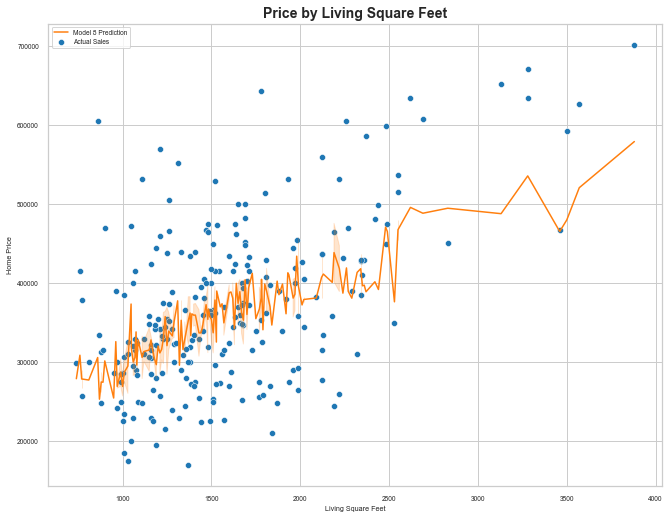

In [192]:
# create scatter plot and overlay regression line
fig, ax = plt.subplots(figsize=(11, 8.5))
sns.set_style('whitegrid')
ax.set_title('Price by Living Square Feet', fontweight='bold', fontsize=14)
ax.set_xlabel('Living Square Feet')
ax.set_ylabel('Home Price')
sns.scatterplot(data=m8_plot_slice, x='sqft_living', y='price_act', color='tab:blue', ax=ax)
sqft_living = m8_plot_slice['sqft_living']
price_pred = m8_plot_slice['price_pred']
sns.lineplot(x=sqft_living, y=price_pred, color='tab:orange', ax=ax)
ax.legend(['Model 8 Prediction', 'Actual Sales'])
plt.show()

In [193]:
# pull Rainy Paradise home example
m8_plot_slice[(m8_plot_slice['price_act']>340000) & (m8_plot_slice['price_act']<360000) & (m8_plot_slice['sqft_living'] > 2500)]

price_log  sqft_living_log      grade  condition       view  \
19498 12.76540268       7.83597458 7.00000000 3.00000000 0.00000000   

       waterfront  basement_ind  renovation_ind  zip_psf_median_box  \
19498  0.00000000    0.00000000      0.00000000          4.32871354   

            price_pred        price_act    sqft_living  zip_psf_median  
19498 376,586.31511528 349,900.00000000 2,530.00000000    201.82104565